In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
from plotly.subplots import make_subplots


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
test_set_160_20_20 = pd.read_table("./Splitting/160-20-20/DFs_split-160-20-20/test.txt",delim_whitespace=True, header=None)
test_set_160_20_20.columns = ['subject', 'relation','object', 'time_stamp']

output_160_20_20 = pd.read_table("./Splitting/160-20-20/output_1JPS_split_160-20-20/output_renet_1JPS_n_hidden_400.txt",delim_whitespace=True, header=None)
output_160_20_20.columns = ['subject','object', 'time_stamp']

test_set_100_50_50 = pd.read_table("./Splitting/100-50-50/DFs_split_100-50-50/test.txt",delim_whitespace=True, header=None)
test_set_100_50_50.columns = ['subject', 'relation','object', 'time_stamp']

output_100_50_50 = pd.read_table("./Splitting/100-50-50/output_1JPS_split_100-50-50/output_renet_1JPS_max_epoch_25.txt",delim_whitespace=True, header=None)
output_100_50_50.columns = ['subject','object', 'time_stamp']

test_set_50_75_75 = pd.read_table("./Splitting/50-75-75/DFs_split_50-75-75/test.txt",delim_whitespace=True, header=None)
test_set_50_75_75.columns = ['subject', 'relation','object', 'time_stamp']

output_50_75_75 = pd.read_table("./Splitting/50-75-75/output_1JPS_split_50-75-75/output_renet_1JPS_max_epoch_50.txt",delim_whitespace=True, header=None)
output_50_75_75.columns = ['subject','object', 'time_stamp']
output_50_75_75

subject  object  time_stamp
0          24      36         126
1          11      36         126
2          15      46         126
3          11      36         126
4          11      31         126
...       ...     ...         ...
1899       11      36         200
1900       11      31         200
1901       11      36         200
1902       11      36         200
1903       11      36         200

[1904 rows x 3 columns]

In [3]:
df_labels = pd.read_table("./labels.txt", sep=" ",header=None)
df_labels.columns = ['itype', 'chain_a', 'chain_b', 'resname_a', 'resname_b',
                             'resid_a',
                             'resid_b', 'atom_a', 'atom_b', 'time', 'itype_int',
                             'chain_res_a', 'chain_res_b', 'chain_atom_res_a', 'chain_atom_res_b', 'res_label_a',
                             'res_label_b', 'atom_label_a', 'atom_label_b']
df_labels['chain_a_b_time'] =    df_labels['chain_res_a']    +   df_labels['chain_res_b']    +  df_labels['time'].astype(str)
df_labels['chain_a_b'] =  df_labels['chain_res_a']    + df_labels['chain_res_b']
df_labels['residue_a'] =  df_labels['resid_a'].astype(str) + "-" + df_labels['resname_a'] 
df_labels['residue_b'] =  df_labels['resid_b'].astype(str) + "-" + df_labels['resname_b']
df_labels


def get_df_res_label(df_ifacea):
    df_label = pd.DataFrame()
    df_label['naming'] = list(df_ifacea['residue_a']) + list(df_ifacea['residue_b'])
    df_label['label'] = list(df_ifacea['res_label_a']) + list(df_ifacea['res_label_b'])
    df_label = df_label.drop_duplicates().reset_index(drop=True)
    return df_label

def get_label_dict(df_naming):
    zip_iterator = zip(df_naming['label'],df_naming['naming'])
    dict_labels = dict(zip_iterator)
    return dict_labels

def set_names_df(df_out, df_ifacea):
    subject_name, obj_name = [], []
    df_outputs_type = df_out.copy()

    dict_labels = get_label_dict(get_df_res_label(df_ifacea))

    #print(dict_labels)
    for i in range(len(df_outputs_type)):
        subject_name.append(dict_labels.get(df_outputs_type.iloc[i]['subject']))
        obj_name.append(dict_labels.get(df_outputs_type.iloc[i]['object']))

    df_outputs_type['subject_name'] = subject_name
    df_outputs_type['obj_name'] = obj_name
    df_outputs_type['pair'] = df_outputs_type['subject_name'] + '_' + df_outputs_type['obj_name']
    df_outputs_type['pair_relation'] = df_outputs_type['pair'] + '_' + df_out['relation'].astype(str)
    df_outputs_type['pair_time'] = df_outputs_type['pair'] + ' ' + df_out['time_stamp'].astype(str)
    return df_outputs_type

def set_names_df_output(df_out, df_ifacea):
    subject_name, obj_name = [], []
    df_outputs_type = df_out.copy()

    dict_labels = get_label_dict(get_df_res_label(df_ifacea))

    #print(dict_labels)
    for i in range(len(df_outputs_type)):
        subject_name.append(dict_labels.get(df_outputs_type.iloc[i]['subject']))
        obj_name.append(dict_labels.get(df_outputs_type.iloc[i]['object']))

    df_outputs_type['subject_name'] = subject_name
    df_outputs_type['obj_name'] = obj_name
    df_outputs_type['pair'] = df_outputs_type['subject_name'] + '_' + df_outputs_type['obj_name']
    return df_outputs_type

def get_res_heatmap_df(df_out):
    df_heat = df_out.pair_relation.value_counts()
    residue_a, residue_b, values, relation = [], [], [], []
    for pair in list(set(df_out['pair_relation'])):
        residue_a.append(pair.split('_')[0])
        residue_b.append(pair.split('_')[1])
        relation.append(pair.split('_')[2])
        values.append(df_heat[pair])
    df_heatvals = pd.DataFrame()
    df_heatvals['residue_a'] = residue_a
    df_heatvals['residue_b'] = residue_b
    df_heatvals['relation'] = relation
    df_heatvals['values'] = values
    return df_heatvals

def get_res_heatmap_df_output(df_out):
    df_heat = df_out.pair.value_counts()
    residue_a, residue_b, values = [], [], []
    for pair in list(set(df_out['pair'])):
        residue_a.append(pair.split('_')[0])
        residue_b.append(pair.split('_')[1])
        values.append(df_heat[pair])
    df_heatvals = pd.DataFrame()
    df_heatvals['residue_a'] = residue_a
    df_heatvals['residue_b'] = residue_b
    df_heatvals['values'] = values
    return df_heatvals

df_labels

itype chain_a chain_b resname_a resname_b  resid_a  resid_b  \
0     hydrophobic       A       C       TYR       LYS       32      169   
1     hydrophobic       A       C       GLU       ALA       93      168   
2     hydrophobic       A       C       GLU       LYS     1031      201   
3     hydrophobic       A       C       TYR       ARG     1032      200   
4     hydrophobic       A       C       TYR       LYS     1032      201   
...           ...     ...     ...       ...       ...      ...      ...   
9376        hbond       A       C       GLU       ARG     1031      200   
9377        hbond       A       C       GLU       ARG     1031      200   
9378        hbond       A       C       THR       ARG     1100      200   
9379        hbond       A       C       LYS       LYS     1030      201   
9380        ionic       A       C       ASP       LYS     1052      201   

     atom_a atom_b  time  ...  chain_atom_res_a chain_atom_res_b res_label_a  \
0       CE1     CD   0.0  ...            ACE132           CCD169          19   
1        CA     CA   0.0  ...             ACA93           CCA168          23   
2        CA     CD   0.0  ...           ACA1031           CCD201           2   
3       CD2     CD   0.0  ...          ACD21032           CCD200           3   
4        CA     CD   0.0  ...           ACA1032           CCD201           3   
...     ...    ...   ...  ...               ...              ...         ...   
9376    OE1      N  62.0  ...          AOE11031            CN200           2   
9377      O    NH1  62.0  ...            AO1031          CNH1200           2   
9378      O    NH2  62.0  ...            AO1100          CNH2200          14   
9379      O     NZ  62.0  ...            AO1030           CNZ201           1   
9380    OD2     NZ  62.0  ...          AOD21052           CNZ201           6   

     res_label_b atom_label_a  atom_label_b  chain_a_b_time  chain_a_b  \
0             38           34            30      A32C1690.0    A32C169   
1             37            5             2      A93C1680.0    A93C168   
2             51            0            34    A1031C2010.0  A1031C201   
3             50           25            33    A1032C2000.0  A1032C200   
4             51            1            34    A1032C2010.0  A1032C201   
...          ...          ...           ...             ...        ...   
9376          50           86            72   A1031C20062.0  A1031C200   
9377          50           72            77   A1031C20062.0  A1031C200   
9378          50           75            78   A1100C20062.0  A1100C200   
9379          51           71            83   A1030C20162.0  A1030C201   
9380          51           85            83   A1052C20162.0  A1052C201   

      residue_a residue_b  
0        32-TYR   169-LYS  
1        93-GLU   168-ALA  
2      1031-GLU   201-LYS  
3      1032-TYR   200-ARG  
4      1032-TYR   201-LYS  
...         ...       ...  
9376   1031-GLU   200-ARG  
9377   1031-GLU   200-ARG  
9378   1100-THR   200-ARG  
9379   1030-LYS   201-LYS  
9380   1052-ASP   201-LYS  

[9381 rows x 23 columns]

In [4]:
test_set_post_100_50_50 = set_names_df(test_set_100_50_50, df_labels).drop_duplicates().reset_index(drop=True)
test_set_post_process_100_50_50 = pd.DataFrame()
test_set_post_process_100_50_50['subject'] = test_set_post_100_50_50['subject_name']
test_set_post_process_100_50_50['object'] = test_set_post_100_50_50['obj_name']
test_set_post_process_100_50_50['time_stamp'] = test_set_post_100_50_50['time_stamp']
test_set_post_process_100_50_50['pair_relation'] = test_set_post_100_50_50['pair_relation']
test_set_post_process_100_50_50['pair'] = test_set_post_100_50_50['pair']

test_100_50_50 = get_res_heatmap_df(test_set_post_process_100_50_50)
test_100_50_50['pair'] = test_100_50_50['residue_a'] + '-' + test_100_50_50['residue_b']
test_100_50_50['time_stamp'] = test_set_post_process_100_50_50['time_stamp']
del test_100_50_50["pair"]
min_value_test_100_50_50 = test_100_50_50['values'].min()
max_value_test_100_50_50 = test_100_50_50['values'].max()
test_100_50_50['freq'] = 1 + (test_100_50_50['values'] - min_value_test_100_50_50) / (max_value_test_100_50_50 - min_value_test_100_50_50) * (100 - 1)
test_100_50_50['freq'] = test_100_50_50['freq'].apply(lambda x: round(x, 2))
test_100_50_50.to_excel("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/tables/100-50-50_ground_truth.xlsx",index=False)
test_set_post_process_100_50_50


subject   object  time_stamp       pair_relation              pair
0     1031-GLU  199-ASN         151  1031-GLU_199-ASN_1  1031-GLU_199-ASN
1       93-GLU  168-ALA         151    93-GLU_168-ALA_1    93-GLU_168-ALA
2       32-TYR  171-ASN         151    32-TYR_171-ASN_1    32-TYR_171-ASN
3       91-HIS  169-LYS         151    91-HIS_169-LYS_0    91-HIS_169-LYS
4       92-GLY  169-LYS         151    92-GLY_169-LYS_0    92-GLY_169-LYS
...        ...      ...         ...                 ...               ...
1331  1059-ILE  167-THR         200  1059-ILE_167-THR_1  1059-ILE_167-THR
1332  1057-ASN  156-TYR         200  1057-ASN_156-TYR_1  1057-ASN_156-TYR
1333  1059-ILE  156-TYR         200  1059-ILE_156-TYR_1  1059-ILE_156-TYR
1334  1059-ILE  166-LYS         200  1059-ILE_166-LYS_1  1059-ILE_166-LYS
1335  1059-ILE  165-LYS         200  1059-ILE_165-LYS_1  1059-ILE_165-LYS

[1336 rows x 5 columns]

In [5]:
test_set_post_160_20_20 = set_names_df(test_set_160_20_20, df_labels).drop_duplicates().reset_index(drop=True)
test_set_post_process_160_20_20 = pd.DataFrame()
test_set_post_process_160_20_20['subject'] = test_set_post_160_20_20['subject_name']
test_set_post_process_160_20_20['object'] = test_set_post_160_20_20['obj_name']
test_set_post_process_160_20_20['time_stamp'] = test_set_post_160_20_20['time_stamp']
test_set_post_process_160_20_20['pair_relation'] = test_set_post_160_20_20['pair_relation']
test_set_post_process_160_20_20['pair'] = test_set_post_160_20_20['pair']

test_160_20_20 = get_res_heatmap_df(test_set_post_process_160_20_20)
test_160_20_20['pair'] = test_160_20_20['residue_a'] + '-' + test_160_20_20['residue_b']
del test_160_20_20["pair"]
min_value_test_160_20_20 = test_160_20_20['values'].min()
max_value_test_160_20_20 = test_160_20_20['values'].max()
test_160_20_20['freq'] = 1 + (test_160_20_20['values'] - min_value_test_160_20_20) / (max_value_test_160_20_20 - min_value_test_160_20_20) * (100 - 1)
test_160_20_20['freq'] = test_160_20_20['freq'].apply(lambda x: round(x, 2))
test_160_20_20.to_excel("./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/tables/160-20-20_ground_truth.xlsx",index=False)
test_160_20_20

residue_a residue_b relation  values    freq
0     30-LYS   171-ASN        1       9   42.68
1   1059-ILE   166-LYS        1      10   47.89
2   1100-THR   194-PRO        0       1    1.00
3     30-LYS   171-ASN        0       7   32.26
4   1031-GLU   201-LYS        1      14   68.74
5     94-SER   167-THR        0      20  100.00
6     27-ARG   178-ASP        2      10   47.89
7   1055-GLN   204-ASP        1       3   11.42
8   1101-ALA   194-PRO        1      16   79.16
9   1057-ASN   165-LYS        0      13   63.53
10  1054-GLU   201-LYS        2      15   73.95
11  1055-GLN   201-LYS        0       1    1.00
12    32-TYR   152-ILE        1       6   27.05
13  1057-ASN   165-LYS        1      10   47.89
14    93-GLU   157-TYR        0       1    1.00
15    95-PRO   166-LYS        1       6   27.05
16    92-GLY   169-LYS        0      20  100.00
17  1102-ALA   194-PRO        1      16   79.16
18  1052-ASP   201-LYS        2      17   84.37
19  1033-TYR   201-LYS        1      12   58.32
20    32-TYR   171-ASN        1      13   63.53
21    91-HIS   169-LYS        0      20  100.00
22  1059-ILE   165-LYS        1      17   84.37
23  1031-GLU   200-ARG        0      15   73.95
24    93-GLU   157-TYR        1       1    1.00
25    93-GLU   168-ALA        1      16   79.16
26  1031-GLU   200-ARG        2      16   79.16
27  1033-TYR   190-GLN        0       3   11.42
28  1032-TYR   200-ARG        0       2    6.21
29    32-TYR   170-THR        0       6   27.05
30     1-ASP   166-LYS        2       9   42.68
31  1031-GLU   199-ASN        0      15   73.95
32    96-TRP   169-LYS        1      15   73.95
33  1031-GLU   200-ARG        1      16   79.16
34    32-TYR   171-ASN        0       9   42.68
35  1065-GLN   163-SER        0       1    1.00
36    96-TRP   167-THR        1       1    1.00
37  1033-TYR   156-TYR        0       1    1.00
38  1052-ASP   190-GLN        0       1    1.00
39  1059-ILE   167-THR        1      19   94.79
40  1100-THR   200-ARG        1      14   68.74
41  1054-GLU   201-LYS        1       4   16.63
42  1031-GLU   198-VAL        1      12   58.32
43    93-GLU   166-LYS        1       8   37.47
44  1059-ILE   156-TYR        1      20  100.00
45  1101-ALA   192-VAL        1      18   89.58
46  1031-GLU   199-ASN        1      15   73.95
47  1052-ASP   201-LYS        1      12   58.32
48  1100-THR   194-PRO        1      11   53.11
49  1030-LYS   201-LYS        0       3   11.42
50    32-TYR   169-LYS        1      20  100.00
51  1050-LEU   167-THR        1       4   16.63
52    30-LYS   170-THR        1       1    1.00
53     1-ASP   166-LYS        1       3   11.42
54  1057-ASN   156-TYR        1       3   11.42
55  1055-GLN   201-LYS        1       2    6.21
56  1101-ALA   152-ILE        1       4   16.63
57  1033-TYR   192-VAL        1       1    1.00
58    93-GLU   166-LYS        2       9   42.68

In [6]:
test_set_post_50_75_75 = set_names_df(test_set_50_75_75, df_labels).drop_duplicates().reset_index(drop=True)
test_set_post_process_50_75_75 = pd.DataFrame()
test_set_post_process_50_75_75['subject'] = test_set_post_50_75_75['subject_name']
test_set_post_process_50_75_75['object'] = test_set_post_50_75_75['obj_name']
test_set_post_process_50_75_75['time_stamp'] = test_set_post_50_75_75['time_stamp']
test_set_post_process_50_75_75['pair_relation'] = test_set_post_50_75_75['pair_relation']
test_set_post_process_50_75_75['pair'] = test_set_post_50_75_75['pair']

test_50_75_75 = get_res_heatmap_df(test_set_post_process_50_75_75)
test_50_75_75['pair'] = test_50_75_75['residue_a'] + '-' + test_50_75_75['residue_b']
del test_50_75_75["pair"]
min_value_test_50_75_75 = test_50_75_75['values'].min()
max_value_test_50_75_75 = test_50_75_75['values'].max()
test_50_75_75['freq'] = 1 + (test_50_75_75['values'] - min_value_test_50_75_75) / (max_value_test_50_75_75 - min_value_test_50_75_75) * (100 - 1)
test_50_75_75['freq'] = test_50_75_75['freq'].apply(lambda x: round(x, 2))
test_50_75_75.to_excel("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/tables/50-75-75_ground_truth.xlsx",index=False)
test_50_75_75

residue_a residue_b relation  values   freq
0     30-LYS   171-ASN        1      15  19.73
1   1059-ILE   166-LYS        1      41  54.51
2     30-LYS   171-ASN        0      29  38.46
3   1100-THR   194-PRO        0       3   3.68
4   1031-GLU   201-LYS        1      20  26.42
..       ...       ...      ...     ...    ...
65    50-TYR   152-ILE        1       3   3.68
66  1101-ALA   152-ILE        1      15  19.73
67  1033-TYR   192-VAL        1       8  10.36
68    93-GLU   177-ILE        1       6   7.69
69    93-GLU   166-LYS        2      14  18.39

[70 rows x 5 columns]

In [7]:
output_100_50_50_post = set_names_df_output(output_100_50_50, df_labels).drop_duplicates().reset_index(drop=True)
output_100_50_50_post_process = pd.DataFrame()
output_100_50_50_post_process['subject'] = output_100_50_50_post['subject_name']
output_100_50_50_post_process['object'] = output_100_50_50_post['obj_name']
output_100_50_50_post_process['time_stamp'] = output_100_50_50_post['time_stamp']
output_100_50_50_post_process['pair'] = output_100_50_50_post['pair']

output_100_50_50 = get_res_heatmap_df_output(output_100_50_50_post_process)
output_100_50_50['pair'] = output_100_50_50['residue_a'] + '-' + output_100_50_50['residue_b']
min_value_output_100_50_50 = output_100_50_50['values'].min()
max_value_output_100_50_50 = output_100_50_50['values'].max()
output_100_50_50['freq'] = 1 + (output_100_50_50['values'] - min_value_output_100_50_50) / (max_value_output_100_50_50 - min_value_output_100_50_50) * (100 - 1)
output_100_50_50['freq'] = output_100_50_50['freq'].apply(lambda x: round(x, 2))
output_100_50_50.to_excel("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/tables/100-50-50_prediction.xlsx",index=False)
output_100_50_50_post_process

subject   object  time_stamp              pair
0    1031-GLU  200-ARG         151  1031-GLU_200-ARG
1      93-GLU  168-ALA         151    93-GLU_168-ALA
2      32-TYR  169-LYS         151    32-TYR_169-LYS
3      91-HIS  169-LYS         151    91-HIS_169-LYS
4      94-SER  167-THR         151    94-SER_167-THR
..        ...      ...         ...               ...
809    91-HIS  171-ASN         200    91-HIS_171-ASN
810    93-GLU  168-ALA         200    93-GLU_168-ALA
811  1059-ILE  167-THR         200  1059-ILE_167-THR
812  1059-ILE  194-PRO         200  1059-ILE_194-PRO
813  1059-ILE  156-TYR         200  1059-ILE_156-TYR

[814 rows x 4 columns]

In [8]:
output_160_20_20_post = set_names_df_output(output_160_20_20, df_labels).drop_duplicates().reset_index(drop=True)
output_160_20_20_post_process = pd.DataFrame()
output_160_20_20_post_process['subject'] = output_160_20_20_post['subject_name']
output_160_20_20_post_process['object'] = output_160_20_20_post['obj_name']
output_160_20_20_post_process['time_stamp'] = output_160_20_20_post['time_stamp']
output_160_20_20_post_process['pair'] = output_160_20_20_post['pair']

output_160_20_20 = get_res_heatmap_df_output(output_160_20_20_post_process)
output_160_20_20['pair'] = output_160_20_20['residue_a'] + '-' + output_160_20_20['residue_b']
min_value_output_160_20_20 = output_160_20_20['values'].min()
max_value_output_160_20_20 = output_160_20_20['values'].max()
output_160_20_20['freq'] = 1 + (output_160_20_20['values'] - min_value_output_160_20_20) / (max_value_output_160_20_20 - min_value_output_160_20_20) * (100 - 1)
output_160_20_20['freq'] = output_160_20_20['freq'].apply(lambda x: round(x, 2))
output_160_20_20.to_excel("./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/tables/160-20-20_prediction.xlsx",index=False)
output_160_20_20

residue_a residue_b  values              pair    freq
0     32-TYR   176-LEU       9    32-TYR-176-LEU   42.68
1   1033-TYR   201-LYS      17  1033-TYR-201-LYS   84.37
2     27-ARG   178-ASP      10    27-ARG-178-ASP   47.89
3   1030-LYS   201-LYS       3  1030-LYS-201-LYS   11.42
4     32-TYR   171-ASN      17    32-TYR-171-ASN   84.37
5     93-GLU   157-TYR       1    93-GLU-157-TYR    1.00
6   1059-ILE   194-PRO       3  1059-ILE-194-PRO   11.42
7   1059-ILE   167-THR      20  1059-ILE-167-THR  100.00
8   1055-GLN   204-ASP       3  1055-GLN-204-ASP   11.42
9   1033-TYR   204-ASP       2  1033-TYR-204-ASP    6.21
10  1059-ILE   165-LYS      11  1059-ILE-165-LYS   53.11
11  1030-LYS   204-ASP       1  1030-LYS-204-ASP    1.00
12  1101-ALA   194-PRO      19  1101-ALA-194-PRO   94.79
13  1031-GLU   200-ARG      20  1031-GLU-200-ARG  100.00
14  1033-TYR   156-TYR       1  1033-TYR-156-TYR    1.00
15  1100-THR   200-ARG       1  1100-THR-200-ARG    1.00
16  1059-ILE   168-ALA       8  1059-ILE-168-ALA   37.47
17    32-TYR   169-LYS      20    32-TYR-169-LYS  100.00
18  1059-ILE   166-LYS       6  1059-ILE-166-LYS   27.05
19  1057-ASN   165-LYS      13  1057-ASN-165-LYS   63.53
20  1102-ALA   194-PRO      20  1102-ALA-194-PRO  100.00
21    93-GLU   166-LYS       9    93-GLU-166-LYS   42.68
22  1101-ALA   201-LYS       1  1101-ALA-201-LYS    1.00
23    93-GLU   178-ASP       9    93-GLU-178-ASP   42.68
24  1052-ASP   201-LYS      17  1052-ASP-201-LYS   84.37
25  1101-ALA   169-LYS       6  1101-ALA-169-LYS   27.05
26    91-HIS   169-LYS      20    91-HIS-169-LYS  100.00
27    94-SER   167-THR      20    94-SER-167-THR  100.00
28  1033-TYR   190-GLN       3  1033-TYR-190-GLN   11.42
29  1031-GLU   194-PRO      14  1031-GLU-194-PRO   68.74
30  1030-LYS   163-SER       1  1030-LYS-163-SER    1.00
31  1052-ASP   190-GLN       1  1052-ASP-190-GLN    1.00
32  1059-ILE   169-LYS       1  1059-ILE-169-LYS    1.00
33    93-GLU   168-ALA      16    93-GLU-168-ALA   79.16
34  1031-GLU   201-LYS      17  1031-GLU-201-LYS   84.37

In [9]:
output_50_75_75_post = set_names_df_output(output_50_75_75, df_labels).drop_duplicates().reset_index(drop=True)
output_50_75_75_post_process = pd.DataFrame()
output_50_75_75_post_process['subject'] = output_50_75_75_post['subject_name']
output_50_75_75_post_process['object'] = output_50_75_75_post['obj_name']
output_50_75_75_post_process['time_stamp'] = output_50_75_75_post['time_stamp']
output_50_75_75_post_process['pair'] = output_50_75_75_post['pair']
output_50_75_75_post_process_sorted = output_50_75_75_post_process.sort_values(by="subject")


output_50_75_75 = get_res_heatmap_df_output(output_50_75_75_post_process)
output_50_75_75['pair'] = output_50_75_75['residue_a'] + '-' + output_50_75_75['residue_b']
min_value_output_50_75_75 = output_50_75_75['values'].min()
max_value_output_50_75_75 = output_50_75_75['values'].max()
output_50_75_75['freq'] = 1 + (output_50_75_75['values'] - min_value_output_50_75_75) / (max_value_output_50_75_75 - min_value_output_50_75_75) * (100 - 1)
output_50_75_75['freq'] = output_50_75_75['freq'].apply(lambda x: round(x, 2))
output_50_75_75.to_excel("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/tables/50-75-75_prediction.xlsx",index=False)
output_50_75_75

residue_a residue_b  values              pair    freq
0     32-TYR   176-LEU      34    32-TYR-176-LEU   45.15
1     27-ARG   178-ASP      31    27-ARG-178-ASP   41.14
2   1030-LYS   201-LYS       4  1030-LYS-201-LYS    5.01
3   1059-ILE   156-TYR      52  1059-ILE-156-TYR   69.23
4     32-TYR   171-ASN      51    32-TYR-171-ASN   67.89
5   1100-THR   201-LYS      10  1100-THR-201-LYS   13.04
6   1059-ILE   194-PRO       3  1059-ILE-194-PRO    3.68
7   1032-TYR   194-PRO      60  1032-TYR-194-PRO   79.93
8   1032-TYR   200-ARG      33  1032-TYR-200-ARG   43.81
9   1059-ILE   167-THR      75  1059-ILE-167-THR  100.00
10  1101-ALA   171-ASN       3  1101-ALA-171-ASN    3.68
11  1055-GLN   204-ASP       5  1055-GLN-204-ASP    6.35
12  1033-TYR   204-ASP       4  1033-TYR-204-ASP    5.01
13  1100-THR   190-GLN       3  1100-THR-190-GLN    3.68
14  1030-LYS   204-ASP       1  1030-LYS-204-ASP    1.00
15  1059-ILE   201-LYS       1  1059-ILE-201-LYS    1.00
16  1101-ALA   194-PRO      70  1101-ALA-194-PRO   93.31
17  1031-GLU   200-ARG      44  1031-GLU-200-ARG   58.53
18    32-TYR   194-PRO       3    32-TYR-194-PRO    3.68
19  1052-ASP   203-THR      18  1052-ASP-203-THR   23.74
20  1100-THR   200-ARG      65  1100-THR-200-ARG   86.62
21  1052-ASP   200-ARG      20  1052-ASP-200-ARG   26.42
22  1059-ILE   168-ALA      12  1059-ILE-168-ALA   15.72
23    32-TYR   169-LYS      73    32-TYR-169-LYS   97.32
24  1059-ILE   166-LYS       9  1059-ILE-166-LYS   11.70
25  1052-ASP   204-ASP       3  1052-ASP-204-ASP    3.68
26  1052-ASP   165-LYS       1  1052-ASP-165-LYS    1.00
27  1057-ASN   165-LYS      31  1057-ASN-165-LYS   41.14
28  1102-ALA   194-PRO      74  1102-ALA-194-PRO   98.66
29    93-GLU   166-LYS      14    93-GLU-166-LYS   18.39
30  1101-ALA   201-LYS       8  1101-ALA-201-LYS   10.36
31    93-GLU   178-ASP      15    93-GLU-178-ASP   19.73
32  1052-ASP   201-LYS      73  1052-ASP-201-LYS   97.32
33  1101-ALA   169-LYS      17  1101-ALA-169-LYS   22.41
34    91-HIS   169-LYS      75    91-HIS-169-LYS  100.00
35    94-SER   167-THR      75    94-SER-167-THR  100.00
36  1033-TYR   190-GLN       5  1033-TYR-190-GLN    6.35
37  1052-ASP   190-GLN       7  1052-ASP-190-GLN    9.03
38  1059-ILE   169-LYS       2  1059-ILE-169-LYS    2.34
39    93-GLU   168-ALA      65    93-GLU-168-ALA   86.62
40  1031-GLU   201-LYS      27  1031-GLU-201-LYS   35.78

In [10]:
with open("./Splitting/160-20-20/DFs_split-160-20-20/train.txt",'r') as fr:
    train_data = []
    train_times = set()
    for line in fr:
        line_split = line.split()
        head = int(line_split[0])
        tail = int(line_split[2])
        rel = int(line_split[1])
        time = int(line_split[3])
        train_data.append([head, rel, tail, time])
        train_times.add(time)
with open("./Splitting/160-20-20/DFs_split-160-20-20/valid.txt", 'r') as fr:
    valid_data = []
    valid_times = set()
    for line in fr:
        line_split = line.split()
        head = int(line_split[0])
        tail = int(line_split[2])
        rel = int(line_split[1])
        time = int(line_split[3])
        valid_data.append([head, rel, tail, time])
        valid_times.add(time)
with open("./Splitting/160-20-20/DFs_split-160-20-20/test.txt", 'r') as fr:
    test_data = []
    test_times = set()
    for line in fr:
        line_split = line.split()
        head = int(line_split[0])
        tail = int(line_split[2])
        rel = int(line_split[1])
        time = int(line_split[3])
        test_data.append([head, rel, tail, time])
        test_times.add(time)
total_data = train_data + valid_data + test_data
s = []
o = []
for i in range(0,len(total_data)):
    s.append(total_data[i][0])
    o.append(total_data[i][2])
unique_s = len(np.unique(s))
unique_o = len(np.unique(o))
total = unique_o * unique_s

total_data
df = pd.DataFrame(total_data, columns=['subject', 'relation', 'object', 'time_stamp'])

df_set_post = set_names_df(df, df_labels).drop_duplicates().reset_index(drop=True)
df_set_post_process = pd.DataFrame()
df_set_post_process['subject'] = df_set_post['subject_name']
df_set_post_process['object'] = df_set_post['obj_name']
df_set_post_process['time_stamp'] = df_set_post['time_stamp']
df_set_post_process['relation'] = df_set_post['relation']
df_set_post_process['pair_relation'] = df_set_post['pair_relation']
df_set_post_process['pair'] = df_set_post['pair']
df_set_post_process['relation'].replace({0: 'H-bond'}, inplace=True)
df_set_post_process['relation'].replace({1: 'Hydrophobic'}, inplace=True)
df_set_post_process['relation'].replace({2: 'Ionic'}, inplace=True)
df_set_post_process['Type'] = "Ground_truth"
all_def_filtered = df_set_post_process.groupby(['time_stamp', 'pair']).head(1)
df_sorted = df_set_post_process.sort_values(by="subject")

df_set_post_process_50_75_75_merged = pd.concat([df_set_post_process, output_50_75_75_post_process], axis=0)
df_set_post_process_50_75_75_merged.fillna("Predicted_Set", inplace=True)
df_sorted_50_75_75 = df_set_post_process_50_75_75_merged.sort_values(by="subject")

df_set_post_process_100_50_50_merged = pd.concat([df_set_post_process, output_100_50_50_post_process], axis=0)
df_set_post_process_100_50_50_merged.fillna("Predicted_Set", inplace=True)
df_sorted_100_50_50 = df_set_post_process_100_50_50_merged.sort_values(by="subject")

df_set_post_process_160_20_20_merged = pd.concat([df_set_post_process, output_160_20_20_post_process], axis=0)
df_set_post_process_160_20_20_merged.fillna("Predicted_Set", inplace=True)
df_sorted_160_20_20 = df_set_post_process_160_20_20_merged.sort_values(by="subject")
result = df_sorted[df_sorted['pair'] == 'A1101_ALA-C169_LYS']

print(len(output_160_20_20_post_process))
print(len(df_set_post_process))


all_def_filtered

340
5499


subject   object  time_stamp     relation       pair_relation  \
0       32-TYR  169-LYS           0  Hydrophobic    32-TYR_169-LYS_1   
1     1033-TYR  190-GLN           0  Hydrophobic  1033-TYR_190-GLN_1   
2     1101-ALA  192-VAL           0  Hydrophobic  1101-ALA_192-VAL_1   
3     1102-ALA  194-PRO           0  Hydrophobic  1102-ALA_194-PRO_1   
4     1101-ALA  194-PRO           0  Hydrophobic  1101-ALA_194-PRO_1   
...        ...      ...         ...          ...                 ...   
5494  1059-ILE  167-THR         200  Hydrophobic  1059-ILE_167-THR_1   
5495  1057-ASN  156-TYR         200  Hydrophobic  1057-ASN_156-TYR_1   
5496  1059-ILE  156-TYR         200  Hydrophobic  1059-ILE_156-TYR_1   
5497  1059-ILE  166-LYS         200  Hydrophobic  1059-ILE_166-LYS_1   
5498  1059-ILE  165-LYS         200  Hydrophobic  1059-ILE_165-LYS_1   

                  pair          Type  
0       32-TYR_169-LYS  Ground_truth  
1     1033-TYR_190-GLN  Ground_truth  
2     1101-ALA_192-VAL  Ground_truth  
3     1102-ALA_194-PRO  Ground_truth  
4     1101-ALA_194-PRO  Ground_truth  
...                ...           ...  
5494  1059-ILE_167-THR  Ground_truth  
5495  1057-ASN_156-TYR  Ground_truth  
5496  1059-ILE_156-TYR  Ground_truth  
5497  1059-ILE_166-LYS  Ground_truth  
5498  1059-ILE_165-LYS  Ground_truth  

[4822 rows x 7 columns]

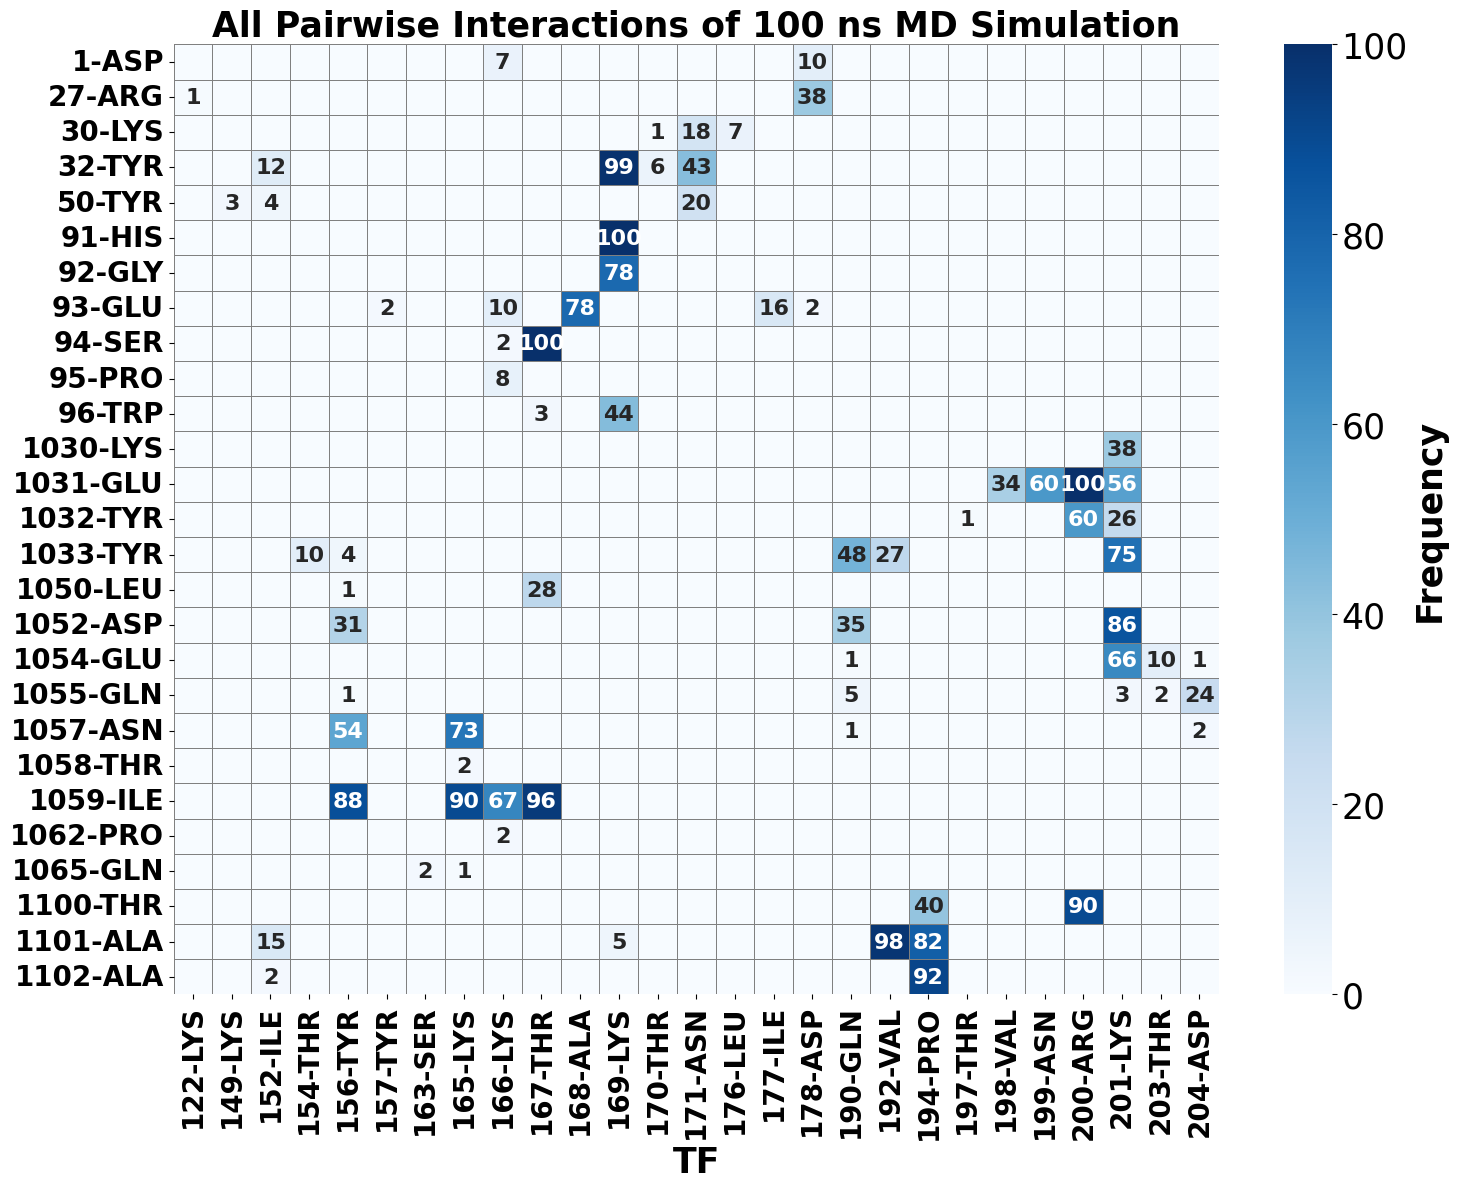

In [11]:
# factor = 10
vmin = 0  # Minimum value
vmax = 100  # Maximum value

all_def_filtered = df_set_post_process.groupby(['time_stamp', 'pair']).head(1)
all_interactions = get_res_heatmap_df_output(all_def_filtered)
min_value_all = all_interactions['values'].min()
max_value_all = all_interactions['values'].max()
all_interactions['freq'] = 1 + (all_interactions['values'] - min_value_all) / (max_value_all - min_value_all) * (100 - 1)
all_interactions['freq'] = all_interactions['freq'].apply(lambda x: round(x, 2))
all_interactions['numeric_order'] = all_interactions['residue_a'].apply(lambda x: int(x.split('-')[0]) if x.split('-')[0].isdigit() else float('inf'))
all_interactions_sorted = all_interactions.sort_values(by='numeric_order', ascending=True)
all_interactions_sorted['freq'] = all_interactions_sorted['freq'].round().astype(int)
test_pivot_all = pd.pivot_table(all_interactions_sorted,index='residue_a', columns='residue_b', values='freq', aggfunc='sum', fill_value=0)
test_pivot_all = test_pivot_all.reindex(all_interactions_sorted['residue_a'].unique())


# Create a 1x2 grid of subplots
fig, axes = plt.subplots(figsize=(15, 12))

# Plot the first heatmap
ax = sns.heatmap(test_pivot_all, cmap='Blues',linewidths=0.5, linecolor='gray',annot_kws={"weight": "bold","size":16},vmin=vmin, vmax=vmax,annot=True,fmt=".0f")
ax.set_title('All Pairwise Interactions of 100 ns MD Simulation', size=25, weight="bold")
ax.set_xlabel('TF', size=25, weight="bold")
ax.set_ylabel("")
for t in ax.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text()) #if the value is greater than 0 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text
ax.set_yticklabels(test_pivot_all.index, size = 20, weight="bold")
ax.set_xticklabels(test_pivot_all.columns, size = 20, weight="bold")

cbar1 = ax.collections[0].colorbar
cbar1.ax.tick_params(labelsize=25)
cbar1.set_label('Frequency',size=25, weight="bold")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.savefig('plots/heatmap_all.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
fig = px.histogram(df_sorted, y='pair')
fig.update_layout(height=1700,xaxis_range=[0,900],template="plotly_white",
                  title="<b>Bar for all pair interactions in ground truth</b>",title_x=0.5)
fig.update_traces(marker_color="#0074D9")
fig.update_xaxes(title_text='<b>Count</b>')
fig.update_yaxes(title_text='<b>Pairs</b>')
fig.write_image("plots/bar_all_interactions.png", scale=6)
fig.show()

In [14]:
fig = px.histogram(df_sorted, y='subject')
fig.update_layout(height=1700,xaxis_range=[0,900],template="plotly_white",
                  title="<b>Bar for pair interactions of heavy and light chains in groun truth</b>",title_x=0.5)
fig.update_traces(marker_color="#0074D9")
fig.update_xaxes(title_text='<b>Count</b>')
fig.update_yaxes(title_text='<b>Residues in Heavy and Light Chains</b>')
fig.write_image("plots/bar_chain_A_interactions.png", scale=6)
fig.show()


In [15]:
fig = px.histogram(df_sorted, y='object')
fig.update_layout(height=1700,xaxis_range=[0,900],template="plotly_white",
                  title="<b>Bar for pair interactions of tissue factor chains in ground truth</b>",title_x=0.5)
fig.update_xaxes(title_text='<b>Count</b>')
fig.update_yaxes(title_text='<b>Residues in Tissue Factor Chain</b>')
fig.update_traces(marker_color="#0074D9")
fig.write_image("plots/bar_chain_C_interactions.png",scale=6)
fig.show()


In [16]:
import plotly.graph_objects as go
fig = go.Figure()

sun = df_sorted_50_75_75[df_sorted_50_75_75["Type"] == "Ground_truth"]
sun_2 = df_sorted_50_75_75[df_sorted_50_75_75["Type"] == "Predicted_Set"]

# Add traces
fig.add_trace(go.Scatter(x=sun["time_stamp"], y=sun["pair"],mode='markers',
                        marker_color="#0074D9",marker_symbol="arrow",name="Ground Truth"))
fig.add_trace(go.Scatter(x=sun_2["time_stamp"], y=sun_2["pair"],mode='markers', opacity=0.4,
                        marker_color="#FFA500",marker_symbol="diamond",name="Predicted"))
fig.update_layout(height=1700,width=800,template="plotly_white",title="<b>Chart illustrating how interactions vary with time for 50-75-75 splitted dataset</b>",title_x=0.5,
                 xaxis_title="<b>Time</b>",
                 yaxis_title="<b>Pairs</b>")

fig.show()
fig.write_image("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/tables/time_50-75-75.png",scale=6)


In [17]:
import plotly.graph_objects as go
fig = go.Figure()

sun_3 = df_sorted_100_50_50[df_sorted_100_50_50["Type"] == "Ground_truth"]
sun_4 = df_sorted_100_50_50[df_sorted_100_50_50["Type"] == "Predicted_Set"]

# Add traces
fig.add_trace(go.Scatter(x=sun_3["time_stamp"], y=sun_3["pair"],mode='markers',
                        marker_color="#0074D9",marker_symbol="arrow",name="Ground Truth"))
fig.add_trace(go.Scatter(x=sun_4["time_stamp"], y=sun_4["pair"],mode='markers', opacity=0.4,
                        marker_color="#FFA500",marker_symbol="diamond",name="Predicted"))
fig.update_layout(height=1700,width=800,template="plotly_white",title="<b>Chart illustrating how interactions vary with time for 100-50-50 splitted dataset</b>",title_x=0.5,
                 xaxis_title="<b>Time</b>",
                 yaxis_title="<b>Pairs</b>")

fig.show()
fig.write_image("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/tables/time_100-50-50.png",scale=6)


In [18]:
fig = go.Figure()

sun_5 = df_sorted_160_20_20[df_sorted_160_20_20["Type"] == "Ground_truth"]
sun_6 = df_sorted_160_20_20[df_sorted_160_20_20["Type"] == "Predicted_Set"]

# Add traces
fig.add_trace(go.Scatter(x=sun_5["time_stamp"], y=sun_5["pair"],mode='markers',
                        marker_color="#0074D9",marker_symbol="arrow",name="Ground Truth"))
fig.add_trace(go.Scatter(x=sun_6["time_stamp"], y=sun_6["pair"],mode='markers', opacity=0.4,
                        marker_color="#FFA500",marker_symbol="diamond",name="Predicted"))
fig.update_layout(height=1700,width=800,template="plotly_white",title="<b>Chart illustrating how interactions vary with time for 160-20-20 splitted dataset</b>",title_x=0.5,
                 xaxis_title="<b>Time</b>",
                 yaxis_title="<b>Pairs</b>")

fig.show()
fig.write_image("./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/tables/time_160-20-20.png",scale=6)


In [19]:
ground_truth_50_75_75 = pd.read_excel("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/tables/50-75-75_ground_truth.xlsx")
ground_truth_100_50_50 = pd.read_excel("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/tables/100-50-50_ground_truth.xlsx")
ground_truth_160_20_20 = pd.read_excel("./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/tables/160-20-20_ground_truth.xlsx")

predicted_50_75_75 = pd.read_excel("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/tables/50-75-75_prediction.xlsx")
predicted_100_50_50 = pd.read_excel("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/tables/100-50-50_prediction.xlsx")
predicted_160_20_20 = pd.read_excel("./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/tables/160-20-20_prediction.xlsx")
#ground_truth_50_75_75["freq"]=ground_truth_50_75_75["freq"]*10
ground_truth_50_75_75["freq"]=ground_truth_50_75_75["freq"].astype(int)
#ground_truth_100_50_50["freq"]=ground_truth_100_50_50["freq"]*10
ground_truth_100_50_50["freq"]=ground_truth_100_50_50["freq"].astype(int)
#ground_truth_160_20_20["freq"]=ground_truth_160_20_20["freq"]*10
ground_truth_160_20_20["freq"]=ground_truth_160_20_20["freq"].astype(int)
#predicted_50_75_75["freq"]=predicted_50_75_75["freq"]*10
predicted_50_75_75["freq"]=predicted_50_75_75["freq"].astype(int)
#predicted_100_50_50["freq"]=predicted_100_50_50["freq"]*10
predicted_100_50_50["freq"]=predicted_100_50_50["freq"].astype(int)
#predicted_160_20_20["freq"] = predicted_160_20_20["freq"]*10
predicted_160_20_20['freq'] = predicted_160_20_20['freq'].astype(int)
predicted_160_20_20

residue_a residue_b  values              pair  freq
0     32-TYR   176-LEU       9    32-TYR-176-LEU    42
1   1033-TYR   201-LYS      17  1033-TYR-201-LYS    84
2     27-ARG   178-ASP      10    27-ARG-178-ASP    47
3   1030-LYS   201-LYS       3  1030-LYS-201-LYS    11
4     32-TYR   171-ASN      17    32-TYR-171-ASN    84
5     93-GLU   157-TYR       1    93-GLU-157-TYR     1
6   1059-ILE   194-PRO       3  1059-ILE-194-PRO    11
7   1059-ILE   167-THR      20  1059-ILE-167-THR   100
8   1055-GLN   204-ASP       3  1055-GLN-204-ASP    11
9   1033-TYR   204-ASP       2  1033-TYR-204-ASP     6
10  1059-ILE   165-LYS      11  1059-ILE-165-LYS    53
11  1030-LYS   204-ASP       1  1030-LYS-204-ASP     1
12  1101-ALA   194-PRO      19  1101-ALA-194-PRO    94
13  1031-GLU   200-ARG      20  1031-GLU-200-ARG   100
14  1033-TYR   156-TYR       1  1033-TYR-156-TYR     1
15  1100-THR   200-ARG       1  1100-THR-200-ARG     1
16  1059-ILE   168-ALA       8  1059-ILE-168-ALA    37
17    32-TYR   169-LYS      20    32-TYR-169-LYS   100
18  1059-ILE   166-LYS       6  1059-ILE-166-LYS    27
19  1057-ASN   165-LYS      13  1057-ASN-165-LYS    63
20  1102-ALA   194-PRO      20  1102-ALA-194-PRO   100
21    93-GLU   166-LYS       9    93-GLU-166-LYS    42
22  1101-ALA   201-LYS       1  1101-ALA-201-LYS     1
23    93-GLU   178-ASP       9    93-GLU-178-ASP    42
24  1052-ASP   201-LYS      17  1052-ASP-201-LYS    84
25  1101-ALA   169-LYS       6  1101-ALA-169-LYS    27
26    91-HIS   169-LYS      20    91-HIS-169-LYS   100
27    94-SER   167-THR      20    94-SER-167-THR   100
28  1033-TYR   190-GLN       3  1033-TYR-190-GLN    11
29  1031-GLU   194-PRO      14  1031-GLU-194-PRO    68
30  1030-LYS   163-SER       1  1030-LYS-163-SER     1
31  1052-ASP   190-GLN       1  1052-ASP-190-GLN     1
32  1059-ILE   169-LYS       1  1059-ILE-169-LYS     1
33    93-GLU   168-ALA      16    93-GLU-168-ALA    79
34  1031-GLU   201-LYS      17  1031-GLU-201-LYS    84

In [20]:
def custom_sort(value):
    numeric_part, string_part = value.split('-')
    return int(numeric_part), string_part

ground_truth_50_75_75['pair'] = ground_truth_50_75_75['residue_a'] + '-' + ground_truth_50_75_75['residue_b']
ground_truth_50_75_75['label'] = "False Negative (FN)"
predicted_50_75_75['label'] = "False Positive (FP)"
ground_truth_50_75_75['relation'].replace({0: 'H-bond', 1: 'Hydrophobic', 2: 'Ionic'}, inplace=True)
ground_truth_50_75_75_sorted = ground_truth_50_75_75['residue_a'].apply(custom_sort).sort_values().index
ground_truth_50_75_75_sorted = ground_truth_50_75_75.loc[ground_truth_50_75_75_sorted]
predicted_50_75_75_sorted = predicted_50_75_75['residue_a'].apply(custom_sort).sort_values().index
predicted_50_75_75_sorted = predicted_50_75_75.loc[predicted_50_75_75_sorted]

ground_truth_100_50_50['pair'] = ground_truth_100_50_50['residue_a'] + '-' + ground_truth_100_50_50['residue_b']
ground_truth_100_50_50['label'] = "False Negative (FN)"
predicted_100_50_50['label'] = "False Positive (FP)"
ground_truth_100_50_50['relation'].replace({0: 'H-bond', 1: 'Hydrophobic', 2: 'Ionic'}, inplace=True)
ground_truth_100_50_50_sorted = ground_truth_100_50_50['residue_a'].apply(custom_sort).sort_values().index
ground_truth_100_50_50_sorted = ground_truth_100_50_50.loc[ground_truth_100_50_50_sorted]
predicted_100_50_50_sorted = predicted_100_50_50['residue_a'].apply(custom_sort).sort_values().index
predicted_100_50_50_sorted = predicted_100_50_50.loc[predicted_100_50_50_sorted]


ground_truth_160_20_20['pair'] = ground_truth_160_20_20['residue_a'] + '-' + ground_truth_160_20_20['residue_b']
ground_truth_160_20_20['label'] = "False Negative (FN)"
predicted_160_20_20['label'] = "False Positive (FP)"
ground_truth_160_20_20['relation'].replace({0: 'H-bond', 1: 'Hydrophobic', 2: 'Ionic'}, inplace=True)
ground_truth_160_20_20_sorted = ground_truth_160_20_20['residue_a'].apply(custom_sort).sort_values().index
ground_truth_160_20_20_sorted = ground_truth_160_20_20.loc[ground_truth_160_20_20_sorted]
predicted_160_20_20_sorted = predicted_160_20_20['residue_a'].apply(custom_sort).sort_values().index
predicted_160_20_20_sorted = predicted_160_20_20.loc[predicted_160_20_20_sorted]


In [21]:
# factor = 10
vmin = 0  # Minimum value
vmax = 100  # Maximum value

filtered_df = test_set_post_process_160_20_20.groupby(['time_stamp', 'pair']).head(1)
filtered_df_160_20_20 = get_res_heatmap_df_output(filtered_df)
filtered_df_160_20_20['pair'] = filtered_df_160_20_20['residue_a'] + '-' + filtered_df_160_20_20['residue_b']
min_value_filtered_df_160_20_20 = filtered_df_160_20_20['values'].min()
max_value_filtered_df_160_20_20 = filtered_df_160_20_20['values'].max()
filtered_df_160_20_20['freq'] = 1 + (filtered_df_160_20_20['values'] - min_value_filtered_df_160_20_20) / (max_value_filtered_df_160_20_20 - min_value_filtered_df_160_20_20) * (100 - 1)
filtered_df_160_20_20['freq'] = filtered_df_160_20_20['freq'].apply(lambda x: round(x, 2))
filtered_df_160_20_20_sorted = filtered_df_160_20_20['residue_a'].apply(custom_sort).sort_values().index
filtered_df_160_20_20_sorted = filtered_df_160_20_20.loc[filtered_df_160_20_20_sorted]
filtered_df_160_20_20_sorted['freq'] = filtered_df_160_20_20_sorted['freq'].round().astype(int)
filtered_df_160_20_20_sorted['label'] = "False Negative (FN)"

unique_rows_filtered_df_160_20_20_sorted = filtered_df_160_20_20_sorted[~filtered_df_160_20_20_sorted["pair"].isin(predicted_160_20_20_sorted["pair"])]

res_merg_160_20_20 = pd.merge(filtered_df_160_20_20_sorted, predicted_160_20_20_sorted,how='outer')
res = res_merg_160_20_20[['residue_a', 'residue_b','pair']]
res_drop = res.drop_duplicates()

merged_df_filtered_160_20_20 = pd.concat([unique_rows_filtered_df_160_20_20_sorted, predicted_160_20_20_sorted],axis=0)
merged_df_filtered_160_20_20.fillna("Predicted_Set", inplace=True)

res_merg_ground_truth = pd.merge(res_drop, filtered_df_160_20_20_sorted,how='outer')
res_merg_predicted = pd.merge(res_drop, predicted_160_20_20_sorted,how='outer')
test_pivot_160_20_20_values = pd.pivot_table(res_merg_ground_truth,index='residue_a', columns='residue_b', values='values', aggfunc='sum', fill_value=0)
predicted_160_20_20_sorted_pivot_values = pd.pivot_table(res_merg_predicted,index='residue_a', columns='residue_b', values='values', aggfunc='sum', fill_value=0)


In [22]:
filtered_df = test_set_post_process_100_50_50.groupby(['time_stamp', 'pair']).head(1)
filtered_df_100_50_50 = get_res_heatmap_df_output(filtered_df)
filtered_df_100_50_50['pair'] = filtered_df_100_50_50['residue_a'] + '-' + filtered_df_100_50_50['residue_b']
min_value_filtered_df_100_50_50 = filtered_df_100_50_50['values'].min()
max_value_filtered_df_100_50_50 = filtered_df_100_50_50['values'].max()
filtered_df_100_50_50['freq'] = 1 + (filtered_df_100_50_50['values'] - min_value_filtered_df_100_50_50) / (max_value_filtered_df_100_50_50 - min_value_filtered_df_100_50_50) * (100 - 1)
filtered_df_100_50_50['freq'] = filtered_df_100_50_50['freq'].apply(lambda x: round(x, 2))
filtered_df_100_50_50_sorted = filtered_df_100_50_50.sort_values(by="residue_a")
filtered_df_100_50_50_sorted['freq'] = filtered_df_100_50_50_sorted['freq'].round().astype(int)
filtered_df_100_50_50_sorted['label'] = "False Negative (FN)"

res_merg_100_50_50 = pd.merge(filtered_df_100_50_50_sorted, predicted_100_50_50_sorted,how='outer')
res = res_merg_100_50_50[['residue_a', 'residue_b','pair']]
res_drop = res.drop_duplicates()

filtered_df_100_50_50_sorted = filtered_df_100_50_50_sorted.sort_values(by="residue_a")
unique_rows_filtered_df_100_50_50_sorted = filtered_df_100_50_50_sorted[~filtered_df_100_50_50_sorted["pair"].isin(predicted_100_50_50_sorted["pair"])]
merged_df_filtered_100_50_50 = pd.concat([unique_rows_filtered_df_100_50_50_sorted, predicted_100_50_50_sorted],axis=0)
merged_df_filtered_100_50_50.fillna("Predicted_Set", inplace=True)

res_merg_ground_truth = pd.merge(res_drop, filtered_df_100_50_50_sorted,how='outer')
res_merg_predicted = pd.merge(res_drop, predicted_100_50_50_sorted,how='outer')
test_pivot_100_50_50_values = pd.pivot_table(res_merg_ground_truth,index='residue_a', columns='residue_b', values='values', aggfunc='sum', fill_value=0)
predicted_100_50_50_sorted_pivot_values = pd.pivot_table(res_merg_predicted,index='residue_a', columns='residue_b', values='values', aggfunc='sum', fill_value=0)
filtered_df_100_50_50_sorted


residue_a residue_b  values              pair  freq                label
29     1-ASP   166-LYS      13     1-ASP-166-LYS    25  False Negative (FN)
2   1030-LYS   201-LYS       4  1030-LYS-201-LYS     7  False Negative (FN)
48  1031-GLU   198-VAL      25  1031-GLU-198-VAL    49  False Negative (FN)
47  1031-GLU   201-LYS      20  1031-GLU-201-LYS    39  False Negative (FN)
19  1031-GLU   200-ARG      50  1031-GLU-200-ARG   100  False Negative (FN)
31  1031-GLU   199-ASN      40  1031-GLU-199-ASN    80  False Negative (FN)
7   1032-TYR   200-ARG       8  1032-TYR-200-ARG    15  False Negative (FN)
42  1033-TYR   190-GLN       5  1033-TYR-190-GLN     9  False Negative (FN)
37  1033-TYR   192-VAL       5  1033-TYR-192-VAL     9  False Negative (FN)
18  1033-TYR   156-TYR       4  1033-TYR-156-TYR     7  False Negative (FN)
0   1033-TYR   201-LYS      35  1033-TYR-201-LYS    70  False Negative (FN)
15  1050-LEU   167-THR       8  1050-LEU-167-THR    15  False Negative (FN)
36  1052-ASP   201-LYS      47  1052-ASP-201-LYS    94  False Negative (FN)
11  1052-ASP   156-TYR       1  1052-ASP-156-TYR     1  False Negative (FN)
45  1052-ASP   190-GLN       1  1052-ASP-190-GLN     1  False Negative (FN)
17  1054-GLU   201-LYS      41  1054-GLU-201-LYS    82  False Negative (FN)
23  1055-GLN   201-LYS       3  1055-GLN-201-LYS     5  False Negative (FN)
13  1055-GLN   204-ASP       5  1055-GLN-204-ASP     9  False Negative (FN)
30  1055-GLN   190-GLN       2  1055-GLN-190-GLN     3  False Negative (FN)
32  1057-ASN   165-LYS      39  1057-ASN-165-LYS    78  False Negative (FN)
40  1057-ASN   156-TYR      17  1057-ASN-156-TYR    33  False Negative (FN)
5   1059-ILE   156-TYR      43  1059-ILE-156-TYR    86  False Negative (FN)
26  1059-ILE   166-LYS      25  1059-ILE-166-LYS    49  False Negative (FN)
10  1059-ILE   167-THR      49  1059-ILE-167-THR    98  False Negative (FN)
14  1059-ILE   165-LYS      45  1059-ILE-165-LYS    90  False Negative (FN)
24  1065-GLN   163-SER       3  1065-GLN-163-SER     5  False Negative (FN)
22  1100-THR   200-ARG      41  1100-THR-200-ARG    82  False Negative (FN)
43  1100-THR   194-PRO      26  1100-THR-194-PRO    52  False Negative (FN)
38  1101-ALA   169-LYS       1  1101-ALA-169-LYS     1  False Negative (FN)
9   1101-ALA   192-VAL      46  1101-ALA-192-VAL    92  False Negative (FN)
8   1101-ALA   152-ILE       5  1101-ALA-152-ILE     9  False Negative (FN)
20  1101-ALA   194-PRO      39  1101-ALA-194-PRO    78  False Negative (FN)
33  1102-ALA   194-PRO      40  1102-ALA-194-PRO    80  False Negative (FN)
1     27-ARG   178-ASP      14    27-ARG-178-ASP    27  False Negative (FN)
16    30-LYS   170-THR       1    30-LYS-170-THR     1  False Negative (FN)
12    30-LYS   171-ASN      26    30-LYS-171-ASN    52  False Negative (FN)
4     32-TYR   171-ASN      39    32-TYR-171-ASN    78  False Negative (FN)
44    32-TYR   170-THR      10    32-TYR-170-THR    19  False Negative (FN)
34    32-TYR   152-ILE      14    32-TYR-152-ILE    27  False Negative (FN)
25    32-TYR   169-LYS      50    32-TYR-169-LYS   100  False Negative (FN)
3     50-TYR   152-ILE       3    50-TYR-152-ILE     5  False Negative (FN)
39    91-HIS   169-LYS      50    91-HIS-169-LYS   100  False Negative (FN)
49    92-GLY   169-LYS      47    92-GLY-169-LYS    94  False Negative (FN)
46    93-GLU   168-ALA      43    93-GLU-168-ALA    86  False Negative (FN)
35    93-GLU   166-LYS      14    93-GLU-166-LYS    27  False Negative (FN)
6     93-GLU   157-TYR       2    93-GLU-157-TYR     3  False Negative (FN)
41    94-SER   167-THR      50    94-SER-167-THR   100  False Negative (FN)
27    95-PRO   166-LYS       8    95-PRO-166-LYS    15  False Negative (FN)
28    96-TRP   169-LYS      35    96-TRP-169-LYS    70  False Negative (FN)
21    96-TRP   167-THR       1    96-TRP-167-THR     1  False Negative (FN)

In [23]:
filtered_df = test_set_post_process_50_75_75.groupby(['time_stamp', 'pair']).head(1)
filtered_df_50_75_75 = get_res_heatmap_df_output(filtered_df)
filtered_df_50_75_75['pair'] = filtered_df_50_75_75['residue_a'] + '-' + filtered_df_50_75_75['residue_b']
min_value_filtered_df_50_75_75 = filtered_df_50_75_75['values'].min()
max_value_filtered_df_50_75_75 = filtered_df_50_75_75['values'].max()
filtered_df_50_75_75['freq'] = 1 + (filtered_df_50_75_75['values'] - min_value_filtered_df_50_75_75) / (max_value_filtered_df_50_75_75 - min_value_filtered_df_50_75_75) * (100 - 1)
filtered_df_50_75_75['freq'] = filtered_df_50_75_75['freq'].apply(lambda x: round(x, 2))
filtered_df_50_75_75_sorted = filtered_df_50_75_75.sort_values(by="residue_a")
filtered_df_50_75_75_sorted['freq'] = filtered_df_50_75_75_sorted['freq'].round().astype(int)
filtered_df_50_75_75_sorted['label'] = "False Negative (FN)"

res_merg_50_75_75 = pd.merge(filtered_df_50_75_75_sorted, predicted_50_75_75_sorted,how='outer')
res = res_merg_50_75_75[['residue_a', 'residue_b','pair']]
res_drop = res.drop_duplicates()

filtered_df_50_75_75_sorted = filtered_df_50_75_75_sorted.sort_values(by="residue_a")
unique_rows_filtered_df_50_75_75_sorted = filtered_df_50_75_75_sorted[~filtered_df_50_75_75_sorted["pair"].isin(predicted_50_75_75_sorted["pair"])]
merged_df_filtered_50_75_75 = pd.concat([unique_rows_filtered_df_50_75_75_sorted, predicted_50_75_75_sorted],axis=0)
merged_df_filtered_50_75_75.fillna("Predicted_Set", inplace=True)

res_merg_ground_truth = pd.merge(res_drop, filtered_df_50_75_75_sorted,how='outer')
res_merg_predicted = pd.merge(res_drop, predicted_50_75_75_sorted,how='outer')
test_pivot_50_75_75_values = pd.pivot_table(res_merg_ground_truth,index='residue_a', columns='residue_b', values='values', aggfunc='sum', fill_value=0)
predicted_50_75_75_sorted_pivot_values = pd.pivot_table(res_merg_predicted,index='residue_a', columns='residue_b', values='values', aggfunc='sum', fill_value=0)
filtered_df_50_75_75

residue_a residue_b  values              pair    freq
0   1033-TYR   201-LYS      53  1033-TYR-201-LYS   70.57
1     27-ARG   178-ASP      31    27-ARG-178-ASP   41.14
2   1030-LYS   201-LYS       4  1030-LYS-201-LYS    5.01
3     50-TYR   152-ILE       3    50-TYR-152-ILE    3.68
4   1059-ILE   156-TYR      64  1059-ILE-156-TYR   85.28
5     32-TYR   171-ASN      53    32-TYR-171-ASN   70.57
6     93-GLU   157-TYR       3    93-GLU-157-TYR    3.68
7   1101-ALA   152-ILE      15  1101-ALA-152-ILE   19.73
8   1032-TYR   200-ARG      10  1032-TYR-200-ARG   13.04
9   1101-ALA   192-VAL      68  1101-ALA-192-VAL   90.64
10  1059-ILE   167-THR      72  1059-ILE-167-THR   95.99
11  1052-ASP   156-TYR       1  1052-ASP-156-TYR    1.00
12    30-LYS   171-ASN      34    30-LYS-171-ASN   45.15
13  1055-GLN   204-ASP       5  1055-GLN-204-ASP    6.35
14  1059-ILE   165-LYS      69  1059-ILE-165-LYS   91.97
15  1050-LEU   167-THR      11  1050-LEU-167-THR   14.38
16    30-LYS   170-THR       1    30-LYS-170-THR    1.00
17     1-ASP   178-ASP       4     1-ASP-178-ASP    5.01
18  1054-GLU   201-LYS      63  1054-GLU-201-LYS   83.95
19  1101-ALA   194-PRO      56  1101-ALA-194-PRO   74.58
20  1031-GLU   200-ARG      73  1031-GLU-200-ARG   97.32
21  1033-TYR   156-TYR       6  1033-TYR-156-TYR    7.69
22    96-TRP   167-THR       2    96-TRP-167-THR    2.34
23    93-GLU   177-ILE       6    93-GLU-177-ILE    7.69
24  1100-THR   200-ARG      60  1100-THR-200-ARG   79.93
25  1055-GLN   201-LYS       3  1055-GLN-201-LYS    3.68
26  1065-GLN   163-SER       3  1065-GLN-163-SER    3.68
27    32-TYR   169-LYS      73    32-TYR-169-LYS   97.32
28  1059-ILE   166-LYS      41  1059-ILE-166-LYS   54.51
29    95-PRO   166-LYS       9    95-PRO-166-LYS   11.70
30    96-TRP   169-LYS      47    96-TRP-169-LYS   62.54
31     1-ASP   166-LYS      13     1-ASP-166-LYS   17.05
32  1055-GLN   190-GLN       4  1055-GLN-190-GLN    5.01
33  1031-GLU   199-ASN      43  1031-GLU-199-ASN   57.19
34  1057-ASN   165-LYS      54  1057-ASN-165-LYS   71.91
35  1102-ALA   194-PRO      61  1102-ALA-194-PRO   81.27
36    32-TYR   152-ILE      17    32-TYR-152-ILE   22.41
37    93-GLU   166-LYS      14    93-GLU-166-LYS   18.39
38  1052-ASP   201-LYS      70  1052-ASP-201-LYS   93.31
39  1033-TYR   192-VAL       8  1033-TYR-192-VAL   10.36
40  1101-ALA   169-LYS       3  1101-ALA-169-LYS    3.68
41    91-HIS   169-LYS      74    91-HIS-169-LYS   98.66
42  1062-PRO   166-LYS       1  1062-PRO-166-LYS    1.00
43  1057-ASN   156-TYR      30  1057-ASN-156-TYR   39.80
44    94-SER   167-THR      75    94-SER-167-THR  100.00
45  1033-TYR   190-GLN       5  1033-TYR-190-GLN    6.35
46  1100-THR   194-PRO      48  1100-THR-194-PRO   63.88
47    32-TYR   170-THR      11    32-TYR-170-THR   14.38
48  1052-ASP   190-GLN       1  1052-ASP-190-GLN    1.00
49    93-GLU   168-ALA      64    93-GLU-168-ALA   85.28
50  1031-GLU   201-LYS      20  1031-GLU-201-LYS   26.42
51  1031-GLU   198-VAL      28  1031-GLU-198-VAL   37.12
52    92-GLY   169-LYS      72    92-GLY-169-LYS   95.99

In [24]:
def heatmap_similarity_score(test_pivot, predicted_pivot):
    #create a matrix from pivot tables
    matrix_test = test_pivot.values
    matrix_predicted = predicted_pivot.values
    
    #matrix substraction and calculating absolute values
    subs_matrix = np.abs(matrix_test - matrix_predicted)
    
    #sum of all numbers in the matrix
    sum_of_matrix = np.sum(subs_matrix)
    
    #find the number of elements in a matrix that are greater than zero
    len_positive_elements = len(subs_matrix[subs_matrix > 0])
    
    score = sum_of_matrix / len_positive_elements
    print("sum of matrix:", sum_of_matrix)
    print("length of positive numbers:", len_positive_elements)
    print(score)
    
heatmap_similarity_score(test_pivot_160_20_20_values,predicted_160_20_20_sorted_pivot_values)
heatmap_similarity_score(test_pivot_100_50_50_values,predicted_100_50_50_sorted_pivot_values)
heatmap_similarity_score(test_pivot_50_75_75_values,predicted_50_75_75_sorted_pivot_values)

sum of matrix: 288
length of positive numbers: 43
6.6976744186046515
sum of matrix: 829
length of positive numbers: 55
15.072727272727272
sum of matrix: 1065
length of positive numbers: 64
16.640625


In [25]:
# Identify unique rows in df1 based on "key_column"
unique_rows_ground_truth_50_75_75 = ground_truth_50_75_75_sorted[~ground_truth_50_75_75_sorted['pair'].isin(predicted_50_75_75_sorted['pair'])]
#unique_rows_ground_truth_50_75_75.to_excel("nonpredicted_interactions_50-75-75.xlsx", index=False)
unique_rows_ground_truth_100_50_50 = ground_truth_100_50_50_sorted[~ground_truth_100_50_50_sorted['pair'].isin(predicted_100_50_50_sorted['pair'])]
#unique_rows_ground_truth_100_50_50.to_excel("nonpredicted_interactions_100-50-50.xlsx", index=False)
unique_rows_ground_truth_160_20_20 = ground_truth_160_20_20_sorted[~ground_truth_160_20_20_sorted['pair'].isin(predicted_160_20_20_sorted['pair'])]
#unique_rows_ground_truth_160_20_20.to_excel("nonpredicted_interactions_160-20-20.xlsx", index=False)

# Identify unique rows in df2 based on "key_column"
unique_rows_predicted_50_75_75 = predicted_50_75_75_sorted[~predicted_50_75_75_sorted['pair'].isin(ground_truth_50_75_75_sorted['pair'])]
#unique_rows_predicted_50_75_75.to_excel("unique_predicted_interactions_50-75-75.xlsx", index=False)
unique_rows_predicted_100_50_50 = predicted_100_50_50_sorted[~predicted_100_50_50_sorted['pair'].isin(ground_truth_100_50_50_sorted['pair'])]
#unique_rows_predicted_100_50_50.to_excel("unique_predicted_interactions_100_50_50.xlsx", index=False)
unique_rows_predicted_160_20_20 = predicted_160_20_20_sorted[~predicted_160_20_20_sorted['pair'].isin(ground_truth_160_20_20_sorted['pair'])]
#unique_rows_predicted_160_20_20.to_excel("unique_predicted_interactions_160_20_20.xlsx", index=False)
unique_rows_ground_truth_160_20_20


residue_a residue_b     relation  values  freq              pair  \
53     1-ASP   166-LYS  Hydrophobic       3    11     1-ASP-166-LYS   
30     1-ASP   166-LYS        Ionic       9    42     1-ASP-166-LYS   
0     30-LYS   171-ASN  Hydrophobic       9    42    30-LYS-171-ASN   
52    30-LYS   170-THR  Hydrophobic       1     1    30-LYS-170-THR   
3     30-LYS   171-ASN       H-bond       7    32    30-LYS-171-ASN   
12    32-TYR   152-ILE  Hydrophobic       6    27    32-TYR-152-ILE   
29    32-TYR   170-THR       H-bond       6    27    32-TYR-170-THR   
16    92-GLY   169-LYS       H-bond      20   100    92-GLY-169-LYS   
15    95-PRO   166-LYS  Hydrophobic       6    27    95-PRO-166-LYS   
32    96-TRP   169-LYS  Hydrophobic      15    73    96-TRP-169-LYS   
36    96-TRP   167-THR  Hydrophobic       1     1    96-TRP-167-THR   
42  1031-GLU   198-VAL  Hydrophobic      12    58  1031-GLU-198-VAL   
31  1031-GLU   199-ASN       H-bond      15    73  1031-GLU-199-ASN   
46  1031-GLU   199-ASN  Hydrophobic      15    73  1031-GLU-199-ASN   
28  1032-TYR   200-ARG       H-bond       2     6  1032-TYR-200-ARG   
57  1033-TYR   192-VAL  Hydrophobic       1     1  1033-TYR-192-VAL   
51  1050-LEU   167-THR  Hydrophobic       4    16  1050-LEU-167-THR   
41  1054-GLU   201-LYS  Hydrophobic       4    16  1054-GLU-201-LYS   
10  1054-GLU   201-LYS        Ionic      15    73  1054-GLU-201-LYS   
11  1055-GLN   201-LYS       H-bond       1     1  1055-GLN-201-LYS   
55  1055-GLN   201-LYS  Hydrophobic       2     6  1055-GLN-201-LYS   
54  1057-ASN   156-TYR  Hydrophobic       3    11  1057-ASN-156-TYR   
44  1059-ILE   156-TYR  Hydrophobic      20   100  1059-ILE-156-TYR   
35  1065-GLN   163-SER       H-bond       1     1  1065-GLN-163-SER   
2   1100-THR   194-PRO       H-bond       1     1  1100-THR-194-PRO   
48  1100-THR   194-PRO  Hydrophobic      11    53  1100-THR-194-PRO   
45  1101-ALA   192-VAL  Hydrophobic      18    89  1101-ALA-192-VAL   
56  1101-ALA   152-ILE  Hydrophobic       4    16  1101-ALA-152-ILE   

                  label  
53  False Negative (FN)  
30  False Negative (FN)  
0   False Negative (FN)  
52  False Negative (FN)  
3   False Negative (FN)  
12  False Negative (FN)  
29  False Negative (FN)  
16  False Negative (FN)  
15  False Negative (FN)  
32  False Negative (FN)  
36  False Negative (FN)  
42  False Negative (FN)  
31  False Negative (FN)  
46  False Negative (FN)  
28  False Negative (FN)  
57  False Negative (FN)  
51  False Negative (FN)  
41  False Negative (FN)  
10  False Negative (FN)  
11  False Negative (FN)  
55  False Negative (FN)  
54  False Negative (FN)  
44  False Negative (FN)  
35  False Negative (FN)  
2   False Negative (FN)  
48  False Negative (FN)  
45  False Negative (FN)  
56  False Negative (FN)

In [26]:
merged_df_50_75_75 = pd.concat([ground_truth_50_75_75_sorted, predicted_50_75_75_sorted],axis=0)
merged_df_50_75_75.fillna("Predicted_Set", inplace=True)
merged_df_100_50_50 = pd.concat([ground_truth_100_50_50_sorted, predicted_100_50_50_sorted],axis=0)
merged_df_100_50_50.fillna("Predicted_Set", inplace=True)
merged_df_160_20_20 = pd.concat([ground_truth_160_20_20_sorted, predicted_160_20_20_sorted],axis=0)
merged_df_160_20_20.fillna("Predicted_Set", inplace=True)

unique_rows_50_75_75 = pd.concat([unique_rows_filtered_df_50_75_75_sorted, unique_rows_predicted_50_75_75],axis=0)
unique_rows_100_50_50 = pd.concat([unique_rows_filtered_df_100_50_50_sorted, unique_rows_predicted_100_50_50],axis=0)
unique_rows_160_20_20 = pd.concat([unique_rows_filtered_df_160_20_20_sorted, unique_rows_predicted_160_20_20],axis=0)
unique_rows_160_20_20

residue_a residue_b  values              pair  freq                label
27     1-ASP   166-LYS       9     1-ASP-166-LYS    43  False Negative (FN)
13    30-LYS   170-THR       1    30-LYS-170-THR     1  False Negative (FN)
10    30-LYS   171-ASN      12    30-LYS-171-ASN    58  False Negative (FN)
31    32-TYR   152-ILE       6    32-TYR-152-ILE    27  False Negative (FN)
40    32-TYR   170-THR       6    32-TYR-170-THR    27  False Negative (FN)
45    92-GLY   169-LYS      20    92-GLY-169-LYS   100  False Negative (FN)
25    95-PRO   166-LYS       6    95-PRO-166-LYS    27  False Negative (FN)
19    96-TRP   167-THR       1    96-TRP-167-THR     1  False Negative (FN)
26    96-TRP   169-LYS      15    96-TRP-169-LYS    74  False Negative (FN)
28  1031-GLU   199-ASN      17  1031-GLU-199-ASN    84  False Negative (FN)
44  1031-GLU   198-VAL      12  1031-GLU-198-VAL    58  False Negative (FN)
7   1032-TYR   200-ARG       2  1032-TYR-200-ARG     6  False Negative (FN)
34  1033-TYR   192-VAL       1  1033-TYR-192-VAL     1  False Negative (FN)
14  1050-LEU   167-THR       4  1050-LEU-167-THR    17  False Negative (FN)
15  1054-GLU   201-LYS      15  1054-GLU-201-LYS    74  False Negative (FN)
21  1055-GLN   201-LYS       2  1055-GLN-201-LYS     6  False Negative (FN)
36  1057-ASN   156-TYR       3  1057-ASN-156-TYR    11  False Negative (FN)
3   1059-ILE   156-TYR      20  1059-ILE-156-TYR   100  False Negative (FN)
22  1065-GLN   163-SER       1  1065-GLN-163-SER     1  False Negative (FN)
39  1100-THR   194-PRO      12  1100-THR-194-PRO    58  False Negative (FN)
8   1101-ALA   192-VAL      18  1101-ALA-192-VAL    90  False Negative (FN)
6   1101-ALA   152-ILE       4  1101-ALA-152-ILE    17  False Negative (FN)
0     32-TYR   176-LEU       9    32-TYR-176-LEU    42  False Positive (FP)
23    93-GLU   178-ASP       9    93-GLU-178-ASP    42  False Positive (FP)
30  1030-LYS   163-SER       1  1030-LYS-163-SER     1  False Positive (FP)
11  1030-LYS   204-ASP       1  1030-LYS-204-ASP     1  False Positive (FP)
29  1031-GLU   194-PRO      14  1031-GLU-194-PRO    68  False Positive (FP)
9   1033-TYR   204-ASP       2  1033-TYR-204-ASP     6  False Positive (FP)
32  1059-ILE   169-LYS       1  1059-ILE-169-LYS     1  False Positive (FP)
6   1059-ILE   194-PRO       3  1059-ILE-194-PRO    11  False Positive (FP)
16  1059-ILE   168-ALA       8  1059-ILE-168-ALA    37  False Positive (FP)
25  1101-ALA   169-LYS       6  1101-ALA-169-LYS    27  False Positive (FP)
22  1101-ALA   201-LYS       1  1101-ALA-201-LYS     1  False Positive (FP)

In [27]:
a = unique_rows_50_75_75.sort_values(by='pair')
fig = px.bar(a, x="freq", y="pair", color="label", height=850,width=1000)
fig.update_layout(coloraxis_showscale=False,template="plotly_white",title="<b>Missing interactions in both ground truth and prediction sets for 50-75-75</b>",title_x=0.5)
fig.update_xaxes(title_text='<b>Percentage</b>')
fig.update_yaxes(title_text='<b>Pair Interactions</b>')
fig_widget = go.FigureWidget(fig)

fig.write_image("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/graphs/Missing_bar_in_both_50-75-75.png",scale=6)
fig_widget


FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'label=False Negative (FN)<br>freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': 'False Negative (FN)',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'False Negative (FN)',
              'offsetgroup': 'False Negative (FN)',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'uid': '05d4ce31-f9b7-4443-8cbf-6ace3cee19e7',
              'x': array([17,  5, 37, 57,  8, 10, 71, 14,  1, 84,  5,  4, 40, 92,  1,  4, 64, 20,
                          91,  1, 45, 22, 14,  4, 96,  4,  8, 12,  2, 63]),
              'xaxis': 'x',
              'y': array(['1-ASP-166-LYS', '1-ASP-178-ASP', '1031-GLU-198-VAL',
                          '1031-GLU-199-ASN', '1033-TYR-156-TYR', '1033-TYR-192-VAL',
                          '1033-TYR-201-LYS', '1050-LEU-167

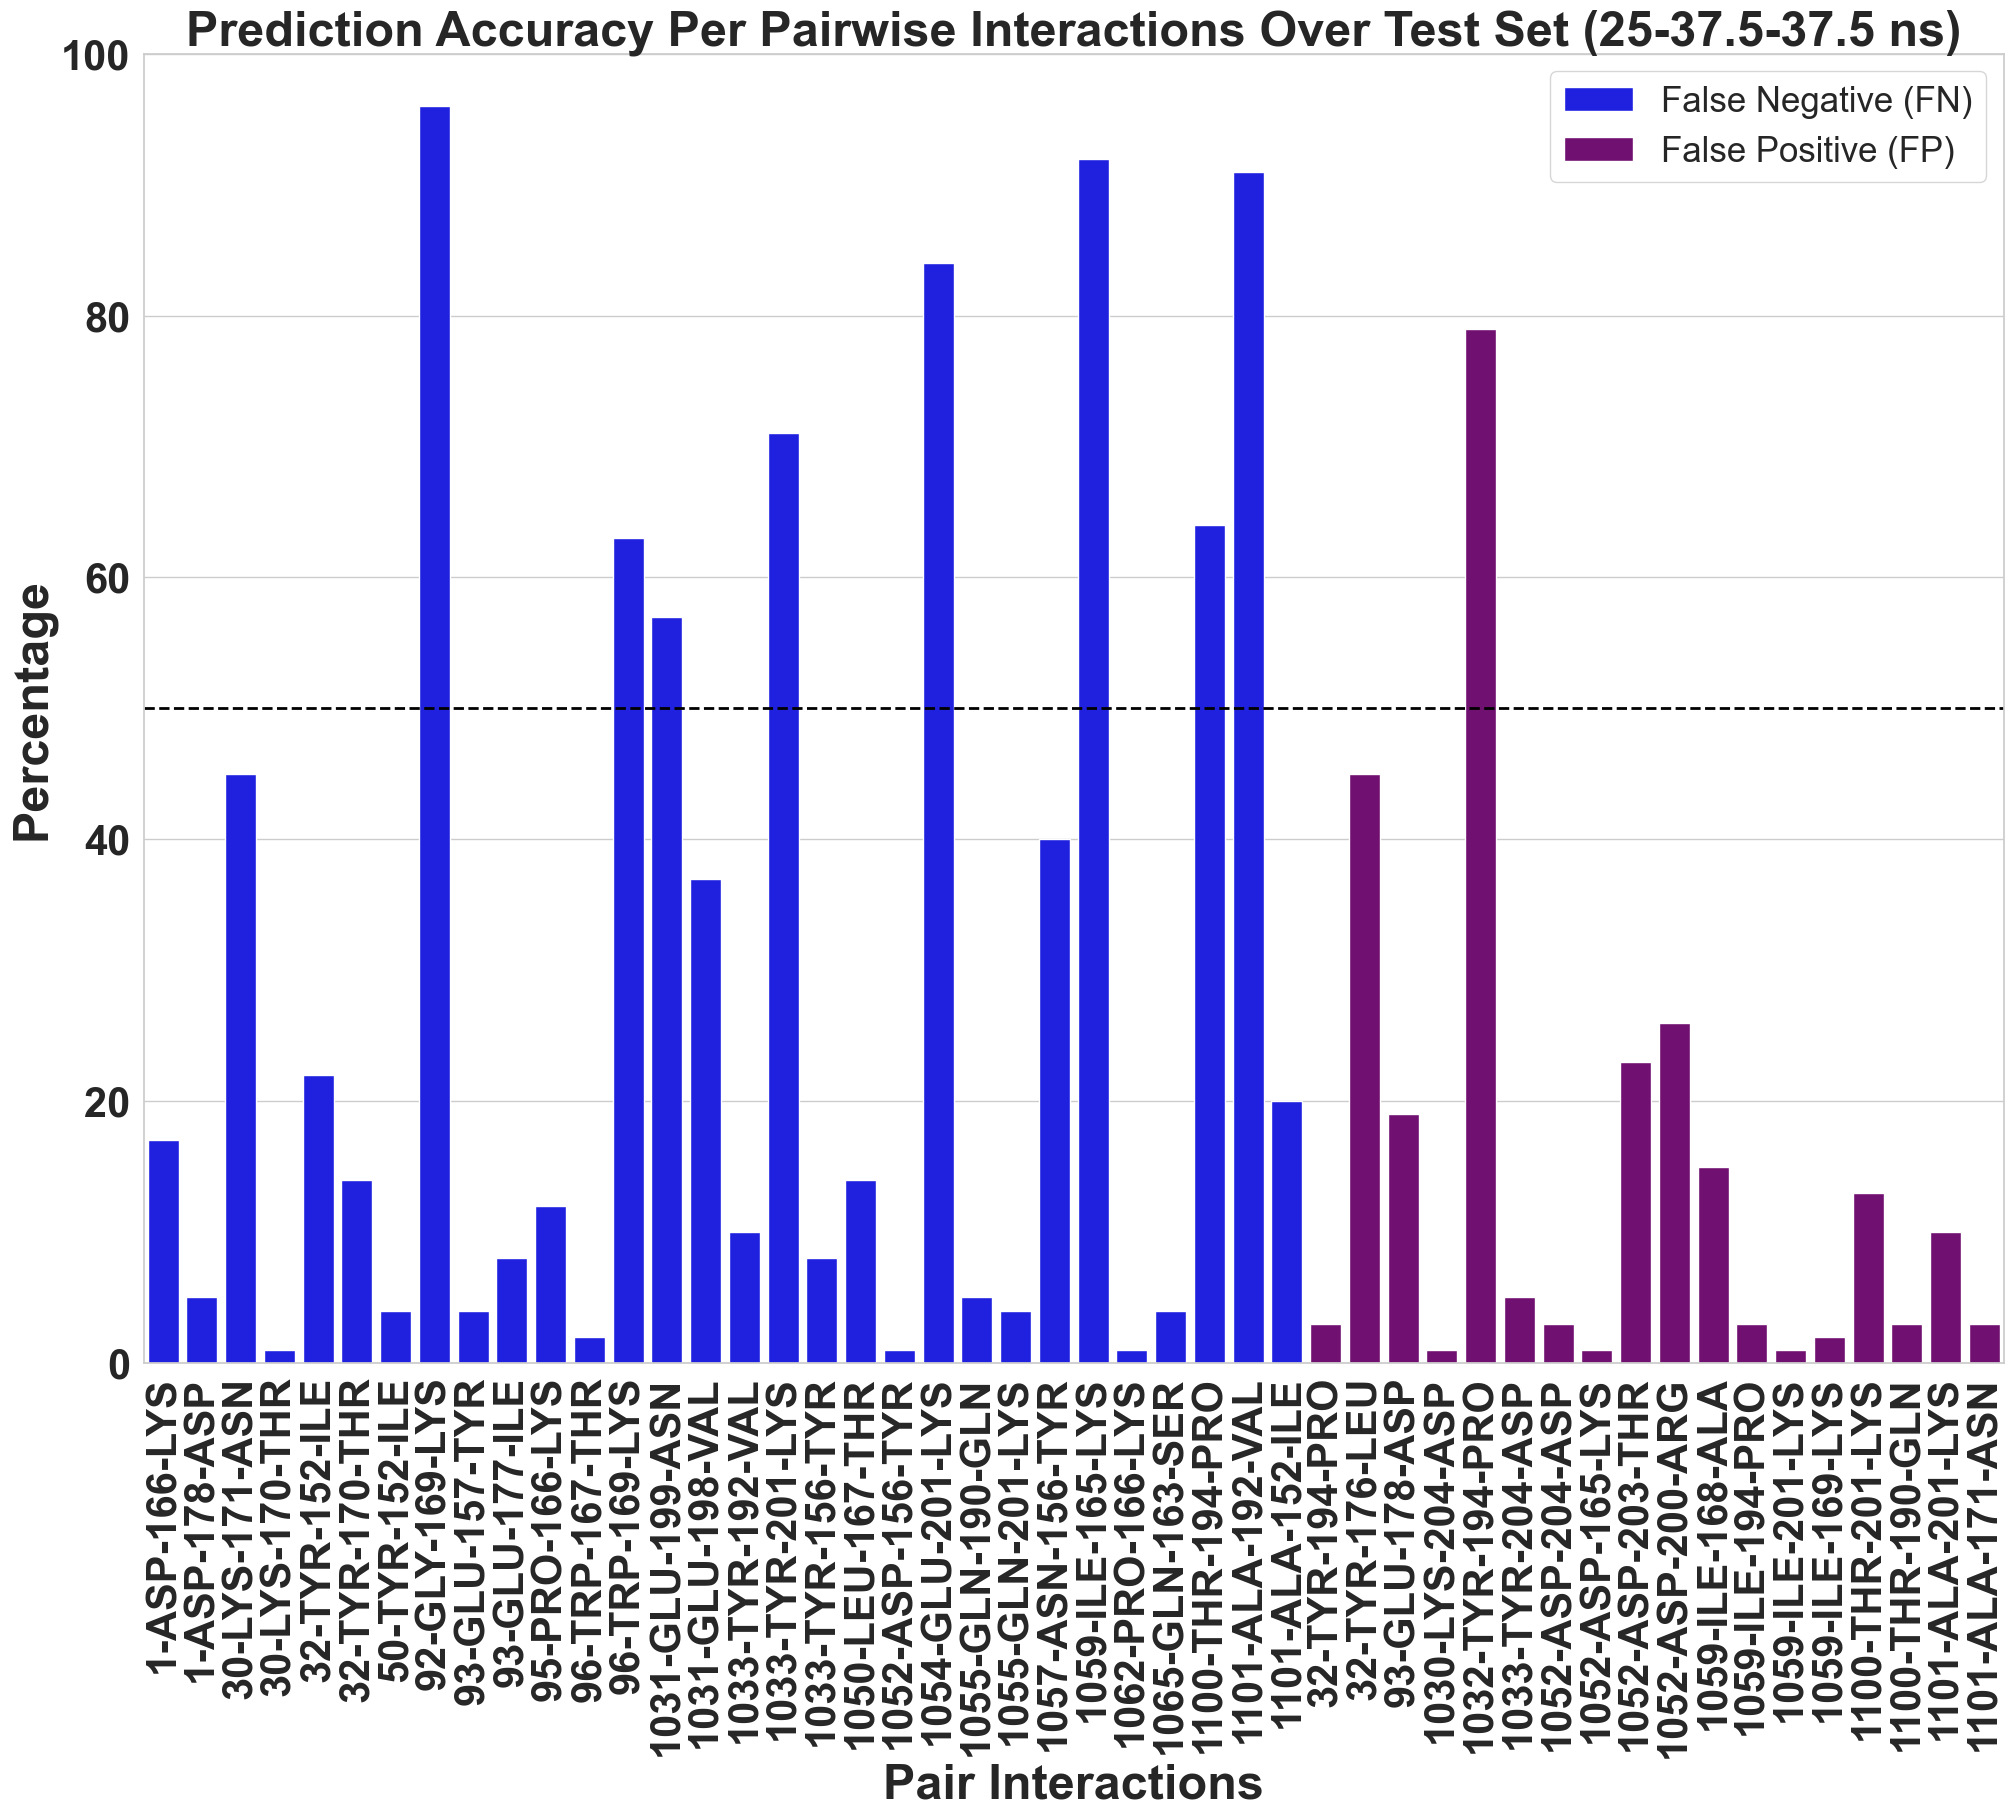

In [28]:
a = unique_rows_50_75_75.sort_values(by='pair')

unique_rows_50_75_75['numeric_order'] = unique_rows_50_75_75['pair'].apply(lambda x: int(x.split('-')[0]) if x.split('-')[0].isdigit() else float('inf'))
unique_rows_50_75_75 = unique_rows_50_75_75.sort_values(by='numeric_order')

## False Positive (FP) ve False Negative (FN) olarak veriyi ayır ve sırala
df_fp = unique_rows_50_75_75[unique_rows_50_75_75['label'] == 'False Positive (FP)'].sort_values(by='numeric_order')
df_fn = unique_rows_50_75_75[unique_rows_50_75_75['label'] == 'False Negative (FN)'].sort_values(by='numeric_order')

# False Positive (FP) ve False Negative (FN) verilerini birleştir
df_sorted = pd.concat([df_fn, df_fp])

sns.set(style="whitegrid")
custom_colors = {'False Negative (FN)': 'Blue', 'False Positive (FP)': 'Purple'}
plt.figure(figsize=(24, 17))
ax = sns.barplot(y='freq', x='pair', hue='label', data=df_sorted, dodge=False, palette=custom_colors)
plt.xlabel('Pair Interactions',size=35, weight="bold")
plt.ylabel('Percentage',size=35, weight="bold")
plt.yticks(fontweight='bold', fontsize=30)
plt.xticks(fontweight='bold', fontsize=30)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axhline(y=50, color='black', linestyle='--', linewidth=2)
plt.legend(fontsize='large')
ax.set_ylim(0, 100)
plt.legend(fontsize='25')
plt.title('Prediction Accuracy Per Pairwise Interactions Over Test Set (25-37.5-37.5 ns)',size=35, weight="bold")
plt.legend(fontsize='25')
plt.savefig('./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/graphs/Missings_50-75-75.png', dpi=300, bbox_inches='tight')


In [29]:
a = unique_rows_100_50_50.sort_values(by='pair')
fig = px.bar(a, x="freq", y="pair", color="label", height=850,width=1000)
fig.update_layout(coloraxis_showscale=False,template="plotly_white",title="<b>Missing interactions in both ground truth and prediction sets for 100-50-50</b>",title_x=0.5)
fig.update_xaxes(title_text='<b>Percentage</b>')
fig.update_yaxes(title_text='<b>Pair Interactions</b>')
fig_widget = go.FigureWidget(fig)

fig.write_image("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/graphs/Missing_bar_in_both_100-50-50.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'label=False Negative (FN)<br>freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': 'False Negative (FN)',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'False Negative (FN)',
              'offsetgroup': 'False Negative (FN)',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'uid': '865e32ff-fe5f-407f-8511-d5b206fa6f23',
              'x': array([25, 49, 80,  9, 70, 15, 82,  3,  5, 33, 90,  5, 52,  9, 78,  1, 52, 27,
                          19,  5, 94, 15,  1, 70]),
              'xaxis': 'x',
              'y': array(['1-ASP-166-LYS', '1031-GLU-198-VAL', '1031-GLU-199-ASN',
                          '1033-TYR-192-VAL', '1033-TYR-201-LYS', '1050-LEU-167-THR',
                          '1054-GLU-201-LYS', '1055-GLN-190-GLN', '1055-GLN-201-

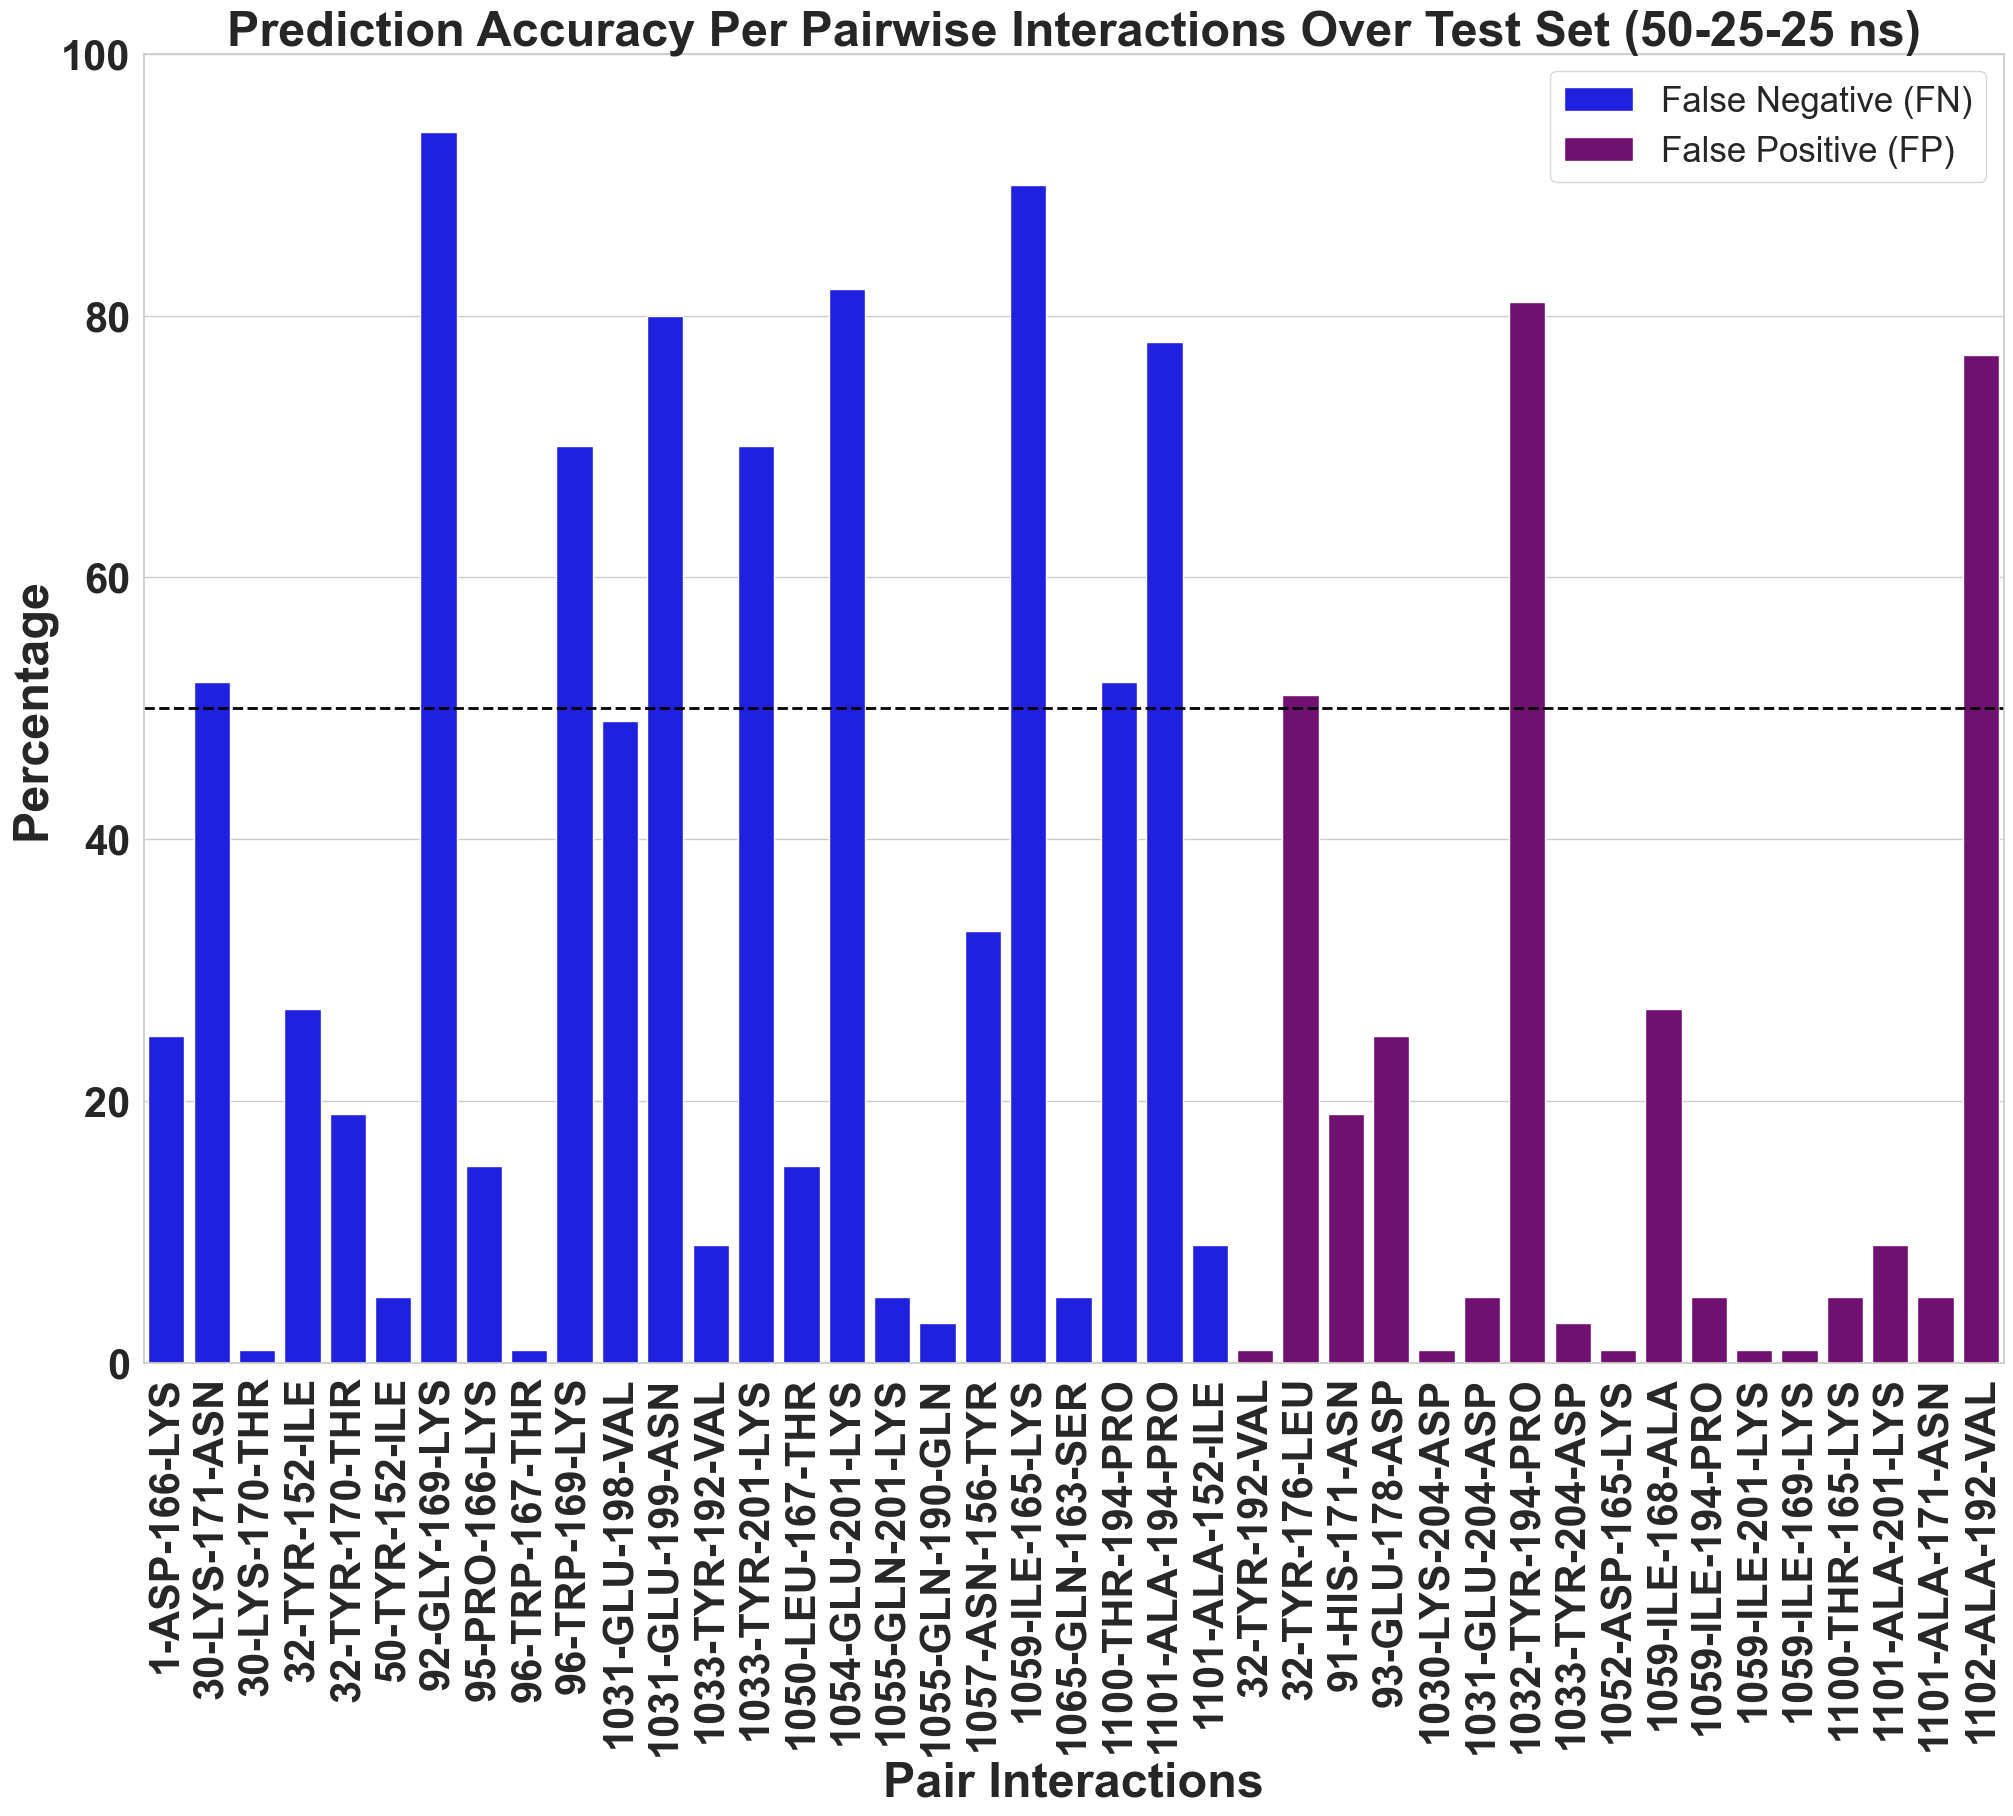

In [30]:
a = unique_rows_100_50_50.sort_values(by='pair')

unique_rows_100_50_50['numeric_order'] = unique_rows_100_50_50['pair'].apply(lambda x: int(x.split('-')[0]) if x.split('-')[0].isdigit() else float('inf'))
unique_rows_100_50_50 = unique_rows_100_50_50.sort_values(by='numeric_order')

## False Positive (FP) ve False Negative (FN) olarak veriyi ayır ve sırala
df_fp = unique_rows_100_50_50[unique_rows_100_50_50['label'] == 'False Positive (FP)'].sort_values(by='numeric_order')
df_fn = unique_rows_100_50_50[unique_rows_100_50_50['label'] == 'False Negative (FN)'].sort_values(by='numeric_order')

# False Positive (FP) ve False Negative (FN) verilerini birleştir
df_sorted = pd.concat([df_fn, df_fp])

sns.set(style="whitegrid")
custom_colors = {'False Negative (FN)': 'Blue', 'False Positive (FP)': 'Purple'}
plt.figure(figsize=(24, 17))
ax = sns.barplot(y='freq', x='pair', hue='label', data=df_sorted, dodge=False, palette=custom_colors)
plt.xlabel('Pair Interactions',size=35, weight="bold")
plt.ylabel('Percentage',size=35, weight="bold")
plt.xticks(fontweight='bold', fontsize=30)
plt.yticks(fontweight='bold', fontsize=30)
ax.axhline(y=50, color='black', linestyle='--', linewidth=2)
plt.legend(fontsize='large')
ax.set_ylim(0, 100)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Prediction Accuracy Per Pairwise Interactions Over Test Set (50-25-25 ns)',size=35, weight="bold")
plt.legend(fontsize='25')
plt.savefig('./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/graphs/Missings_100-50-50.png', dpi=300, bbox_inches='tight')


In [31]:
a = unique_rows_160_20_20.sort_values(by='pair')
fig = px.bar(a, x="freq", y="pair", color="label", height=850,width=1000)
fig.update_layout(coloraxis_showscale=False,template="plotly_white",title="<b>Missing interactions in both ground truth and prediction sets for 160-20-20</b>",title_x=0.5)
fig.update_xaxes(title_text='<b>Percentage</b>')
fig.update_yaxes(title_text='<b>Pairs</b>')
fig_widget = go.FigureWidget(fig)

fig.write_image("./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/graphs/Missing_bar_in_both_160_20_20.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'label=False Negative (FN)<br>freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': 'False Negative (FN)',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'False Negative (FN)',
              'offsetgroup': 'False Negative (FN)',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'uid': '1afc69e9-eb37-4989-8eeb-57331566e016',
              'x': array([ 43,  58,  84,   6,   1,  17,  74,   6,  11, 100,   1,  58,  17,  90,
                            1,  58,  27,  27, 100,  27,   1,  74]),
              'xaxis': 'x',
              'y': array(['1-ASP-166-LYS', '1031-GLU-198-VAL', '1031-GLU-199-ASN',
                          '1032-TYR-200-ARG', '1033-TYR-192-VAL', '1050-LEU-167-THR',
                          '1054-GLU-201-LYS', '1055-GLN-201-LYS', 

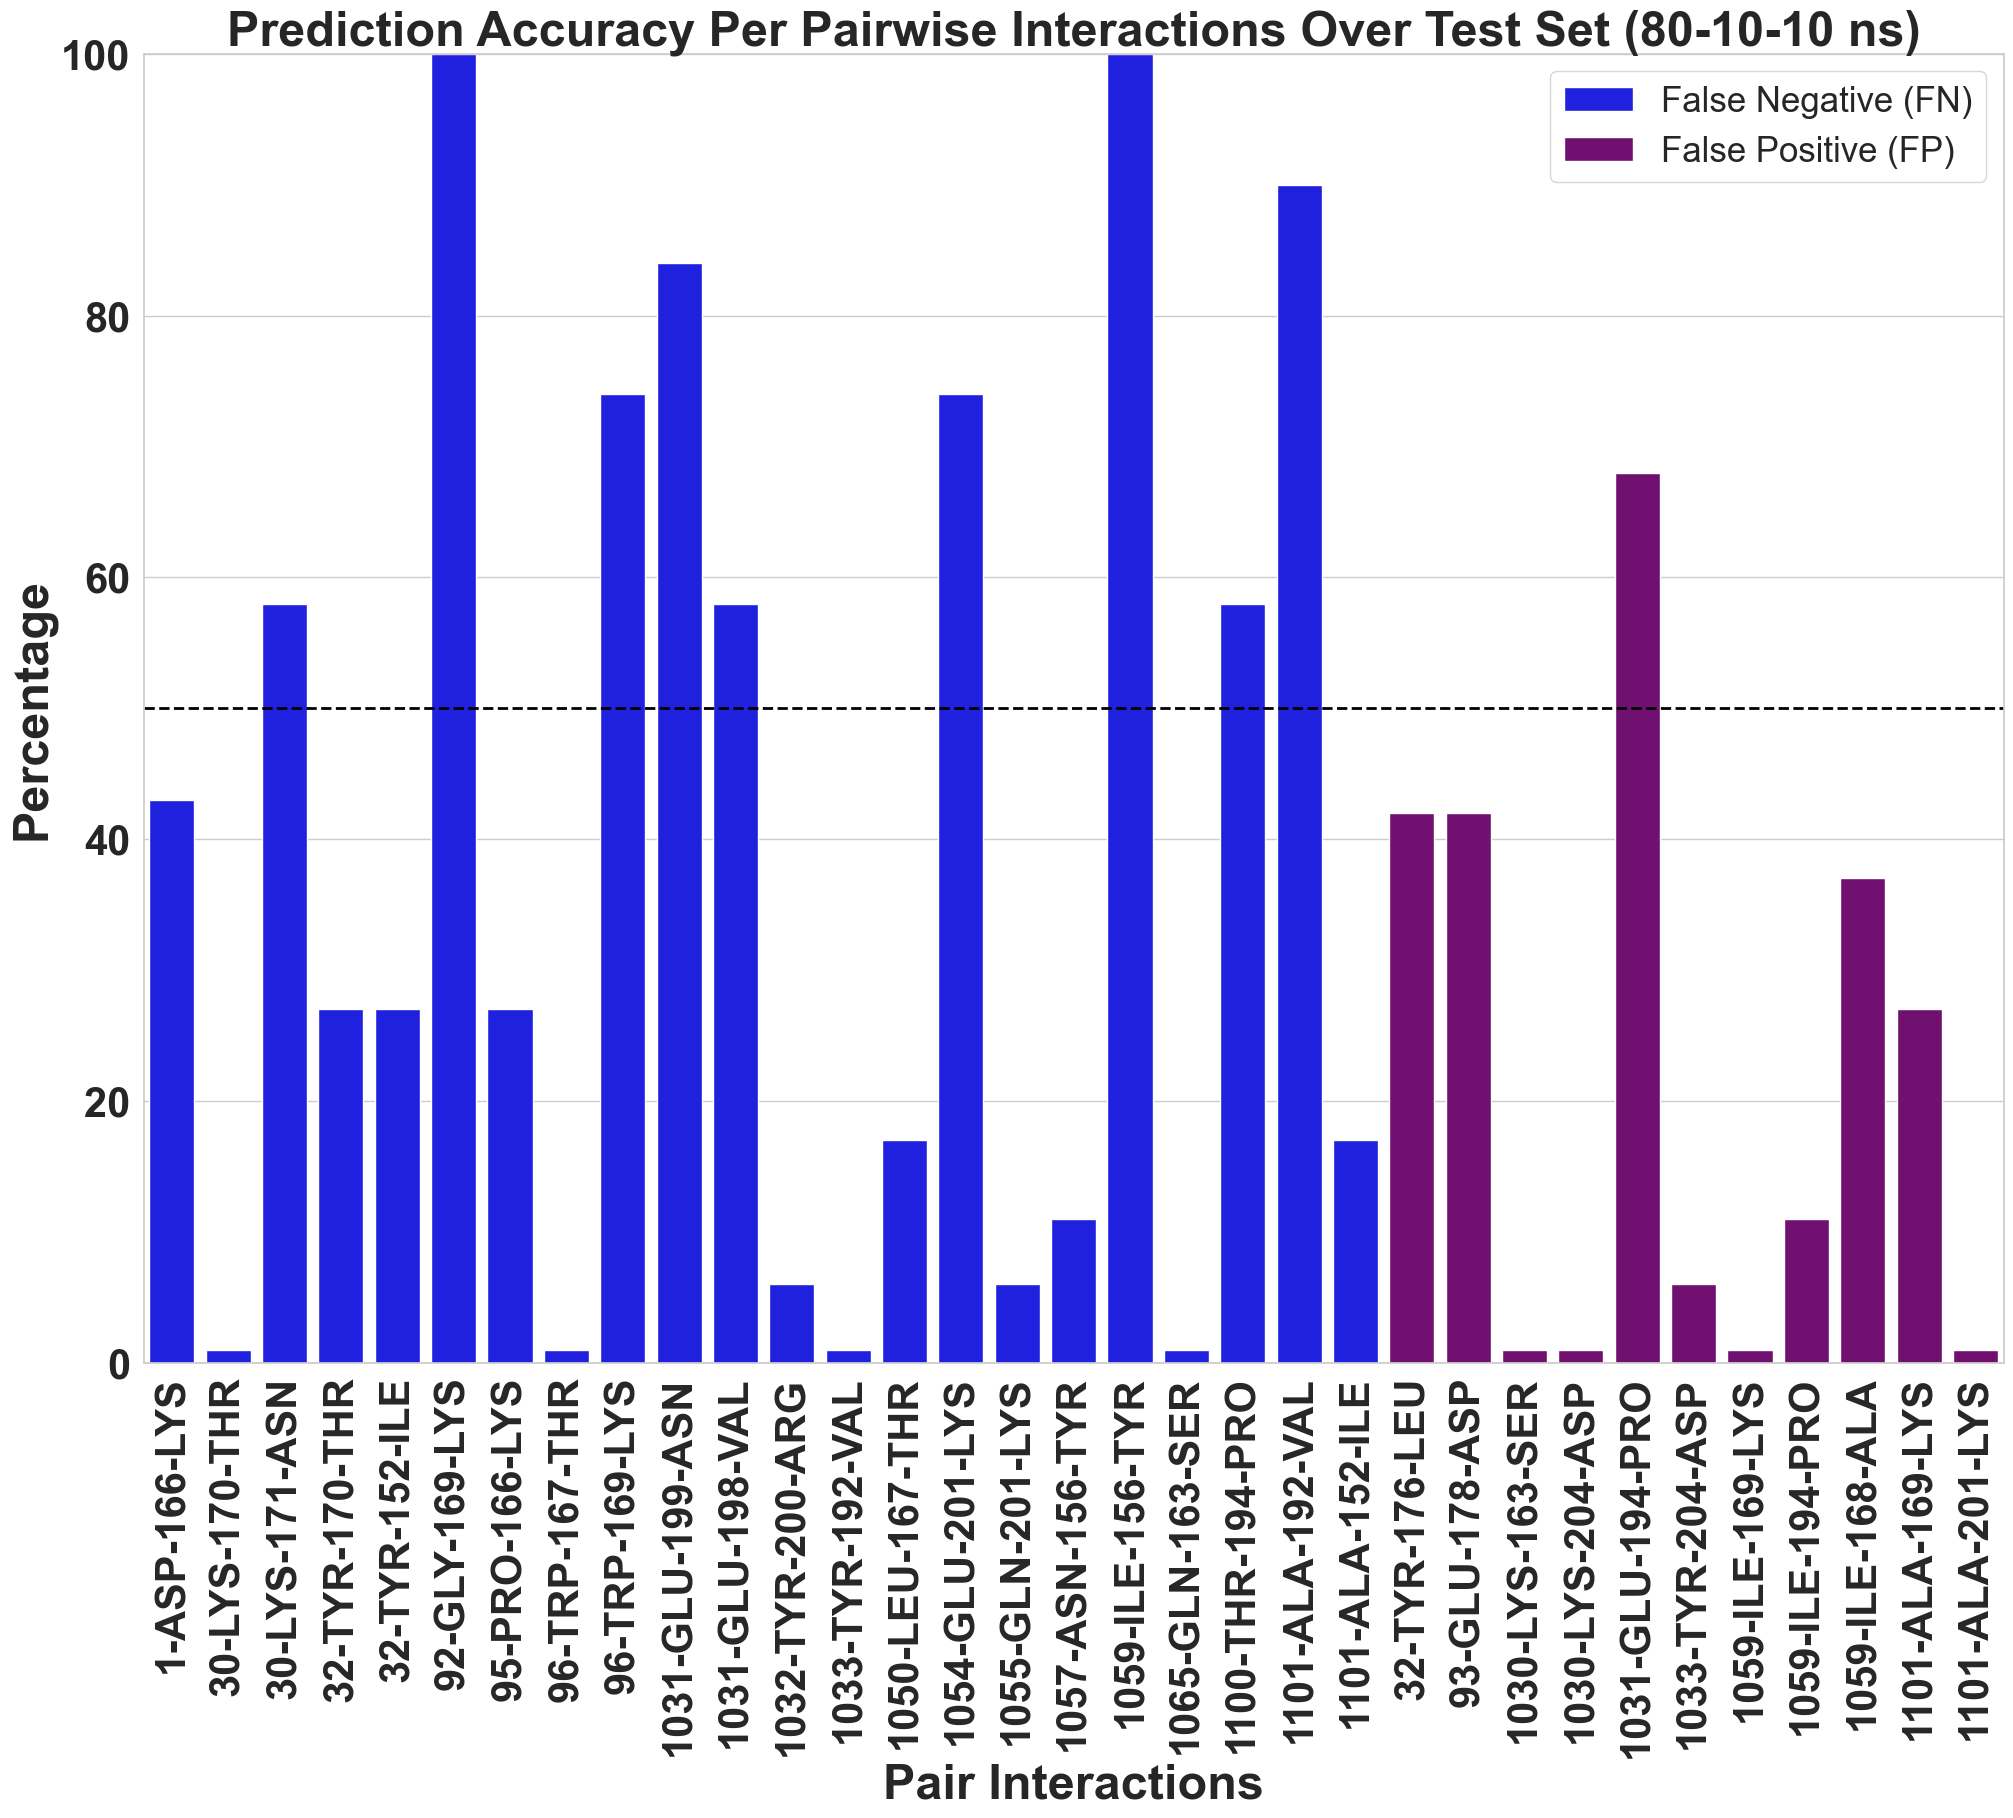

In [32]:
a = unique_rows_160_20_20.sort_values(by='pair')

unique_rows_160_20_20['numeric_order'] = unique_rows_160_20_20['pair'].apply(lambda x: int(x.split('-')[0]) if x.split('-')[0].isdigit() else float('inf'))
unique_rows_160_20_20 = unique_rows_160_20_20.sort_values(by='numeric_order')

## False Positive (FP) ve False Negative (FN) olarak veriyi ayır ve sırala
df_fp = unique_rows_160_20_20[unique_rows_160_20_20['label'] == 'False Positive (FP)'].sort_values(by='numeric_order')
df_fn = unique_rows_160_20_20[unique_rows_160_20_20['label'] == 'False Negative (FN)'].sort_values(by='numeric_order')

# False Positive (FP) ve False Negative (FN) verilerini birleştir
df_sorted = pd.concat([df_fn, df_fp])

sns.set(style="whitegrid")
custom_colors = {'False Negative (FN)': 'Blue', 'False Positive (FP)': 'Purple'}
plt.figure(figsize=(24, 17))
ax = sns.barplot(y='freq', x='pair', hue='label', data=df_sorted, dodge=False, palette=custom_colors)
plt.xlabel('Pair Interactions',size=35, weight="bold")
plt.ylabel('Percentage',size=35, weight="bold")
plt.xticks(fontweight='bold', fontsize=30)
plt.yticks(fontweight='bold', fontsize=30)
ax.axhline(y=50, color='black', linestyle='--', linewidth=2)
plt.legend(fontsize='large')
ax.set_ylim(0, 100)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Prediction Accuracy Per Pairwise Interactions Over Test Set (80-10-10 ns)',size=35, weight="bold")
plt.legend(fontsize='25')
plt.savefig('./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/graphs/Missings_160-20-20.png', dpi=300, bbox_inches='tight')


In [33]:
fig = px.bar(unique_rows_ground_truth_50_75_75, x="freq", y="pair", color="relation",title="Interactions in the ground truth set but not in the prediction set for 50-75-75", height=800,text_auto=True,hover_data=['relation', 'values'],
            facet_col="relation",color_discrete_map = {'H-bond': 'green', 'Hydrophobic': 'blue', 'Ionic': 'red', 
                                   'Predicted_Set': 'purple'})
fig.update_layout(coloraxis_showscale=False,template="plotly_white")
fig_widget = go.FigureWidget(fig)

fig.write_image("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/graphs/bar_in_ground_truth_50-75-75.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'customdata': array([['Hydrophobic', 3],
                                   ['Hydrophobic', 15],
                                   ['Hydrophobic', 1],
                                   ['Hydrophobic', 17],
                                   ['Hydrophobic', 3],
                                   ['Hydrophobic', 6],
                                   ['Hydrophobic', 2],
                                   ['Hydrophobic', 9],
                                   ['Hydrophobic', 2],
                                   ['Hydrophobic', 47],
                                   ['Hydrophobic', 37],
                                   ['Hydrophobic', 28],
                                   ['Hydrophobic', 8],
                                   ['Hydrophobic', 53],
                                   ['Hydrophobic', 11],
                                   ['Hydrophobic', 1],
                                   ['Hydrophobic', 18],
  

In [34]:
fig = px.bar(unique_rows_ground_truth_100_50_50, x="freq", y="pair", color="relation",title="Interactions in the ground truth set but not in the prediction set for 100-50-50", height=700,text_auto=True,hover_data=['relation', 'values'],
            facet_col="relation",color_discrete_map = {'H-bond': 'green', 'Hydrophobic': 'blue', 'Ionic': 'red', 
                                   'Predicted_Set': 'purple'})
fig.update_layout(coloraxis_showscale=False,template="plotly_white")
fig_widget = go.FigureWidget(fig)

fig.write_image("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/graphs/bar_in_ground_truth_100-50-50.svg")
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'customdata': array([['Ionic', 13],
                                   ['Ionic', 41]], dtype=object),
              'hovertemplate': ('relation=%{customdata[0]}<br>f' ... '{customdata[1]}<extra></extra>'),
              'legendgroup': 'Ionic',
              'marker': {'color': 'red', 'pattern': {'shape': ''}},
              'name': 'Ionic',
              'offsetgroup': 'Ionic',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'texttemplate': '%{x}',
              'type': 'bar',
              'uid': 'a35b343f-7218-4e13-94dc-c6b4a1ce408f',
              'x': array([25, 81]),
              'xaxis': 'x',
              'y': array(['1-ASP-166-LYS', '1054-GLU-201-LYS'], dtype=object),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'customdata': array([['Hydrophobic', 3],
                                   ['Hydrophobic'

In [35]:
fig = px.bar(unique_rows_filtered_df_160_20_20_sorted, x="freq", y="pair", height=800,width=1000)
fig.update_layout(template="plotly_white",title_text="<b>Interactions in the ground truth set but not in the prediction set for 160-20-20</b>",title_x=0.5)
fig.update_xaxes(title_text='<b>Percentage</b>')
fig.update_yaxes(title_text='<b>Pairs</b>')
fig_widget = go.FigureWidget(fig)
fig.write_image("./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/graphs/bar_in_ground_truth_160-20-20.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'h',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'uid': '02b222b0-bb7c-4231-81f9-7a804ee35bac',
              'x': array([ 43,   1,  58,  27,  27, 100,  27,   1,  74,  84,  58,   6,   1,  17,
                           74,   6,  11, 100,   1,  58,  90,  17]),
              'xaxis': 'x',
              'y': array(['1-ASP-166-LYS', '30-LYS-170-THR', '30-LYS-171-ASN', '32-TYR-152-ILE',
                          '32-TYR-170-THR', '92-GLY-169-LYS', '95-PRO-166-LYS', '96-TRP-167-THR',
                          '96-TRP-169-LYS', '1031-GLU-199-ASN', '1031-GLU-198-VAL',
                          '1032-TYR-200-A

In [36]:
fig = px.bar(unique_rows_filtered_df_100_50_50_sorted, x="freq", y="pair", height=800,width=1000)
fig.update_layout(template="plotly_white",title_text="<b>Interactions in the ground truth set but not in the prediction set for 100-50-50</b>",title_x=0.5)
fig.update_xaxes(title_text='<b>Percentage</b>')
fig.update_yaxes(title_text='<b>Pairs</b>')
fig_widget = go.FigureWidget(fig)
fig.write_image("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/graphs/bar_in_ground_truth_100-50-50.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'h',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'uid': '5aa024c1-1eca-4b49-81e2-28997d3f107e',
              'x': array([25, 49, 80,  9, 70, 15, 82,  5,  3, 33, 90,  5, 52,  9, 78,  1, 52, 19,
                          27,  5, 94, 15, 70,  1]),
              'xaxis': 'x',
              'y': array(['1-ASP-166-LYS', '1031-GLU-198-VAL', '1031-GLU-199-ASN',
                          '1033-TYR-192-VAL', '1033-TYR-201-LYS', '1050-LEU-167-THR',
                          '1054-GLU-201-LYS', '1055-GLN-201-LYS', '1055-GLN-190-GLN',
                          '1057-ASN-156-TYR', '1059-ILE-165-LYS', '1065-GLN-163

In [37]:
fig = px.bar(unique_rows_filtered_df_50_75_75_sorted, x="freq", y="pair", height=800,width=1000)
fig.update_layout(template="plotly_white",title_text="<b>Interactions in the ground truth set but not in the prediction set for 50-75-75</b>",title_x=0.5)
fig.update_xaxes(title_text='<b>Percentage</b>')
fig.update_yaxes(title_text='<b>Pairs</b>')
fig_widget = go.FigureWidget(fig)
fig.write_image("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/graphs/bar_in_ground_truth_50-75-75.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'h',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'uid': 'a395301a-1d1b-4283-86bc-31f71d569ed5',
              'x': array([17,  5, 37, 57,  8, 71, 10, 14,  1, 84,  5,  4, 40, 92,  1,  4, 64, 20,
                          91,  1, 45, 14, 22,  4, 96,  8,  4, 12,  2, 63]),
              'xaxis': 'x',
              'y': array(['1-ASP-166-LYS', '1-ASP-178-ASP', '1031-GLU-198-VAL',
                          '1031-GLU-199-ASN', '1033-TYR-156-TYR', '1033-TYR-201-LYS',
                          '1033-TYR-192-VAL', '1050-LEU-167-THR', '1052-ASP-156-TYR',
                          '1054-GLU-201-LYS', '1055-GLN-19

In [38]:
fig = px.bar(unique_rows_predicted_50_75_75, x="freq", y="pair", height=800,width=1000)
fig.update_layout(xaxis_range=[0,100],yaxis={'categoryorder':'category ascending'},coloraxis_showscale=False,template="plotly_white",title_text="<b>Interactions in the predicted set but not in the ground truth for 50-75-75</b>",title_x=0.5)
fig.update_traces(marker_color="purple")
fig.update_xaxes(title_text='<b>Percentage</b>')
fig.update_yaxes(title_text='<b>Pairs</b>')
fig_widget = go.FigureWidget(fig)
fig.write_image("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/graphs/bar_in_predicted_50-75-75.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': 'purple', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'h',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'uid': 'c72316a5-6802-4c09-8222-542fb66c1e89',
              'x': array([45,  3, 19,  1, 79,  5, 23, 26,  1,  3, 15,  3,  1,  2,  3, 13, 10,  3]),
              'xaxis': 'x',
              'y': array(['32-TYR-176-LEU', '32-TYR-194-PRO', '93-GLU-178-ASP',
                          '1030-LYS-204-ASP', '1032-TYR-194-PRO', '1033-TYR-204-ASP',
                          '1052-ASP-203-THR', '1052-ASP-200-ARG', '1052-ASP-165-LYS',
                          '1052-ASP-204-ASP', '1059-ILE-168-ALA', '1059-ILE-194-PRO',
                          '1059-ILE-201-LYS', '

In [39]:
fig = px.bar(unique_rows_predicted_100_50_50, x="freq", y="pair", height=800,width=1000)
fig.update_layout(xaxis_range=[0,100],yaxis={'categoryorder':'category ascending'},coloraxis_showscale=False,template="plotly_white",title_text="<b>Interactions in the predicted set but not in the ground truth for 100-50-50</b>",title_x=0.5)
fig.update_traces(marker_color="purple")
fig.update_xaxes(title_text='<b>Percentage</b>')
fig.update_yaxes(title_text='<b>Pairs</b>')
fig_widget = go.FigureWidget(fig)

fig.write_image("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/graphs/bar_in_predicted_100-50-50.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': 'purple', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'h',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'uid': '58159d22-f163-4138-b2d6-7330babdae26',
              'x': array([51,  1, 19, 25,  1,  5, 81,  3,  1, 27,  5,  1,  1,  5,  9,  5, 77]),
              'xaxis': 'x',
              'y': array(['32-TYR-176-LEU', '32-TYR-192-VAL', '91-HIS-171-ASN', '93-GLU-178-ASP',
                          '1030-LYS-204-ASP', '1031-GLU-204-ASP', '1032-TYR-194-PRO',
                          '1033-TYR-204-ASP', '1052-ASP-165-LYS', '1059-ILE-168-ALA',
                          '1059-ILE-194-PRO', '1059-ILE-201-LYS', '1059-ILE-169-LYS',
                          '1100-T

In [40]:
fig = px.bar(unique_rows_predicted_160_20_20, x="freq", y="pair", height=800,width=1000)
fig.update_layout(xaxis_range=[0,100],yaxis={'categoryorder':'category ascending'},coloraxis_showscale=False,template="plotly_white",title="<b>Interactions in the predicted set but not in the ground truth for 160-20-20</b>",title_x=0.5)
fig.update_traces(marker_color="purple")
fig.update_xaxes(title_text='<b>Percentage</b>')
fig.update_yaxes(title_text='<b>Pairs</b>')
fig_widget = go.FigureWidget(fig)

fig.write_image("./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/graphs/bar_in_predicted_160-20-20.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': 'purple', 'pattern': {'shape': ''}},
              'name': '',
              'offsetgroup': '',
              'orientation': 'h',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'uid': '579a3474-54fb-4001-8d70-2b3b77cb8a50',
              'x': array([42, 42,  1,  1, 68,  6,  1, 11, 37, 27,  1]),
              'xaxis': 'x',
              'y': array(['32-TYR-176-LEU', '93-GLU-178-ASP', '1030-LYS-163-SER',
                          '1030-LYS-204-ASP', '1031-GLU-194-PRO', '1033-TYR-204-ASP',
                          '1059-ILE-169-LYS', '1059-ILE-194-PRO', '1059-ILE-168-ALA',
                          '1101-ALA-169-LYS', '1101-ALA-201-LYS'], dtype=object),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
         

In [41]:
fig = px.bar(merged_df_50_75_75, x="freq", y="pair", color="relation", title="<b>The last 75 ns interactions in the predicted set and in the ground truth for 50-75-75</b>", height=1500,width=1000,
            facet_col="relation",color_discrete_map = {'H-bond': 'green', 'Hydrophobic': 'blue', 'Ionic': 'red', 
                                   'Predicted_Set': 'purple'})
fig.update_layout(yaxis={'categoryorder':'category ascending'},coloraxis_showscale=False,template="plotly_white")
fig_widget = go.FigureWidget(fig)
fig.write_image("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/graphs/bar_all_50-75-75.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'relation=Hydrophobic<br>freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': 'Hydrophobic',
              'marker': {'color': 'blue', 'pattern': {'shape': ''}},
              'name': 'Hydrophobic',
              'offsetgroup': 'Hydrophobic',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'uid': 'ddcc8483-2d9a-4ff3-90a7-8e5632037d4c',
              'x': array([ 3, 19,  1, 22, 62, 97,  3,  7, 85,  2, 15, 11,  2, 62, 26, 49, 37, 43,
                          10, 70, 14, 78,  1, 23,  5,  3,  3, 39, 49, 54, 85, 95, 91,  1, 79, 62,
                          90,  3, 74, 19, 81]),
              'xaxis': 'x',
              'y': array(['1-ASP-166-LYS', '30-LYS-171-ASN', '30-LYS-170-THR', '32-TYR-152-ILE',
                          '32-TYR-171-ASN', '32-TYR-169-LYS', '50-TYR-152-ILE', '93-GLU-17

In [42]:
fig = px.bar(merged_df_100_50_50, x="freq", y="pair", color="relation", title="<b>The last 50 ns interactions in the predicted set and in the ground truth for 100-50-50</b>",height=1500,width=1000,
            facet_col="relation",color_discrete_map = {'H-bond': 'green', 'Hydrophobic': 'blue', 'Ionic': 'red', 
                                   'Predicted_Set': 'purple'})
fig.update_layout(yaxis={'categoryorder':'category ascending'},coloraxis_showscale=False,template="plotly_white")
fig_widget = go.FigureWidget(fig)

fig.write_image("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/graphs/bar_all_100-50-50.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'relation=Ionic<br>freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': 'Ionic',
              'marker': {'color': 'red', 'pattern': {'shape': ''}},
              'name': 'Ionic',
              'offsetgroup': 'Ionic',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'uid': '8c66ef53-d8bb-41b4-b858-469be0775046',
              'x': array([25, 27, 27, 51, 93, 81]),
              'xaxis': 'x',
              'y': array(['1-ASP-166-LYS', '27-ARG-178-ASP', '93-GLU-166-LYS', '1031-GLU-200-ARG',
                          '1052-ASP-201-LYS', '1054-GLU-201-LYS'], dtype=object),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'hovertemplate': 'relation=Hydrophobic<br>freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': 'Hydrophobic',
              

In [43]:
fig = px.bar(merged_df_160_20_20, x="freq", y="pair", color="relation", title="<b>The last 20 ns interactions in the predicted set and in the ground truth for 160-20-20</b>", height=1500,width=1000,
            facet_col="relation",color_discrete_map = {'H-bond': 'green', 'Hydrophobic': 'blue', 'Ionic': 'red', 
                                   'Predicted_Set': 'purple'})
fig.update_layout(yaxis={'categoryorder':'category ascending'},coloraxis_showscale=False,template="plotly_white")
fig_widget = go.FigureWidget(fig)

fig.write_image("./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/graphs/bar_all_160-20-20.png",scale=6)
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'relation=Hydrophobic<br>freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': 'Hydrophobic',
              'marker': {'color': 'blue', 'pattern': {'shape': ''}},
              'name': 'Hydrophobic',
              'offsetgroup': 'Hydrophobic',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'uid': 'e23057c6-61a8-4026-9d37-6e4617a6f6d5',
              'x': array([ 11,  42,   1, 100,  63,  27,  37,  79,   1,  27,  73,   1,  58,  68,
                           79,  73,  58,   1,  16,  58,  16,   6,  11,  11,  47,  47,  84,  94,
                          100,  68,  53,  79,  89,  16,  79]),
              'xaxis': 'x',
              'y': array(['1-ASP-166-LYS', '30-LYS-171-ASN', '30-LYS-170-THR', '32-TYR-169-LYS',
                          '32-TYR-171-ASN', '32-TYR-152-ILE', '93-GLU-166-LYS',

In [44]:
df2 = unique_rows_predicted_50_75_75[unique_rows_predicted_50_75_75['pair'].isin(unique_rows_predicted_100_50_50['pair'])]
common_unique_predicted_list = df2[df2['pair'].isin(unique_rows_predicted_160_20_20['pair'])]
common_unique_predicted_list.to_excel("tables/unique_values_not_in_ground_truth.xlsx", index=False)
common_unique_predicted_list

residue_a residue_b  values              pair  freq                label
0     32-TYR   176-LEU      34    32-TYR-176-LEU    45  False Positive (FP)
31    93-GLU   178-ASP      15    93-GLU-178-ASP    19  False Positive (FP)
14  1030-LYS   204-ASP       1  1030-LYS-204-ASP     1  False Positive (FP)
12  1033-TYR   204-ASP       4  1033-TYR-204-ASP     5  False Positive (FP)
22  1059-ILE   168-ALA      12  1059-ILE-168-ALA    15  False Positive (FP)
6   1059-ILE   194-PRO       3  1059-ILE-194-PRO     3  False Positive (FP)
38  1059-ILE   169-LYS       2  1059-ILE-169-LYS     2  False Positive (FP)
30  1101-ALA   201-LYS       8  1101-ALA-201-LYS    10  False Positive (FP)

In [45]:
df3 = unique_rows_ground_truth_50_75_75[unique_rows_ground_truth_50_75_75['pair'].isin(unique_rows_filtered_df_100_50_50_sorted['pair'])]
common_nonpredicted_ground_truth = df3[df3['pair'].isin(unique_rows_ground_truth_160_20_20['pair'])]
common_nonpredicted_ground_truth.to_excel("tables/unpredictable_ground_truth.xlsx", index=False)

df4 = unique_rows_filtered_df_50_75_75_sorted[unique_rows_filtered_df_50_75_75_sorted['pair'].isin(unique_rows_filtered_df_100_50_50_sorted['pair'])]
common_nonpredicted_ground_truth_filtered = df4[df4['pair'].isin(unique_rows_filtered_df_160_20_20_sorted['pair'])]
common_nonpredicted_ground_truth.to_excel("tables/unpredictable_ground_truth.xlsx", index=False)
common_nonpredicted_ground_truth_filtered

common_interactions = pd.concat([common_nonpredicted_ground_truth_filtered, common_unique_predicted_list],axis=0)
common_interactions

residue_a residue_b  values              pair  freq                label
31     1-ASP   166-LYS      13     1-ASP-166-LYS    17  False Negative (FN)
51  1031-GLU   198-VAL      28  1031-GLU-198-VAL    37  False Negative (FN)
33  1031-GLU   199-ASN      43  1031-GLU-199-ASN    57  False Negative (FN)
39  1033-TYR   192-VAL       8  1033-TYR-192-VAL    10  False Negative (FN)
15  1050-LEU   167-THR      11  1050-LEU-167-THR    14  False Negative (FN)
18  1054-GLU   201-LYS      63  1054-GLU-201-LYS    84  False Negative (FN)
25  1055-GLN   201-LYS       3  1055-GLN-201-LYS     4  False Negative (FN)
43  1057-ASN   156-TYR      30  1057-ASN-156-TYR    40  False Negative (FN)
26  1065-GLN   163-SER       3  1065-GLN-163-SER     4  False Negative (FN)
46  1100-THR   194-PRO      48  1100-THR-194-PRO    64  False Negative (FN)
7   1101-ALA   152-ILE      15  1101-ALA-152-ILE    20  False Negative (FN)
16    30-LYS   170-THR       1    30-LYS-170-THR     1  False Negative (FN)
12    30-LYS   171-ASN      34    30-LYS-171-ASN    45  False Negative (FN)
47    32-TYR   170-THR      11    32-TYR-170-THR    14  False Negative (FN)
36    32-TYR   152-ILE      17    32-TYR-152-ILE    22  False Negative (FN)
52    92-GLY   169-LYS      72    92-GLY-169-LYS    96  False Negative (FN)
29    95-PRO   166-LYS       9    95-PRO-166-LYS    12  False Negative (FN)
22    96-TRP   167-THR       2    96-TRP-167-THR     2  False Negative (FN)
30    96-TRP   169-LYS      47    96-TRP-169-LYS    63  False Negative (FN)
0     32-TYR   176-LEU      34    32-TYR-176-LEU    45  False Positive (FP)
31    93-GLU   178-ASP      15    93-GLU-178-ASP    19  False Positive (FP)
14  1030-LYS   204-ASP       1  1030-LYS-204-ASP     1  False Positive (FP)
12  1033-TYR   204-ASP       4  1033-TYR-204-ASP     5  False Positive (FP)
22  1059-ILE   168-ALA      12  1059-ILE-168-ALA    15  False Positive (FP)
6   1059-ILE   194-PRO       3  1059-ILE-194-PRO     3  False Positive (FP)
38  1059-ILE   169-LYS       2  1059-ILE-169-LYS     2  False Positive (FP)
30  1101-ALA   201-LYS       8  1101-ALA-201-LYS    10  False Positive (FP)

In [46]:
fig = px.bar(common_nonpredicted_ground_truth, x="freq", y="pair", color="relation", title="Missing Ground Truth Interactions", height=800,text_auto=True,color_discrete_map = {'H-bond': 'green', 'Hydrophobic': 'blue', 'Ionic': 'red', 
                                   'Predicted_Set': 'purple'})
fig.update_layout(yaxis={'categoryorder':'category ascending'},coloraxis_showscale=False,template="plotly_white")
fig_widget = go.FigureWidget(fig)
fig.write_image("plots/nonpredicted_ground_truths.svg")
fig_widget

FigureWidget({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'relation=Hydrophobic<br>freq=%{x}<br>pair=%{y}<extra></extra>',
              'legendgroup': 'Hydrophobic',
              'marker': {'color': 'blue', 'pattern': {'shape': ''}},
              'name': 'Hydrophobic',
              'offsetgroup': 'Hydrophobic',
              'orientation': 'h',
              'showlegend': True,
              'textposition': 'auto',
              'texttemplate': '%{x}',
              'type': 'bar',
              'uid': 'aaa76418-30ef-4fa8-a431-5b1a4943ca10',
              'x': array([ 3, 19,  1, 22, 11,  2, 62, 49, 37, 10, 14, 23,  3, 39, 62, 19]),
              'xaxis': 'x',
              'y': array(['1-ASP-166-LYS', '30-LYS-171-ASN', '30-LYS-170-THR', '32-TYR-152-ILE',
                          '95-PRO-166-LYS', '96-TRP-167-THR', '96-TRP-169-LYS',
                          '1031-GLU-199-ASN', '1031-GLU-198-VAL', '1033-TYR-192-VAL',
                          '1050-LEU-16

In [48]:
fig = px.histogram(common_nonpredicted_ground_truth_filtered, x="values",y='pair')
fig.update_layout(height=600,xaxis_range=[0,100],template="plotly_white",
                  title="<b>Bar for all pair interactions in nonpredicted ground truths</b>",title_x=0.5)
fig.update_xaxes(title_text='<b>Sum of Values</b>')
fig.update_yaxes(title_text='<b>Pairs</b>')
fig.update_traces(marker_color="#0074D9")
fig.write_image("plots/nonpredicted_bar_all_interactions.svg")
fig.show()

In [49]:
fig = px.histogram(common_nonpredicted_ground_truth, x="values",y='residue_a')
fig.update_layout(height=600,xaxis_range=[0,120],template="plotly_white",
                  title="Bar for pair interactions of heavy and light chains in nonpredicted ground truths")
fig.update_xaxes(title_text='<b>Percentage</b>')
fig.update_yaxes(title_text='<b>Pairs</b>')
fig.update_traces(marker_color="#0074D9")
fig.write_image("plots/nonpredicted_bar_chain_A_interactions.svg")
fig.show()


In [50]:
fig = px.histogram(common_nonpredicted_ground_truth, x="values",y='residue_b')
fig.update_layout(height=600,xaxis_range=[0,120],template="plotly_white",
                  title="Bar for pair interactions of tissue factor chain in nonpredicted ground truths",
                 yaxis_title="tissue factor chain")
fig.update_traces(marker_color="#0074D9")
fig.write_image("plots/nonpredicted_bar_chain_C_interactions.svg")
fig.show()


In [51]:
fig = px.histogram(common_interactions, x="freq",y='pair',color="label")
fig.update_layout(height=600,xaxis_range=[0,100],template="plotly_white",width=1000,
                  title="<b>Common interactions between the ground truth and predicted sets are missing in all splitting rules.</b>",title_x=0.5)
fig.update_xaxes(title_text='<b>Sum of Values</b>')
fig.update_yaxes(title_text='<b>Pairs</b>')
fig.write_image("plots/common_missing_interactions.png",scale=6)
fig.show()

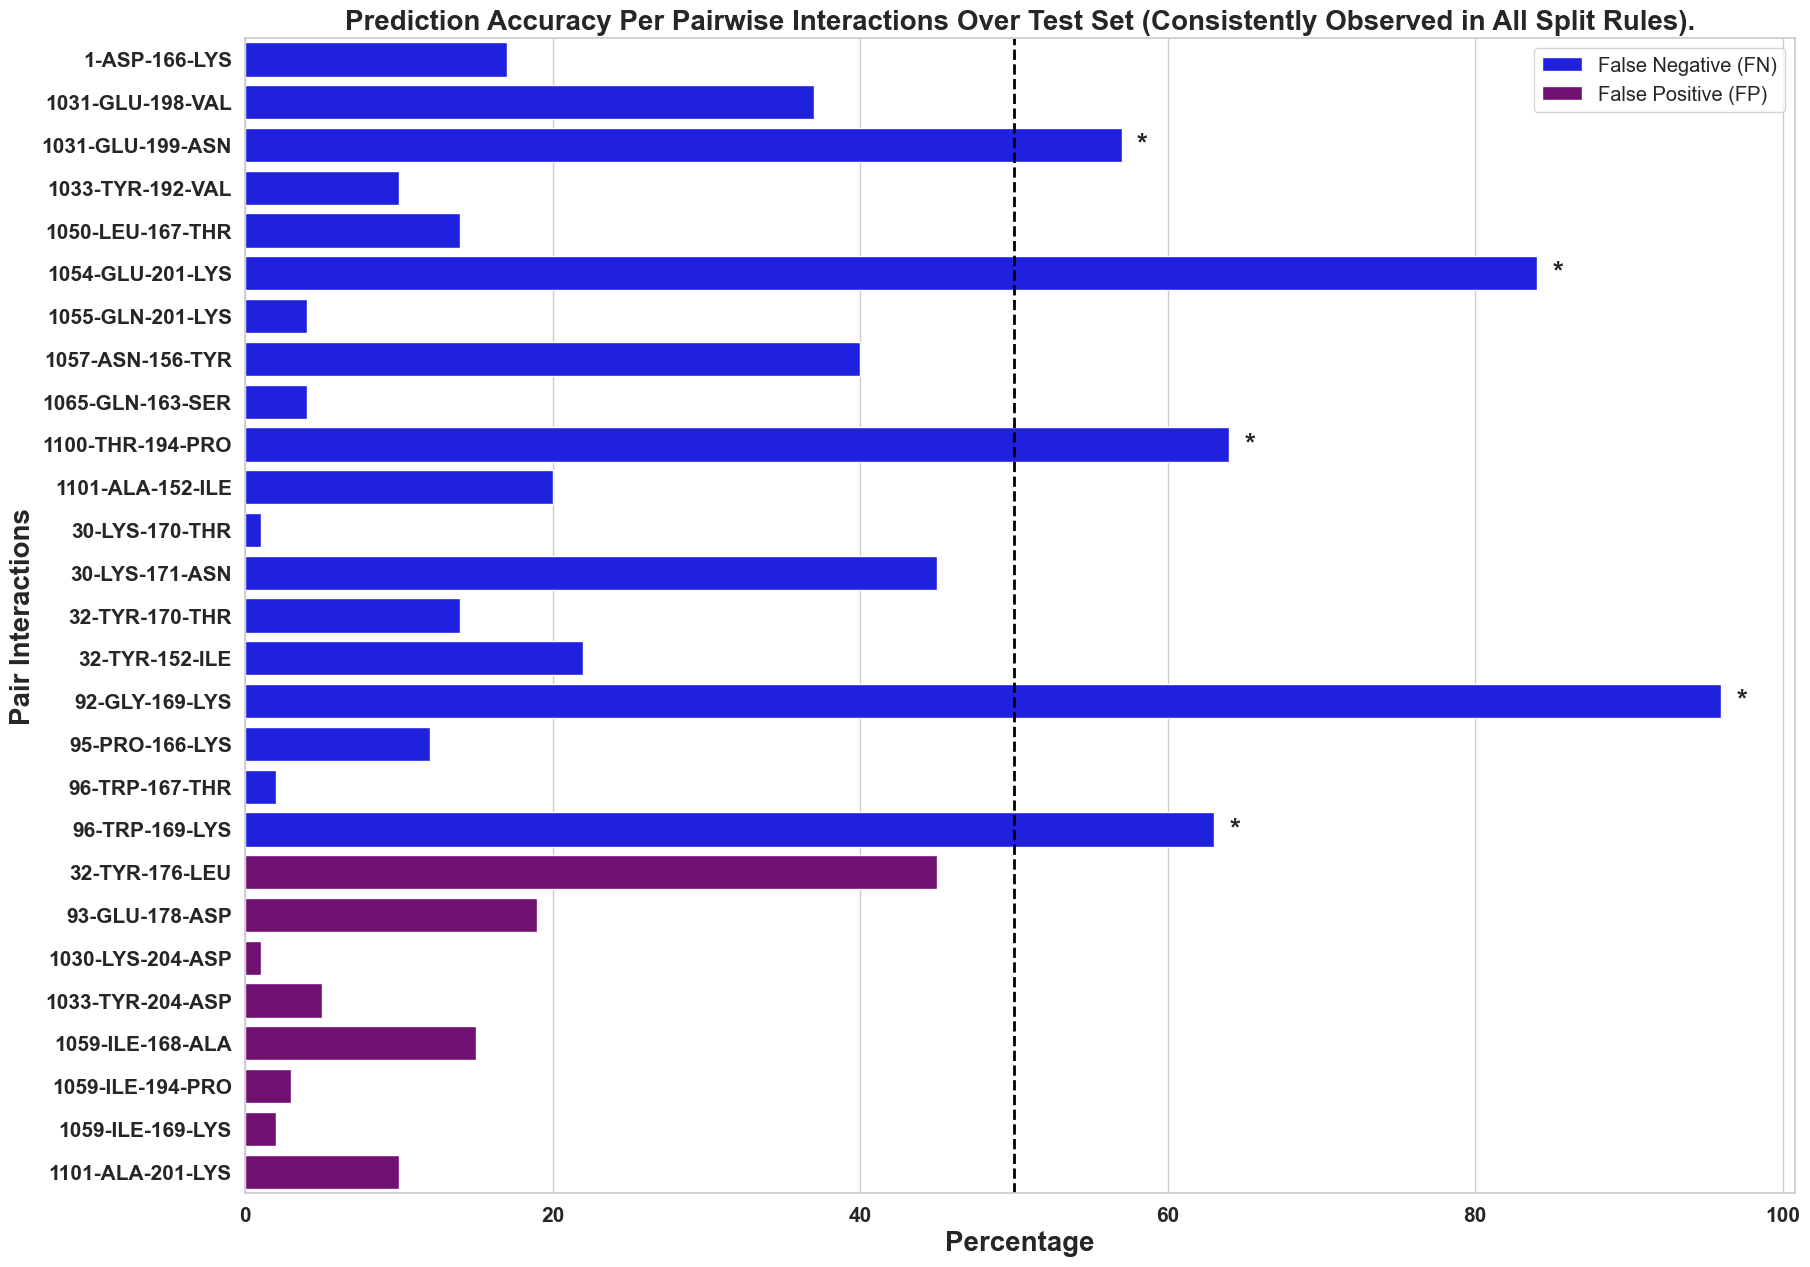

In [52]:
sns.set(style="whitegrid")
custom_colors = {'False Negative (FN)': 'Blue', 'False Positive (FP)': 'Purple'}
plt.figure(figsize=(20, 15))
ax = sns.barplot(x='freq', y='pair', hue='label', data=common_interactions, dodge=False, palette=custom_colors)
plt.ylabel('Pair Interactions',size=20, weight="bold")
plt.xlabel('Percentage',size=20, weight="bold")
plt.xticks(fontweight='bold', fontsize=15)
plt.yticks(fontweight='bold', fontsize=15)
ax.axvline(x=50, color='black', linestyle='--', linewidth=2)
plt.legend(fontsize='large')
for i, bar in enumerate(ax.patches):
    if bar.get_width() > 50:
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
                '*', fontsize=20, fontweight='bold', ha='left', va='center')
plt.title('Prediction Accuracy Per Pairwise Interactions Over Test Set (Consistently Observed in All Split Rules).',size=20, weight="bold")
plt.savefig('plots/CommonToAllSplit.png', dpi=300, bbox_inches='tight')


In [53]:
fig = px.histogram(common_unique_predicted_list, x="values",y='residue_a')
fig.update_layout(height=600,template="plotly_white",
                  title="Bar for pair interactions of heavy and light chains in unique predicted set",
                 yaxis_title="heavy and light chain")
fig.update_traces(marker_color="purple")
fig.write_image("plots/unique_predicted_bar_all_interactions.svg")
fig.show()

In [54]:
fig = px.histogram(common_unique_predicted_list, x="values",y='residue_b')
fig.update_layout(height=600,template="plotly_white",
                  title="Bar for pair interactions of tissue factor chain in unique predicted set",
                 yaxis_title="tissue factor chain")
fig.update_traces(marker_color="purple")
fig.write_image("plots/unique_predicted_bar_chain_A_interactions.svg")
fig.show()

In [55]:
fig = px.histogram(common_unique_predicted_list, x="values",y='pair')
fig.update_layout(height=600,template="plotly_white",
                  title="Bar for all pair interactions in unique predicted set")
fig.update_traces(marker_color="purple")
fig.write_image("plots/unique_predicted_bar_chain_C_interactions.svg")
fig.show()

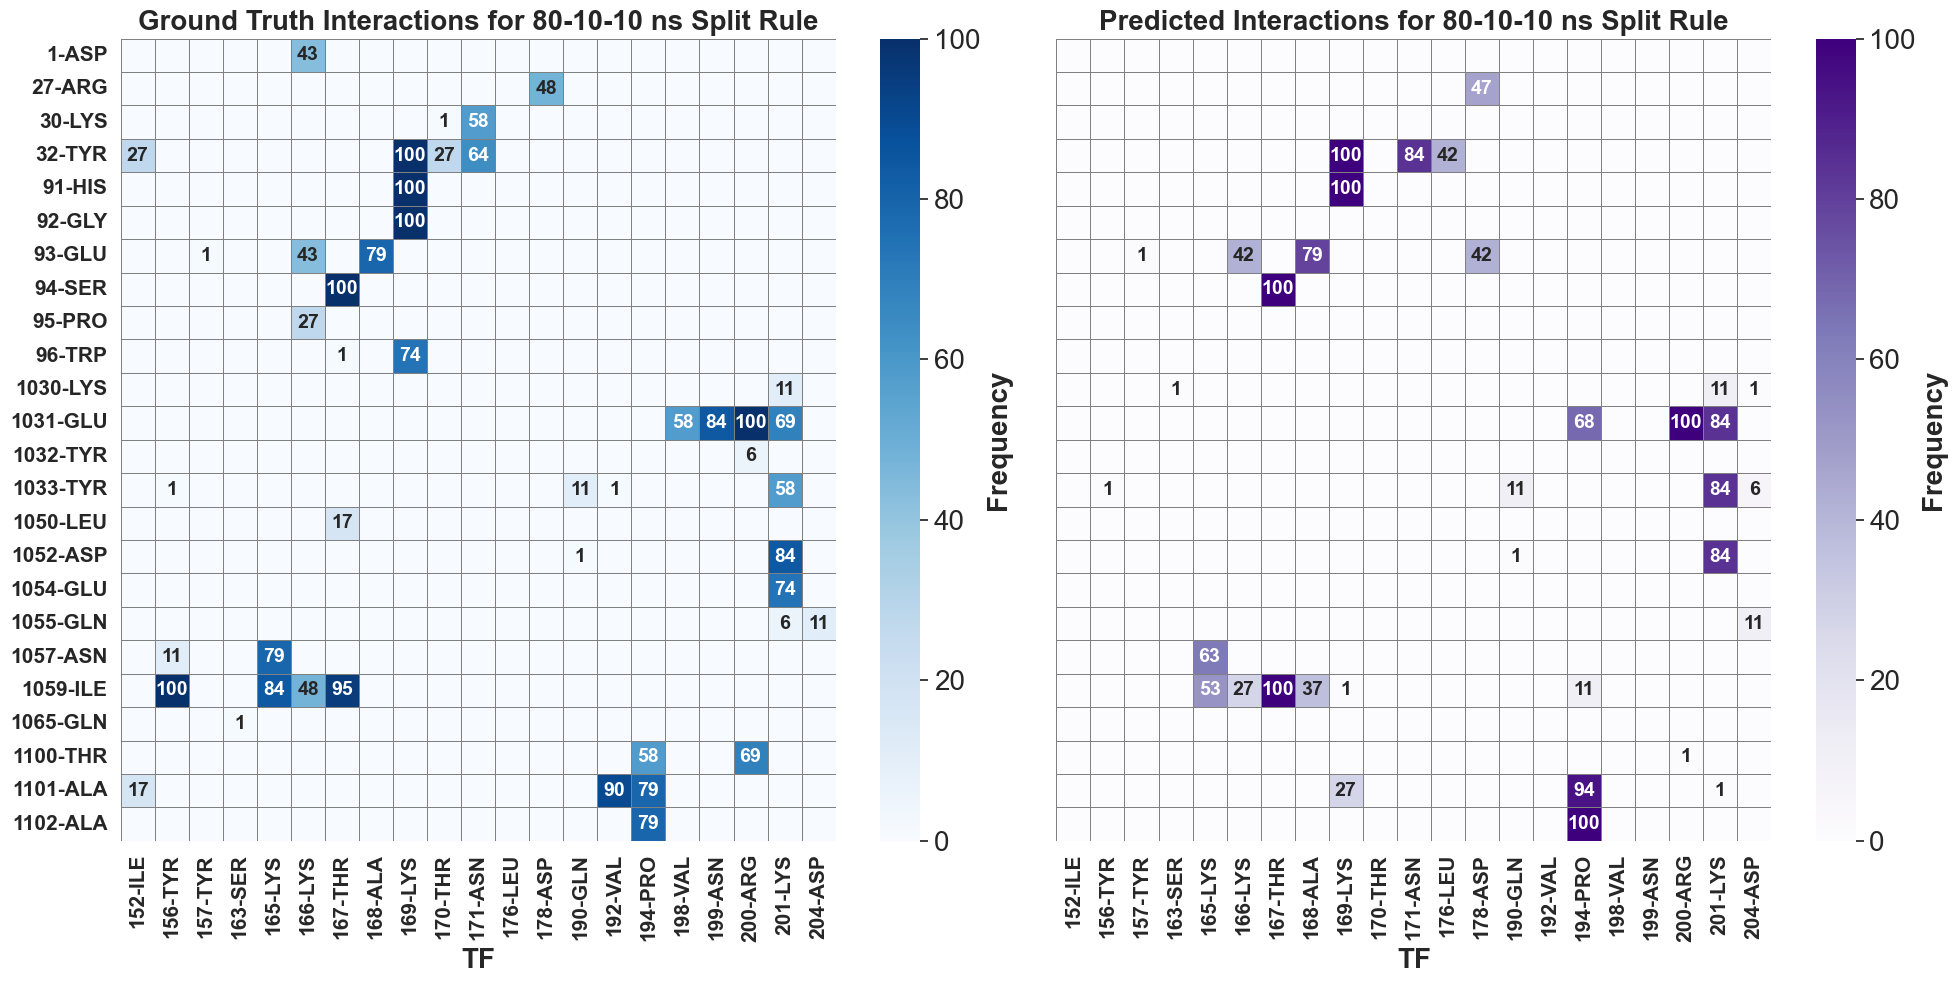

In [56]:
# factor = 10
vmin = 0  # Minimum value
vmax = 100  # Maximum value

filtered_df = test_set_post_process_160_20_20.groupby(['time_stamp', 'pair']).head(1)
filtered_df_160_20_20 = get_res_heatmap_df_output(filtered_df)
filtered_df_160_20_20['pair'] = filtered_df_160_20_20['residue_a'] + '-' + filtered_df_160_20_20['residue_b']
min_value_filtered_df_160_20_20 = filtered_df_160_20_20['values'].min()
max_value_filtered_df_160_20_20 = filtered_df_160_20_20['values'].max()
filtered_df_160_20_20['freq'] = 1 + (filtered_df_160_20_20['values'] - min_value_filtered_df_160_20_20) / (max_value_filtered_df_160_20_20 - min_value_filtered_df_160_20_20) * (100 - 1)
filtered_df_160_20_20['freq'] = filtered_df_160_20_20['freq'].apply(lambda x: round(x, 2))
filtered_df_160_20_20_sorted = filtered_df_160_20_20.sort_values(by="residue_a")
filtered_df_160_20_20_sorted['freq'] = filtered_df_160_20_20_sorted['freq'].round().astype(int)
#predicted_160_20_20_sorted['freq'] = predicted_160_20_20_sorted['freq'].round().astype(int)
#del predicted_160_20_20_sorted['freq']
res_merg_160_20_20 = pd.merge(filtered_df_160_20_20_sorted, predicted_160_20_20_sorted,how='outer')
res = res_merg_160_20_20[['residue_a', 'residue_b','pair']]
res_drop = res.drop_duplicates()
res_merg_ground_truth = pd.merge(res_drop, filtered_df_160_20_20_sorted,how='outer')
res_merg_predicted = pd.merge(res_drop, predicted_160_20_20_sorted,how='outer')
#res_merg_predicted["freq_100"] = res_merg_predicted["freq"] * 10

res_merg_ground_truth['numeric_order'] = res_merg_ground_truth['residue_a'].apply(lambda x: int(x.split('-')[0]) if x.split('-')[0].isdigit() else float('inf'))
res_merg_ground_truth_sorted = res_merg_ground_truth.sort_values(by='numeric_order', ascending=True)

res_merg_predicted['numeric_order'] = res_merg_predicted['residue_a'].apply(lambda x: int(x.split('-')[0]) if x.split('-')[0].isdigit() else float('inf'))
res_merg_predicted_sorted = res_merg_predicted.sort_values(by='numeric_order', ascending=True)

test_pivot_160_20_20 = pd.pivot_table(res_merg_ground_truth_sorted,index='residue_a', columns='residue_b', values='freq', aggfunc='sum', fill_value=0)
predicted_160_20_20_sorted_pivot = pd.pivot_table(res_merg_predicted_sorted,index='residue_a', columns='residue_b', values='freq', aggfunc='sum', fill_value=0)

test_pivot_160_20_20_sorted_pivot = test_pivot_160_20_20.reindex(res_merg_ground_truth_sorted['residue_a'].unique())
predicted_160_20_20_sorted_pivot_pivot = predicted_160_20_20_sorted_pivot.reindex(res_merg_predicted_sorted['residue_a'].unique())


# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first heatmap
ax1 = sns.heatmap(test_pivot_160_20_20_sorted_pivot, ax=axes[0], cmap='Blues',linewidths=0.5, linecolor='gray',annot_kws={"weight": "bold","size":14},vmin=vmin, vmax=vmax,annot=True,fmt=".0f")
axes[0].set_title('Ground Truth Interactions for 80-10-10 ns Split Rule', size=20, weight="bold")
axes[0].set_xlabel('TF', size=20, weight="bold")
axes[0].set_ylabel("")
#axes[0].set_ylabel('A chain', size=20, weight="bold")
for t in ax1.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text()) #if the value is greater than 0 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text
ax1.set_yticklabels(test_pivot_160_20_20_sorted_pivot.index, size = 15, weight="bold")
ax1.set_xticklabels(test_pivot_160_20_20_sorted_pivot.columns, size = 15, weight="bold")

# Plot the second heatmap
ax2 = sns.heatmap(predicted_160_20_20_sorted_pivot_pivot, ax=axes[1],yticklabels=False, cmap='Purples',linewidths=0.5, linecolor='gray',vmin=vmin, vmax=vmax,annot=True,fmt=".0f",annot_kws={"weight": "bold","size":14})
axes[1].set_title('Predicted Interactions for 80-10-10 ns Split Rule', size=20, weight="bold")
axes[1].set_xlabel('TF', size=20, weight="bold")
axes[1].set_ylabel("")
#axes[1].set_ylabel('A chain', size=20, weight="bold")
for t in ax2.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text()) #if the value is greater than 0 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text
        
#ax2.set_yticklabels(predicted_160_20_20_sorted_pivot.index, size = 15, weight="bold")
ax2.set_xticklabels(predicted_160_20_20_sorted_pivot_pivot.columns, size = 15, weight="bold")
# Add colorbars to each heatmap
cbar1 = axes[0].collections[0].colorbar
cbar2 = axes[1].collections[0].colorbar
cbar1.ax.tick_params(labelsize=20)
cbar2.ax.tick_params(labelsize=20)
cbar1.set_label('Frequency',size=20, weight="bold")
cbar2.set_label('Frequency',size=20, weight="bold")


# Adjust the layout
plt.tight_layout()

# Show the plot
plt.savefig('./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/graphs/heatmap_160_20_20.png', dpi=300, bbox_inches='tight')
plt.show()


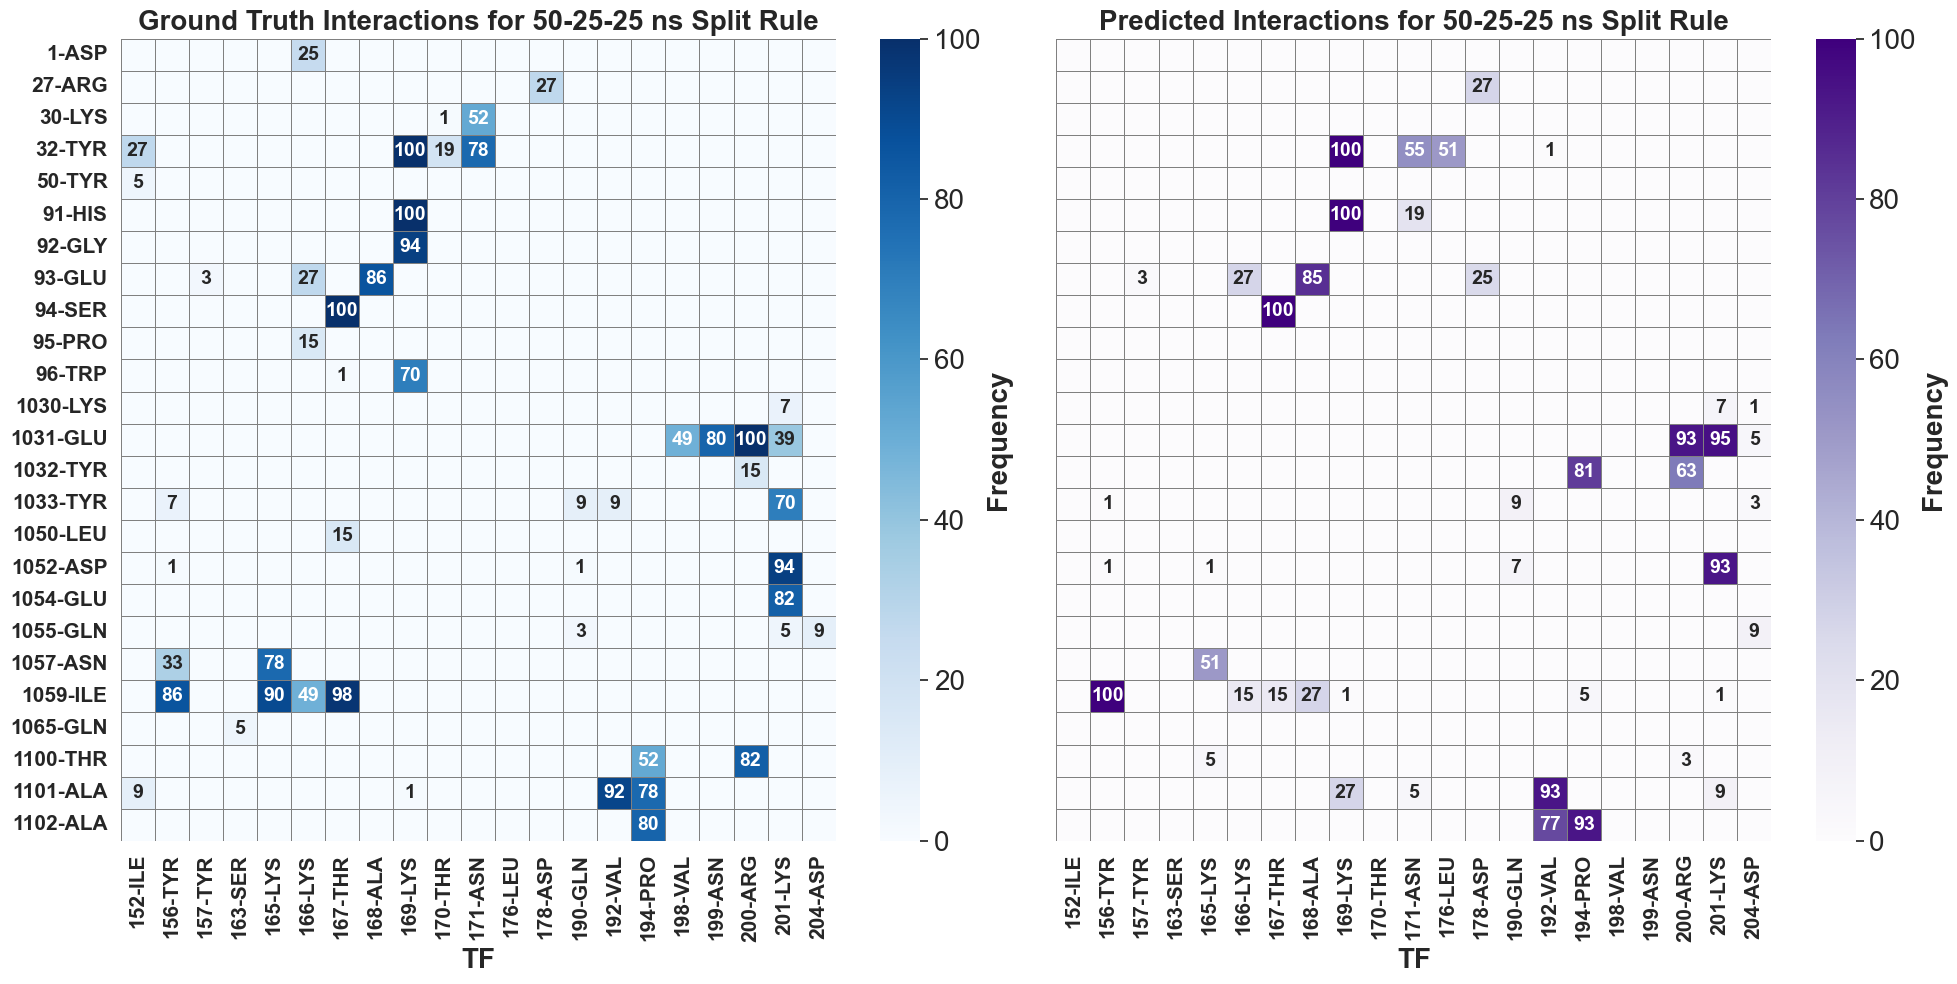

In [57]:
from matplotlib.ticker import ScalarFormatter

# factor = 10
vmin = 0  # Minimum value
vmax = 100  # Maximum value

filtered_df = test_set_post_process_100_50_50.groupby(['time_stamp', 'pair']).head(1)
filtered_df_100_50_50 = get_res_heatmap_df_output(filtered_df)
filtered_df_100_50_50['pair'] = filtered_df_100_50_50['residue_a'] + '-' + filtered_df_100_50_50['residue_b']
min_value_filtered_df_100_50_50 = filtered_df_100_50_50['values'].min()
max_value_filtered_df_100_50_50 = filtered_df_100_50_50['values'].max()
filtered_df_100_50_50['freq'] = 1 + (filtered_df_100_50_50['values'] - min_value_filtered_df_100_50_50) / (max_value_filtered_df_100_50_50 - min_value_filtered_df_100_50_50) * (100 - 1)
filtered_df_100_50_50['freq'] = filtered_df_100_50_50['freq'].apply(lambda x: round(x, 2))
filtered_df_100_50_50_sorted = filtered_df_100_50_50.sort_values(by="residue_a")
filtered_df_100_50_50_sorted['freq'] = filtered_df_100_50_50_sorted['freq'].round().astype(int)
predicted_100_50_50_sorted['freq'] = predicted_100_50_50_sorted['freq'].round().astype(int)
#del predicted_160_20_20_sorted['freq']
res_merg_100_50_50 = pd.merge(filtered_df_100_50_50_sorted, predicted_100_50_50_sorted,how='outer')
res = res_merg_100_50_50[['residue_a', 'residue_b','pair']]
res_drop = res.drop_duplicates()
res_merg_ground_truth = pd.merge(res_drop, filtered_df_100_50_50_sorted,how='outer')
res_merg_predicted = pd.merge(res_drop, predicted_100_50_50_sorted,how='outer')
#res_merg_predicted["freq_100"] = res_merg_predicted["freq"] * 10

res_merg_ground_truth['numeric_order'] = res_merg_ground_truth['residue_a'].apply(lambda x: int(x.split('-')[0]) if x.split('-')[0].isdigit() else float('inf'))
res_merg_ground_truth_sorted = res_merg_ground_truth.sort_values(by='numeric_order', ascending=True)

res_merg_predicted['numeric_order'] = res_merg_predicted['residue_a'].apply(lambda x: int(x.split('-')[0]) if x.split('-')[0].isdigit() else float('inf'))
res_merg_predicted_sorted = res_merg_predicted.sort_values(by='numeric_order', ascending=True)

test_pivot_100_50_50 = pd.pivot_table(res_merg_ground_truth_sorted,index='residue_a', columns='residue_b', values='freq', aggfunc='sum', fill_value=0)
predicted_100_50_50_sorted_pivot = pd.pivot_table(res_merg_predicted_sorted,index='residue_a', columns='residue_b', values='freq', aggfunc='sum', fill_value=0)

test_pivot_100_50_50_sorted_pivot = test_pivot_100_50_50.reindex(res_merg_ground_truth_sorted['residue_a'].unique())
predicted_100_50_50_sorted_pivot_pivot = predicted_100_50_50_sorted_pivot.reindex(res_merg_predicted_sorted['residue_a'].unique())


# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first heatmap
ax1 = sns.heatmap(test_pivot_100_50_50_sorted_pivot, ax=axes[0], cmap='Blues',linewidths=0.5, linecolor='gray',annot_kws={"weight": "bold","size":14},vmin=vmin, vmax=vmax,annot=True,fmt=".0f")
axes[0].set_title('Ground Truth Interactions for 50-25-25 ns Split Rule', size=20, weight="bold")
axes[0].set_xlabel('TF', size=20, weight="bold")
axes[0].set_ylabel("")
for t in ax1.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text()) #if the value is greater than 0 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text
ax1.set_yticklabels(test_pivot_100_50_50_sorted_pivot.index, size = 15, weight="bold")
ax1.set_xticklabels(test_pivot_100_50_50_sorted_pivot.columns, size = 15, weight="bold")

# Plot the second heatmap
ax2 = sns.heatmap(predicted_100_50_50_sorted_pivot_pivot, ax=axes[1], cmap='Purples',yticklabels=False,linewidths=0.5, linecolor='gray',vmin=vmin, vmax=vmax,annot=True,fmt=".0f",annot_kws={"weight": "bold","size":14})
axes[1].set_title('Predicted Interactions for 50-25-25 ns Split Rule', size=20, weight="bold")
axes[1].set_xlabel('TF', size=20, weight="bold")
#axes[1].set_ylabel('A chain', size=20, weight="bold")
axes[1].set_ylabel("")
for t in ax2.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text()) #if the value is greater than 0 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text
        
#ax2.set_yticklabels(predicted_100_50_50_sorted_pivot.index, size = 15, weight="bold")
ax2.set_xticklabels(predicted_100_50_50_sorted_pivot_pivot.columns, size = 15, weight="bold")
# Add colorbars to each heatmap
cbar1 = axes[0].collections[0].colorbar
cbar2 = axes[1].collections[0].colorbar
cbar1.ax.tick_params(labelsize=20)
cbar2.ax.tick_params(labelsize=20)
cbar1.set_label('Frequency',size=20, weight="bold")
cbar2.set_label('Frequency',size=20, weight="bold")


# Adjust the layout
plt.tight_layout()

# Show the plot
plt.savefig('./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/graphs/heatmap_100_50_50.png', dpi=300, bbox_inches='tight')
plt.show()


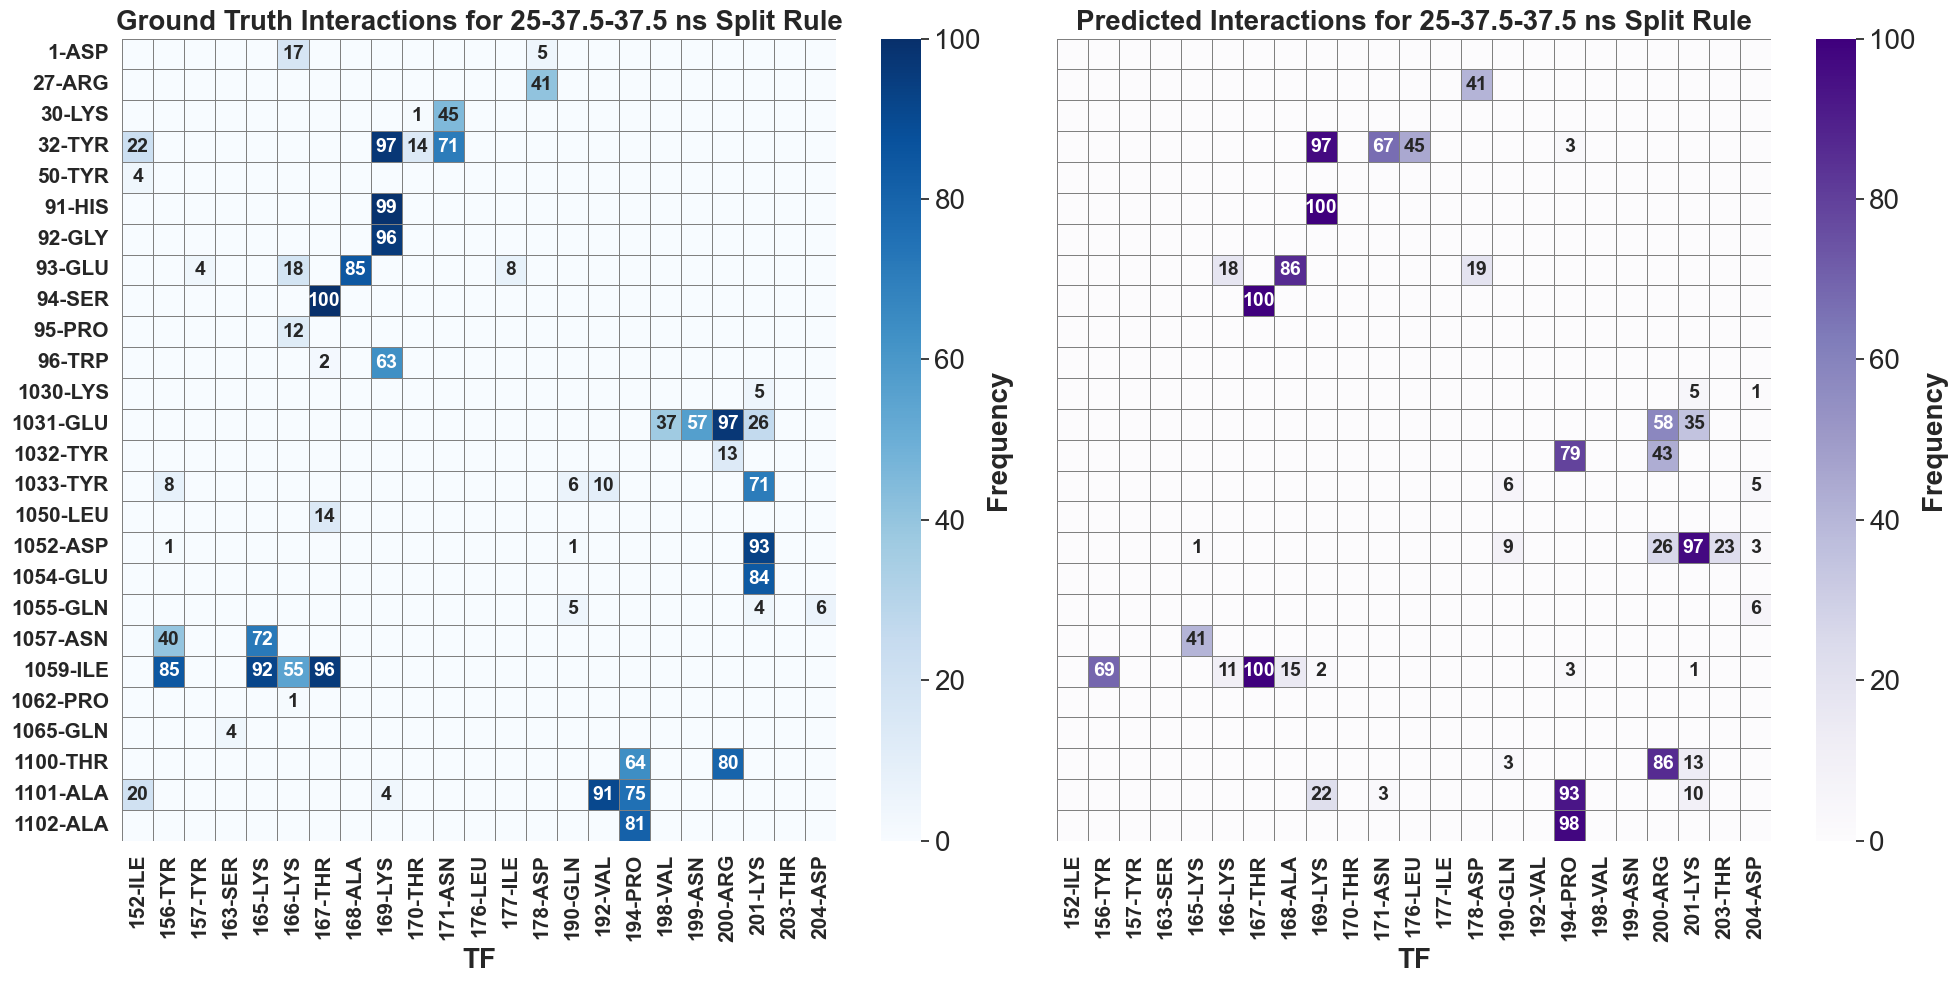

In [58]:
from matplotlib.ticker import ScalarFormatter

# factor = 10
vmin = 0  # Minimum value
vmax = 100  # Maximum value

filtered_df = test_set_post_process_50_75_75.groupby(['time_stamp', 'pair']).head(1)
filtered_df_50_75_75 = get_res_heatmap_df_output(filtered_df)
filtered_df_50_75_75['pair'] = filtered_df_50_75_75['residue_a'] + '-' + filtered_df_50_75_75['residue_b']
min_value_filtered_df_50_75_75 = filtered_df_50_75_75['values'].min()
max_value_filtered_df_50_75_75 = filtered_df_50_75_75['values'].max()
filtered_df_50_75_75['freq'] = 1 + (filtered_df_50_75_75['values'] - min_value_filtered_df_50_75_75) / (max_value_filtered_df_50_75_75 - min_value_filtered_df_50_75_75) * (100 - 1)
filtered_df_50_75_75['freq'] = filtered_df_50_75_75['freq'].apply(lambda x: round(x, 2))
filtered_df_50_75_75_sorted = filtered_df_50_75_75.sort_values(by="residue_a")
filtered_df_50_75_75_sorted['freq'] = filtered_df_50_75_75_sorted['freq'].round().astype(int)
predicted_50_75_75_sorted['freq'] = predicted_50_75_75_sorted['freq'].round().astype(int)
#del predicted_160_20_20_sorted['freq']
res_merg_50_75_75 = pd.merge(filtered_df_50_75_75_sorted, predicted_50_75_75_sorted,how='outer')
res = res_merg_50_75_75[['residue_a', 'residue_b','pair']]
res_drop = res.drop_duplicates()
res_merg_ground_truth = pd.merge(res_drop, filtered_df_50_75_75_sorted,how='outer')
res_merg_predicted = pd.merge(res_drop, predicted_50_75_75_sorted,how='outer')
#res_merg_predicted["freq_100"] = res_merg_predicted["freq"] * 10

res_merg_ground_truth['numeric_order'] = res_merg_ground_truth['residue_a'].apply(lambda x: int(x.split('-')[0]) if x.split('-')[0].isdigit() else float('inf'))
res_merg_ground_truth_sorted = res_merg_ground_truth.sort_values(by='numeric_order', ascending=True)

res_merg_predicted['numeric_order'] = res_merg_predicted['residue_a'].apply(lambda x: int(x.split('-')[0]) if x.split('-')[0].isdigit() else float('inf'))
res_merg_predicted_sorted = res_merg_predicted.sort_values(by='numeric_order', ascending=True)

test_pivot_50_75_75 = pd.pivot_table(res_merg_ground_truth_sorted,index='residue_a', columns='residue_b', values='freq', aggfunc='sum', fill_value=0)
predicted_50_75_75_sorted_pivot = pd.pivot_table(res_merg_predicted_sorted,index='residue_a', columns='residue_b', values='freq', aggfunc='sum', fill_value=0)

test_pivot_50_75_75_sorted_pivot = test_pivot_50_75_75.reindex(res_merg_ground_truth_sorted['residue_a'].unique())
predicted_50_75_75_sorted_pivot_pivot = predicted_50_75_75_sorted_pivot.reindex(res_merg_predicted_sorted['residue_a'].unique())


# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first heatmap
ax1 = sns.heatmap(test_pivot_50_75_75_sorted_pivot, ax=axes[0], cmap='Blues',linewidths=0.5, linecolor='gray',annot_kws={"weight": "bold","size":14},vmin=vmin, vmax=vmax,annot=True,fmt=".0f")
axes[0].set_title('Ground Truth Interactions for 25-37.5-37.5 ns Split Rule', size=20, weight="bold")
axes[0].set_xlabel('TF', size=20, weight="bold")
axes[0].set_ylabel("")
for t in ax1.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text()) #if the value is greater than 0 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text
ax1.set_yticklabels(test_pivot_50_75_75_sorted_pivot.index, size = 15, weight="bold")
ax1.set_xticklabels(test_pivot_50_75_75_sorted_pivot.columns, size = 15, weight="bold")

# Plot the second heatmap
ax2 = sns.heatmap(predicted_50_75_75_sorted_pivot_pivot, ax=axes[1], cmap='Purples',yticklabels=False,linewidths=0.5, linecolor='gray',vmin=vmin, vmax=vmax,annot=True,fmt=".0f",annot_kws={"size":14,"weight": "bold"})
axes[1].set_title('Predicted Interactions for 25-37.5-37.5 ns Split Rule', size=20, weight="bold")
axes[1].set_xlabel('TF', size=20, weight="bold")
axes[1].set_ylabel("")
for t in ax2.texts:
    if float(t.get_text())>0:
        t.set_text(t.get_text()) #if the value is greater than 0 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text
        
#ax2.set_yticklabels(predicted_50_75_75_sorted_pivot.index, size = 15, weight="bold")
ax2.set_xticklabels(predicted_50_75_75_sorted_pivot_pivot.columns, size = 15, weight="bold")
# Add colorbars to each heatmap
cbar1 = axes[0].collections[0].colorbar
cbar2 = axes[1].collections[0].colorbar
cbar1.ax.tick_params(labelsize=20)
cbar2.ax.tick_params(labelsize=20)
cbar1.set_label('Frequency',size=20, weight="bold")
cbar2.set_label('Frequency',size=20, weight="bold")


# Adjust the layout
plt.tight_layout()

# Show the plot
plt.savefig('./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/graphs/heatmap_50_75_75.png', dpi=300, bbox_inches='tight')
plt.show()


In [65]:
performance_test_100_50_50 = pd.read_excel("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/tables/performance_100_50_50_test_set.xlsx")
performance_valid_100_50_50 = pd.read_excel("./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/tables/performance_100_50_50_validation_set.xlsx")
performance_valid_160_20_20 = pd.read_excel("./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/tables/performance_160_20_20_validation_set.xlsx")
performance_test_160_20_20 = pd.read_excel("./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/tables/performance_160_20_20_test_set.xlsx")
performance_test_50_75_75 = pd.read_excel("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/tables/performance_50_75_75_test_set.xlsx")
performance_valid_50_75_75 = pd.read_excel("./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/tables/performance_50_75_75_validation_set.xlsx")


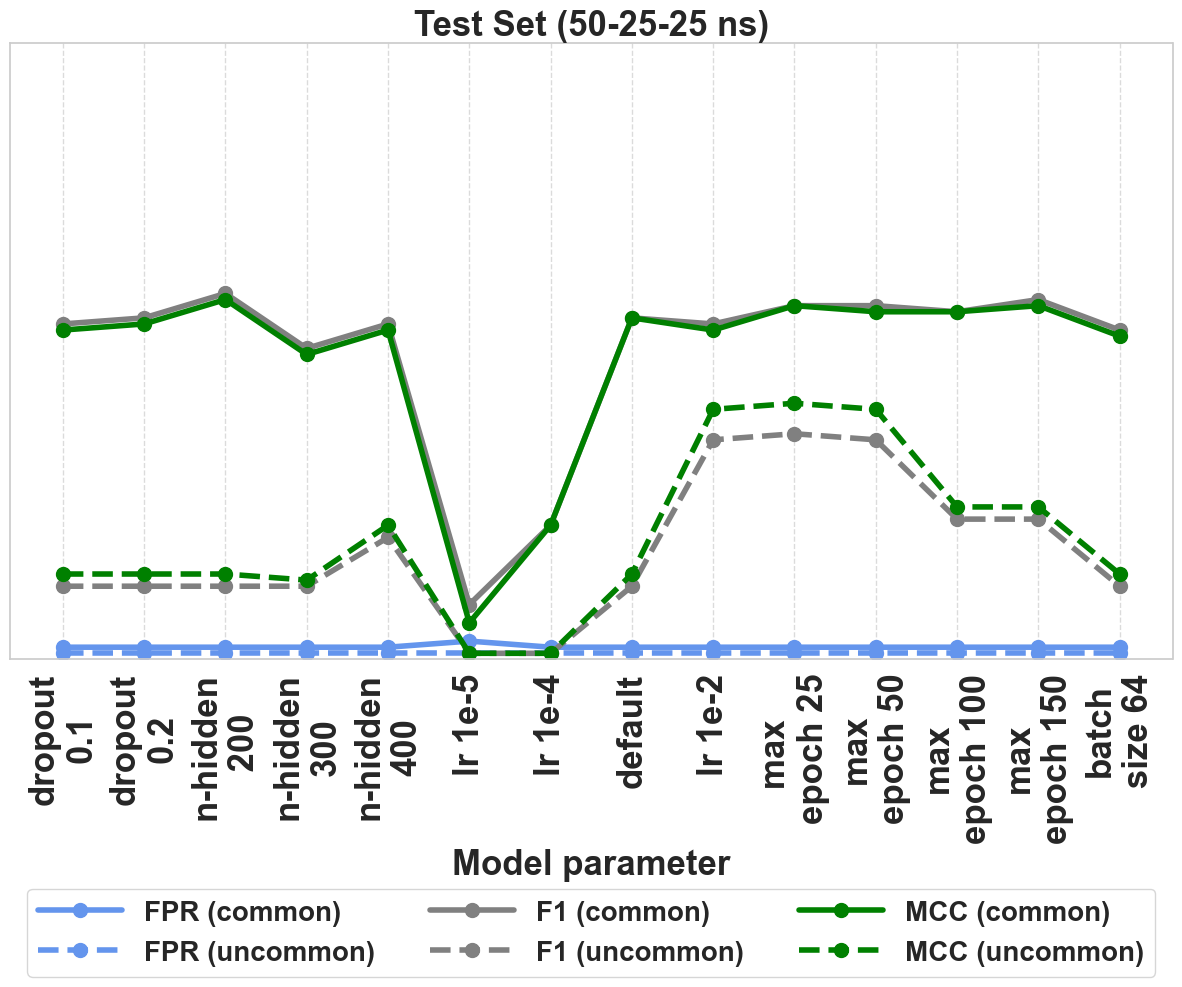

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))  # Adjust the width and height as needed

# Plotting the data
plt.plot(performance_test_100_50_50['1JPS 100-50-50 Split'], performance_test_100_50_50['FPR (common)'], marker='o', markersize=10, color='cornflowerblue', label='FPR (common)', linewidth=4.0)
plt.plot(performance_test_100_50_50['1JPS 100-50-50 Split'], performance_test_100_50_50['FPR (uncommon)'], marker='o', markersize=10, color='cornflowerblue', linestyle='--', linewidth=4.0, label='FPR (uncommon)')
plt.plot(performance_test_100_50_50['1JPS 100-50-50 Split'], performance_test_100_50_50['F1 (common)'], marker='o', color='gray', markersize=10 ,label='F1 (common)', linewidth=4.0)
plt.plot(performance_test_100_50_50['1JPS 100-50-50 Split'], performance_test_100_50_50['F1 (uncommon)'], marker='o', color='gray', markersize=10, linestyle='--', label='F1 (uncommon)', linewidth=4.0)
plt.plot(performance_test_100_50_50['1JPS 100-50-50 Split'], performance_test_100_50_50['MCC (common)'], marker='o', color='green', markersize=10, label='MCC (common)', linewidth=4.0)
plt.plot(performance_test_100_50_50['1JPS 100-50-50 Split'], performance_test_100_50_50['MCC (uncommon)'], marker='o', color='green', markersize=10, linestyle='--', label='MCC (uncommon)', linewidth=4.0)



# Adding labels and title
plt.ylim((-0.01,1))
plt.xlabel('Model parameter', fontsize=25, fontweight='bold')
plt.ylabel("")
plt.title('Test Set (50-25-25 ns)', fontsize=25, fontweight='bold')

# Adding legend
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.35), prop={'weight': 'bold','size': '20'}, handlelength=3.0)
plt.tick_params(axis='y', labelsize=25)
plt.tick_params(axis='x', labelsize=25)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation='vertical',weight = 'bold')
plt.yticks(weight = 'bold')
plt.gca().set_yticks([])

# Display the plot
plt.savefig('./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/graphs/testPerformances_100_50_50.png', dpi=300, bbox_inches='tight')
plt.show()


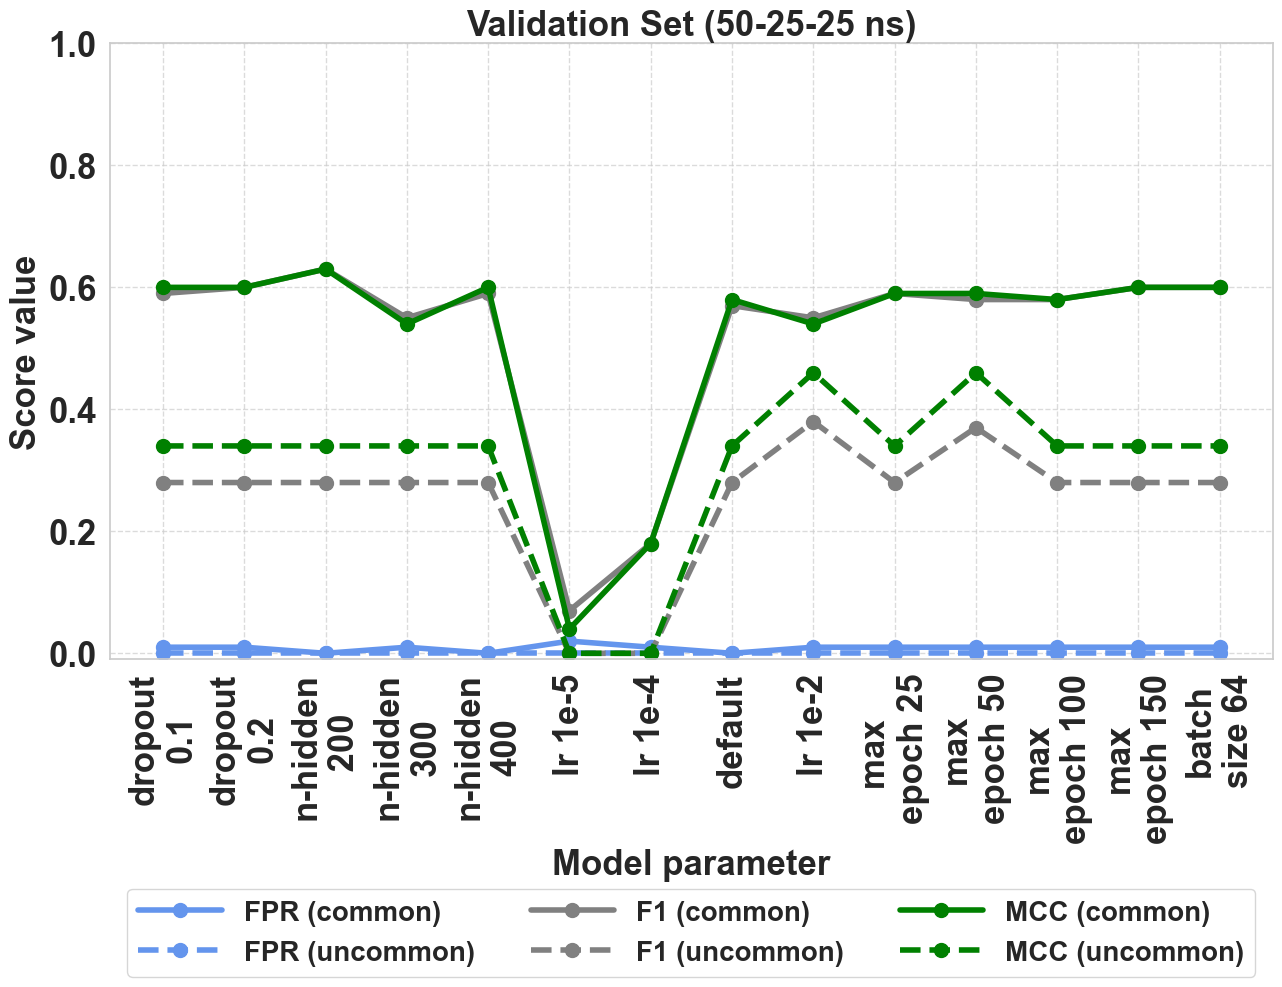

In [67]:
plt.figure(figsize=(15, 8))  # Adjust the width and height as needed

# Plotting the data
plt.plot(performance_valid_100_50_50['1JPS 100-50-50 Split'], performance_valid_100_50_50['FPR (common)'], marker='o', color='cornflowerblue', label='FPR (common)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_100_50_50['1JPS 100-50-50 Split'], performance_valid_100_50_50['FPR (uncommon)'], marker='o', color='cornflowerblue', linestyle='--', label='FPR (uncommon)',markersize=10, linewidth=4.0)
plt.plot(performance_valid_100_50_50['1JPS 100-50-50 Split'], performance_valid_100_50_50['F1 (common)'], marker='o', color='gray', label='F1 (common)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_100_50_50['1JPS 100-50-50 Split'], performance_valid_100_50_50['F1 (uncommon)'], marker='o', color='gray', linestyle='--', label='F1 (uncommon)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_100_50_50['1JPS 100-50-50 Split'], performance_valid_100_50_50['MCC (common)'], marker='o', color='green', label='MCC (common)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_100_50_50['1JPS 100-50-50 Split'], performance_valid_100_50_50['MCC (uncommon)'], marker='o', color='green', linestyle='--', label='MCC (uncommon)', linewidth=4.0,markersize=10)



# Adding labels and title
plt.ylim((-0.01,1))
plt.xlabel('Model parameter', fontsize=25, fontweight='bold')
plt.ylabel('Score value', fontsize=25, fontweight='bold')
plt.title('Validation Set (50-25-25 ns)', fontsize=25, fontweight='bold')

# Adding legend
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.35), prop={'weight': 'bold','size': '20'}, handlelength=3.0)
plt.tick_params(axis='y', labelsize=25)
plt.tick_params(axis='x', labelsize=25)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation='vertical',weight="bold")
plt.yticks(weight = 'bold')

# Display the plot
plt.savefig('./Splitting/100-50-50/graphs_and_tables_for_optimized_hyperparameter_100-50-50/graphs/validPerformances_100_50_50.png', dpi=300, bbox_inches='tight')
plt.show()


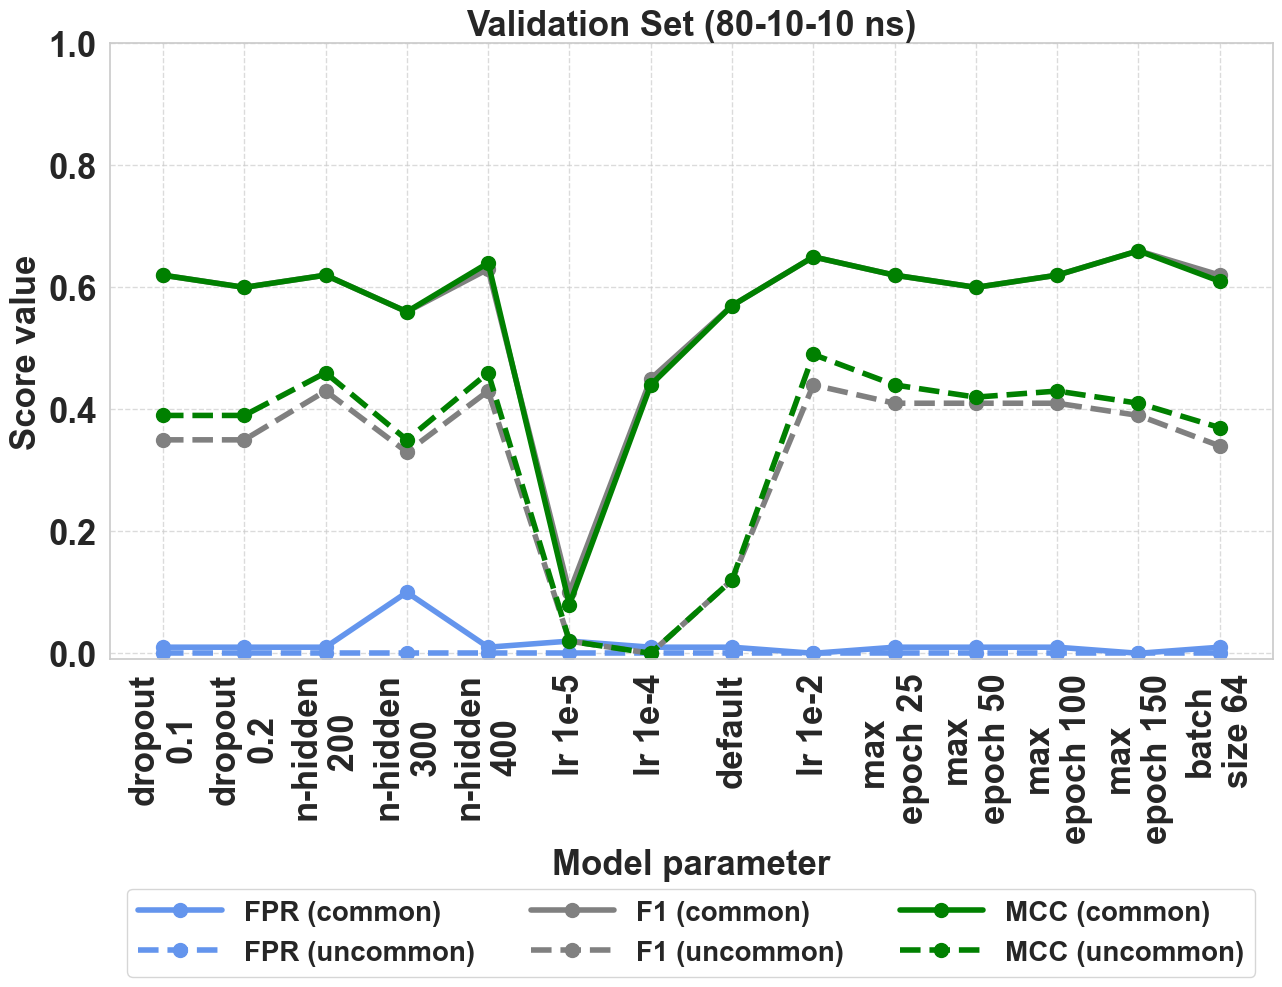

In [68]:
plt.figure(figsize=(15, 8))  # Adjust the width and height as needed

# Plotting the data
plt.plot(performance_valid_160_20_20['1JPS 160-20-20 Split'], performance_valid_160_20_20['FPR (common)'], marker='o', color='cornflowerblue', label='FPR (common)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_160_20_20['1JPS 160-20-20 Split'], performance_valid_160_20_20['FPR (uncommon)'], marker='o', color='cornflowerblue', linestyle='--', label='FPR (uncommon)', markersize=10, linewidth=4.0)
plt.plot(performance_valid_160_20_20['1JPS 160-20-20 Split'], performance_valid_160_20_20['F1 (common)'], marker='o', color='gray', label='F1 (common)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_160_20_20['1JPS 160-20-20 Split'], performance_valid_160_20_20['F1 (uncommon)'], marker='o', color='gray', linestyle='--', label='F1 (uncommon)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_160_20_20['1JPS 160-20-20 Split'], performance_valid_160_20_20['MCC (common)'], marker='o', color='green', label='MCC (common)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_160_20_20['1JPS 160-20-20 Split'], performance_valid_160_20_20['MCC (uncommon)'], marker='o', color='green', linestyle='--', label='MCC (uncommon)', linewidth=4.0,markersize=10)



# Adding labels and title
plt.ylim((-0.01,1))
plt.xlabel('Model parameter', fontsize=25, fontweight='bold')
plt.ylabel('Score value', fontsize=25, fontweight='bold')
plt.title('Validation Set (80-10-10 ns)', fontsize=25, fontweight='bold')

# Adding legend
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.35), prop={'weight': 'bold','size': '20'}, handlelength=3.0)
plt.tick_params(axis='y', labelsize=25)
plt.tick_params(axis='x', labelsize=25)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation='vertical',weight = 'bold')
plt.yticks(weight = 'bold')

# Display the plot
plt.savefig('./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/graphs/validPerformances_160_20_20.png', dpi=300, bbox_inches='tight')
plt.show()


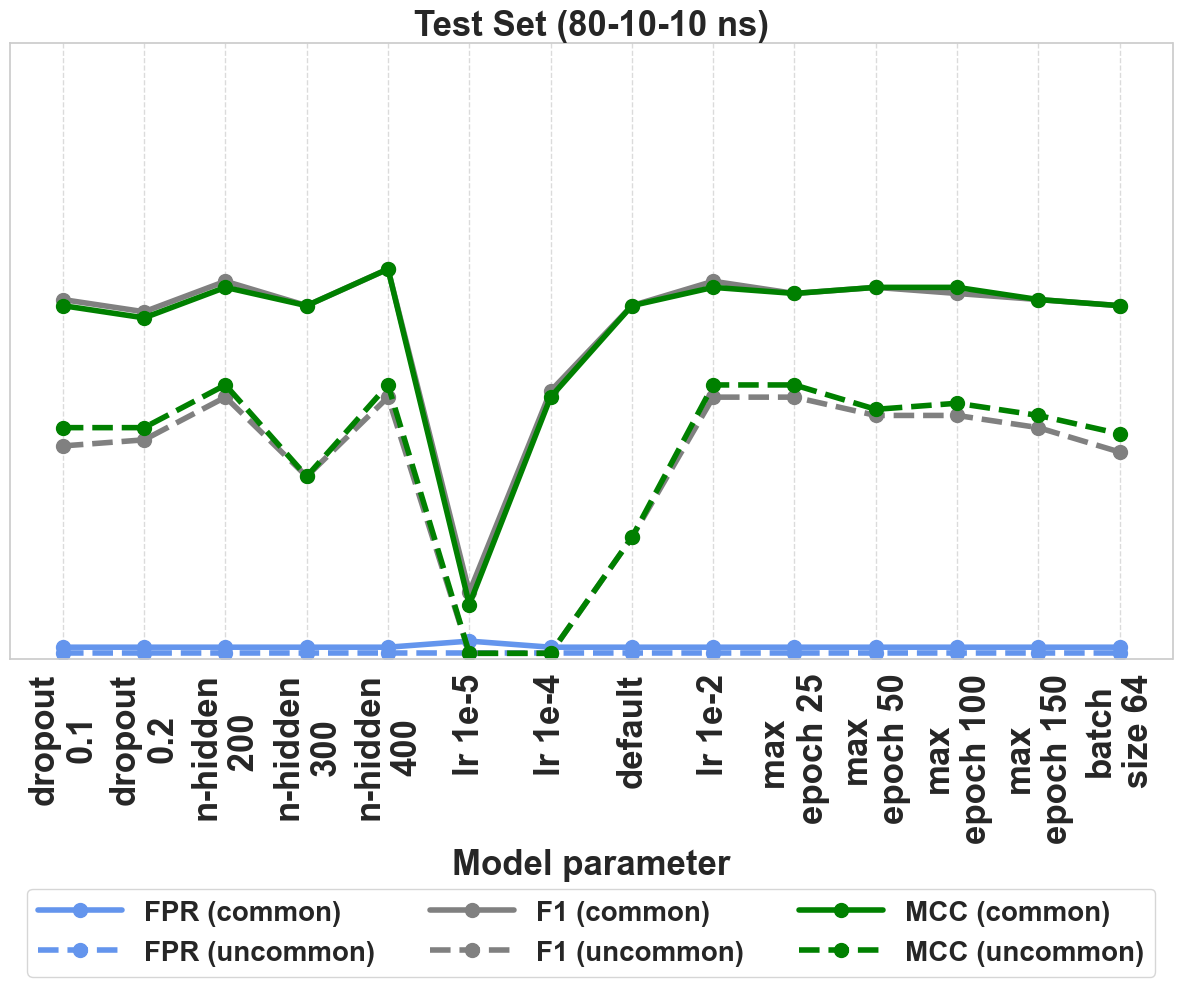

In [69]:
plt.figure(figsize=(15, 8))  # Adjust the width and height as needed

# Plotting the data
plt.plot(performance_test_160_20_20['1JPS 160-20-20 Split'], performance_test_160_20_20['FPR (common)'], marker='o', color='cornflowerblue', label='FPR (common)', linewidth=4.0,markersize=10)
plt.plot(performance_test_160_20_20['1JPS 160-20-20 Split'], performance_test_160_20_20['FPR (uncommon)'], marker='o', color='cornflowerblue', linestyle='--', label='FPR (uncommon)', linewidth=4.0,markersize=10)
plt.plot(performance_test_160_20_20['1JPS 160-20-20 Split'], performance_test_160_20_20['F1 (common)'], marker='o', color='gray', label='F1 (common)', linewidth=4.0,markersize=10)
plt.plot(performance_test_160_20_20['1JPS 160-20-20 Split'], performance_test_160_20_20['F1 (uncommon)'], marker='o', color='gray', linestyle='--', label='F1 (uncommon)', linewidth=4.0,markersize=10)
plt.plot(performance_test_160_20_20['1JPS 160-20-20 Split'], performance_test_160_20_20['MCC (common)'], marker='o', color='green', label='MCC (common)', linewidth=4.0,markersize=10)
plt.plot(performance_test_160_20_20['1JPS 160-20-20 Split'], performance_test_160_20_20['MCC (uncommon)'], marker='o', color='green', linestyle='--', label='MCC (uncommon)', linewidth=4.0,markersize=10)



# Adding labels and title
plt.ylim((-0.01,1))
plt.xlabel('Model parameter', fontsize=25, fontweight='bold')
plt.ylabel("")
plt.title('Test Set (80-10-10 ns)', fontsize=25, fontweight='bold')

# Adding legend
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.35), prop={'weight': 'bold','size': '20'}, handlelength=3.0)
plt.tick_params(axis='y', labelsize=25)
plt.tick_params(axis='x', labelsize=25)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation='vertical',weight = 'bold')
plt.gca().set_yticks([])

# Display the plot
plt.savefig('./Splitting/160-20-20/graphs_and_tables_for_optimized_hyperparameter_160-20-20/graphs/testPerformances_160_20_20.png', dpi=300, bbox_inches='tight')
plt.show()


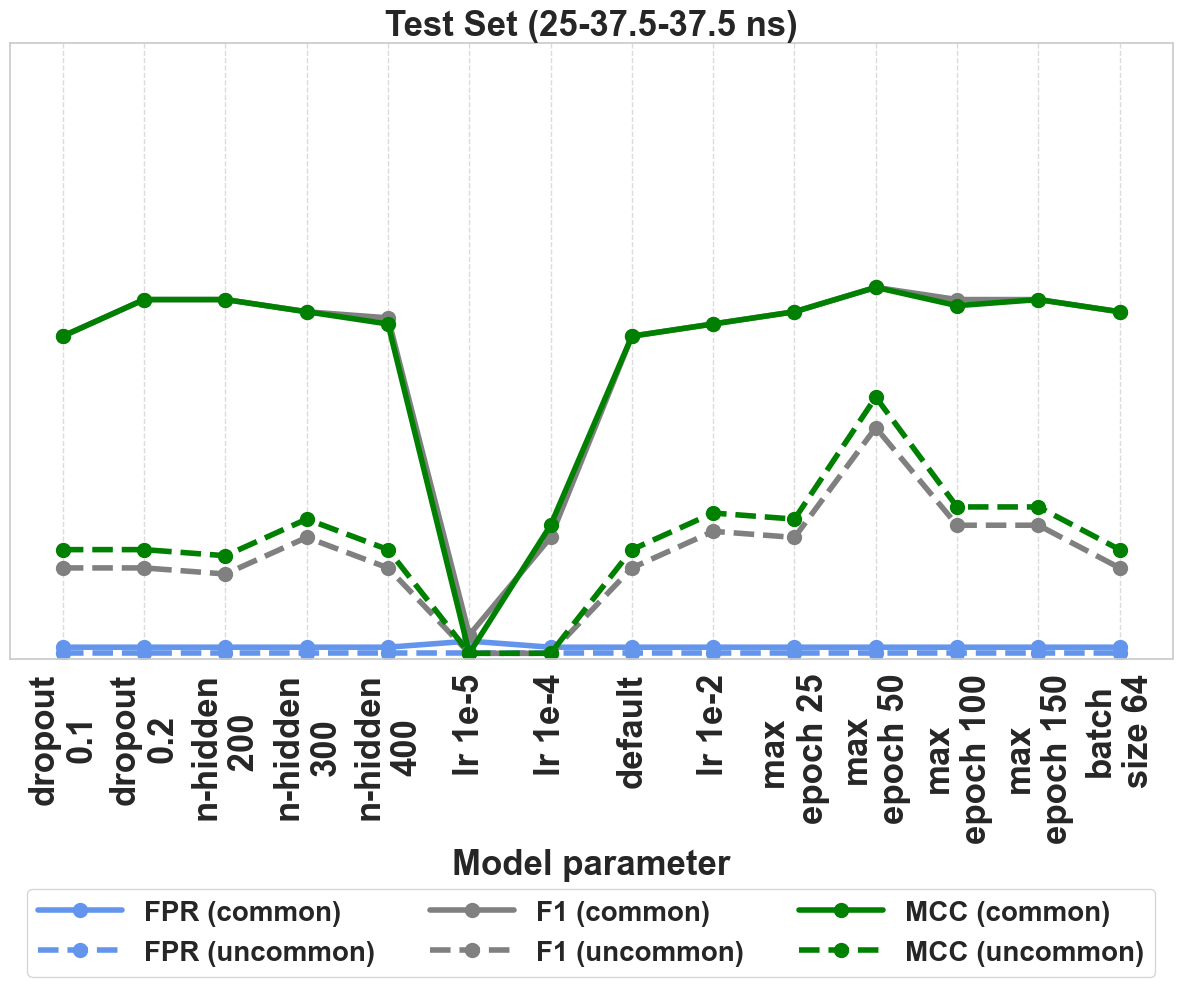

In [70]:
plt.figure(figsize=(15, 8))  # Adjust the width and height as needed

# Plotting the data
plt.plot(performance_test_50_75_75['1JPS 50-75-75 Split'], performance_test_50_75_75['FPR (common)'], marker='o', color='cornflowerblue', label='FPR (common)', linewidth=4.0,markersize=10)
plt.plot(performance_test_50_75_75['1JPS 50-75-75 Split'], performance_test_50_75_75['FPR (uncommon)'], marker='o', color='cornflowerblue', linestyle='--', label='FPR (uncommon)', linewidth=4.0,markersize=10)
plt.plot(performance_test_50_75_75['1JPS 50-75-75 Split'], performance_test_50_75_75['F1 (common)'], marker='o', color='gray', label='F1 (common)', linewidth=4.0,markersize=10)
plt.plot(performance_test_50_75_75['1JPS 50-75-75 Split'], performance_test_50_75_75['F1 (uncommon)'], marker='o', color='gray', linestyle='--', label='F1 (uncommon)', linewidth=4.0,markersize=10)
plt.plot(performance_test_50_75_75['1JPS 50-75-75 Split'], performance_test_50_75_75['MCC (common)'], marker='o', color='green', label='MCC (common)', linewidth=4.0,markersize=10)
plt.plot(performance_test_50_75_75['1JPS 50-75-75 Split'], performance_test_50_75_75['MCC (uncommon)'], marker='o', color='green', linestyle='--', label='MCC (uncommon)', linewidth=4.0,markersize=10)



# Adding labels and title
plt.ylim((-0.01,1))
plt.xlabel('Model parameter', fontsize=25, fontweight='bold')
plt.ylabel("")
plt.title('Test Set (25-37.5-37.5 ns)', fontsize=25, fontweight='bold')

# Adding legend
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.35), prop={'weight': 'bold','size': '20'}, handlelength=3.0)
plt.tick_params(axis='y', labelsize=25)
plt.tick_params(axis='x', labelsize=25)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation='vertical',weight="bold")
plt.gca().set_yticks([])

# Display the plot
plt.savefig('./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/graphs/testPerformances_50_75_75.png', dpi=300, bbox_inches='tight')
plt.show()


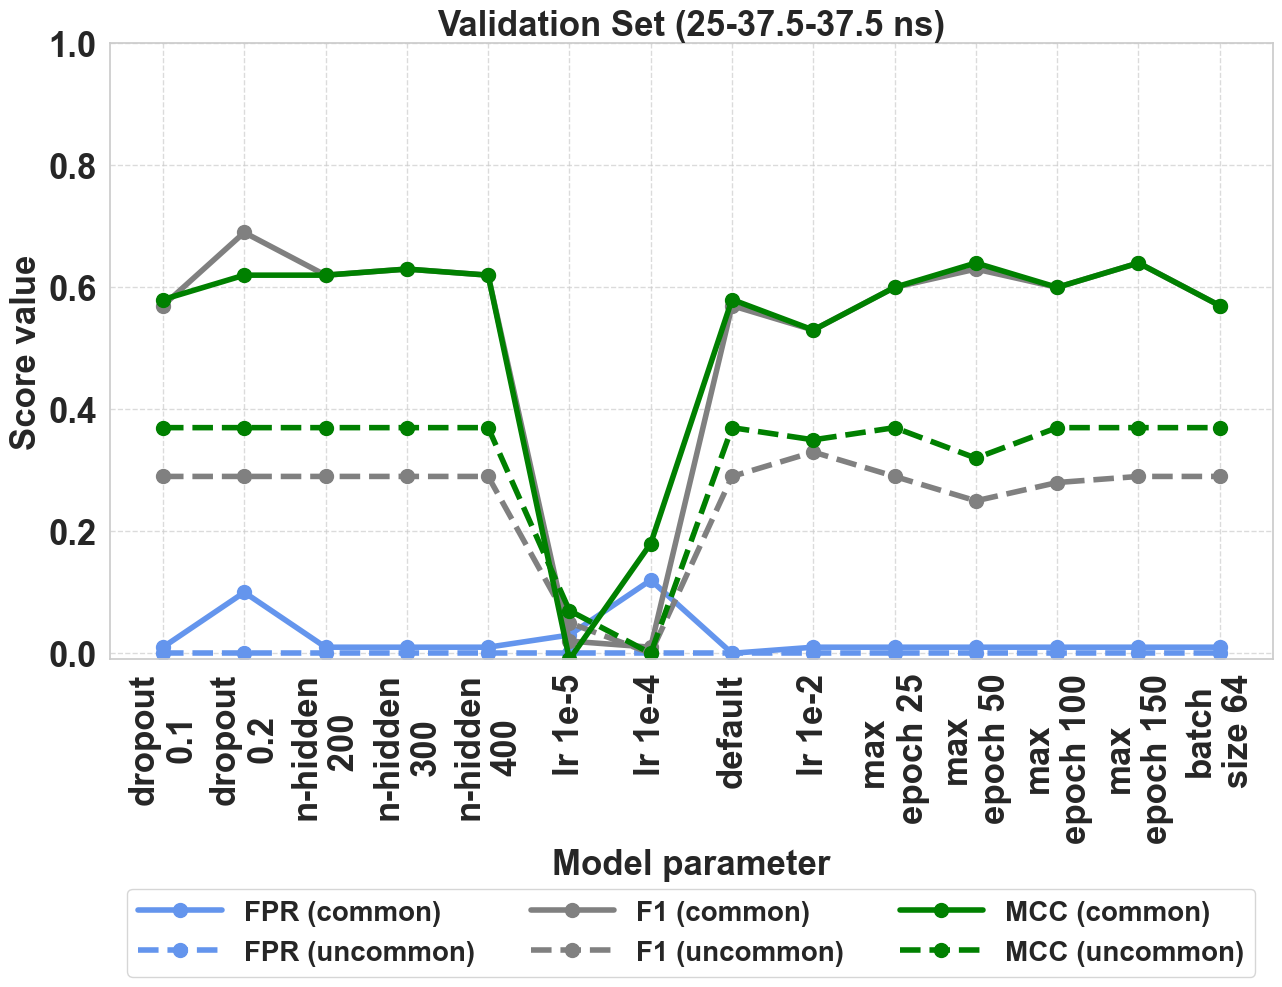

In [71]:
plt.figure(figsize=(15, 8))  # Adjust the width and height as needed

# Plotting the data
plt.plot(performance_valid_50_75_75['1JPS 50-75-75 Split'], performance_valid_50_75_75['FPR (common)'], marker='o', color='cornflowerblue', label='FPR (common)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_50_75_75['1JPS 50-75-75 Split'], performance_valid_50_75_75['FPR (uncommon)'], marker='o', color='cornflowerblue', linestyle='--', label='FPR (uncommon)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_50_75_75['1JPS 50-75-75 Split'], performance_valid_50_75_75['F1 (common)'], marker='o', color='gray', label='F1 (common)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_50_75_75['1JPS 50-75-75 Split'], performance_valid_50_75_75['F1 (uncommon)'], marker='o', color='gray', linestyle='--', label='F1 (uncommon)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_50_75_75['1JPS 50-75-75 Split'], performance_valid_50_75_75['MCC (common)'], marker='o', color='green', label='MCC (common)', linewidth=4.0,markersize=10)
plt.plot(performance_valid_50_75_75['1JPS 50-75-75 Split'], performance_valid_50_75_75['MCC (uncommon)'], marker='o', color='green', linestyle='--', label='MCC (uncommon)', linewidth=4.0,markersize=10)



# Adding labels and title
plt.ylim((-0.01,1))
plt.xlabel('Model parameter', fontsize=25, fontweight='bold')
plt.ylabel('Score value', fontsize=25, fontweight='bold')
plt.title('Validation Set (25-37.5-37.5 ns)', fontsize=25, fontweight='bold')

# Adding legend
plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.35), prop={'weight': 'bold','size': '20'}, handlelength=3.0)
plt.tick_params(axis='y', labelsize=25)
plt.tick_params(axis='x', labelsize=25)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation='vertical',weight="bold")
plt.yticks(weight = 'bold')

# Display the plot
plt.savefig('./Splitting/50-75-75/graphs_and_tables_for_optimized_hyperparameter_50-75-75/graphs/validPerformances_50_75_75.png', dpi=300, bbox_inches='tight')
plt.show()
